In [127]:
from sklearn import neighbors
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
from termcolor import colored;
from warnings import filterwarnings;

# Sklearn and model imports:-
from sklearn.pipeline import Pipeline;
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler;
from sklearn_pandas import DataFrameMapper, gen_features;
from sklearn.model_selection import GridSearchCV;

from lightgbm import LGBMClassifier;
from xgboost import XGBClassifier;
from catboost import CatBoostClassifier;
from sklearn.metrics import auc, roc_auc_score;
from gc import collect;

In [47]:
train_df = pd.read_csv('train.csv')
xtest = pd.read_csv("test.csv")

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [10]:
# Visualizing the data:-
print(colored(f"\nTrain data:-\n", color = 'blue', attrs= ['bold', 'dark']));
display(train_df.head(5));
print(colored(f"\nTest data:-\n", color = 'blue', attrs= ['bold', 'dark']));
display(xtest.head(5));

#print(colored(f"\nSample Submission:-\n", color = 'blue', attrs= ['bold', 'dark']));
#display(sub_fl.head(5));

Ftre_Lst = list(train_df.drop('Transported', axis=1).columns);
Target = 'Transported';

print(colored(f"\nModel Features:-\n", color = 'blue', attrs= ['bold', 'dark']));



Train data:-



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



Test data:-



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez



Model Features:-

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


In [14]:
# Train-test information and description:-
print(colored(f"\nTrain set info\n", color=  'blue', attrs= ['bold', 'dark']));
display(train_df.info());

print(colored(f"\nTest set info\n", color=  'blue', attrs= ['bold', 'dark']));
display(xtest.info());

print(colored(f"\nTrain set description\n", color=  'blue', attrs= ['bold', 'dark']));
display(train_df.describe().transpose().style.format('{:,.2f}'));

print(colored(f"\nTest set description\n", color=  'blue', attrs= ['bold', 'dark']));
display(xtest.describe().transpose().style.format('{:,.2f}'));


Train set info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


None


Test set info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


None


Train set description



,count,mean,std,min,25%,50%,75%,max
Age,"8,514.00",28.83,14.49,0.00,19.00,27.00,38.00,79.00
RoomService,"8,512.00",224.69,666.72,0.00,0.00,0.00,47.00,"14,327.00"
FoodCourt,"8,510.00",458.08,"1,611.49",0.00,0.00,0.00,76.00,"29,813.00"
ShoppingMall,"8,485.00",173.73,604.70,0.00,0.00,0.00,27.00,"23,492.00"
Spa,"8,510.00",311.14,"1,136.71",0.00,0.00,0.00,59.00,"22,408.00"
VRDeck,"8,505.00",304.85,"1,145.72",0.00,0.00,0.00,46.00,"24,133.00"



Test set description



,count,mean,std,min,25%,50%,75%,max
Age,"4,186.00",28.66,14.18,0.00,19.00,26.00,37.00,79.00
RoomService,"4,195.00",219.27,607.01,0.00,0.00,0.00,53.00,"11,567.00"
FoodCourt,"4,171.00",439.48,"1,527.66",0.00,0.00,0.00,78.00,"25,273.00"
ShoppingMall,"4,179.00",177.30,560.82,0.00,0.00,0.00,33.00,"8,292.00"
Spa,"4,176.00",303.05,"1,117.19",0.00,0.00,0.00,50.00,"19,844.00"
VRDeck,"4,197.00",310.71,"1,246.99",0.00,0.00,0.00,36.00,"22,272.00"


In [26]:
print(f"Train data:\n",train_df.isnull().sum())
print(f"Test Data:-\n",xtest.isnull().sum())

Train data:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Test Data:-
 PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [27]:
print(train_df.describe(include=['O']))
print(xtest.describe(include=['O']))

       PassengerId HomePlanet CryoSleep    Cabin  Destination    VIP  \
count         8693       8492      8476     8494         8511   8490   
unique        8693          3         2     6560            3      2   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e  False   
freq             1       4602      5439        8         5915   8291   

                  Name  
count             8493  
unique            8473  
top     Gollux Reedall  
freq                 2  
       PassengerId HomePlanet CryoSleep    Cabin  Destination    VIP  \
count         4277       4190      4184     4177         4185   4184   
unique        4277          3         2     3265            3      2   
top        0013_01      Earth     False  G/160/P  TRAPPIST-1e  False   
freq             1       2263      2640        8         2956   4110   

              Name  
count         4183  
unique        4176  
top     Cints Erle  
freq             2  


In [63]:
train_df['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [62]:
for i in list(train_df.drop(['PassengerId','Cabin','Age','RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Name'],axis =1).columns):
    print(colored(f"\nValueCounts for {i}\n", color = 'blue', attrs= ['dark', 'bold']));
    display(train_df[i].value_counts())


ValueCounts for HomePlanet



Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64


ValueCounts for CryoSleep



False    5439
True     3037
Name: CryoSleep, dtype: int64


ValueCounts for Destination



TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64


ValueCounts for VIP



False    8291
True      199
Name: VIP, dtype: int64


ValueCounts for Transported



True     4378
False    4315
Name: Transported, dtype: int64

In [28]:
train_df[['HomePlanet', 'Transported']].groupby(['HomePlanet'], as_index=False).mean().sort_values(by='Transported', ascending=False)

,HomePlanet,Transported
1,Europa,0.658846
2,Mars,0.523024
0,Earth,0.423946


In [37]:
# Analyzing categorical feature levels and associated target states:-
for col in train_df.drop(['Name', 'PassengerId', 'Cabin'], axis=1).select_dtypes(exclude= np.number).columns:
    print(colored(f"\nAnalysis for {col}\n", color = 'blue', attrs= ['dark', 'bold']));
    display(train_df.groupby(col,dropna=False).agg(Nb_Records=pd.NamedAgg('Transported', np.size),Nb_Transported = pd.NamedAgg('Transported', np.sum)));


Analysis for HomePlanet



,Nb_Records,Nb_Transported
HomePlanet,,
Earth,4602,1951
Europa,2131,1404
Mars,1759,920
NaN,201,103



Analysis for CryoSleep



,Nb_Records,Nb_Transported
CryoSleep,,
False,5439,1789
True,3037,2483
NaN,217,106



Analysis for Destination



,Nb_Records,Nb_Transported
Destination,,
55 Cancri e,1800,1098
PSO J318.5-22,796,401
TRAPPIST-1e,5915,2787
NaN,182,92



Analysis for VIP



,Nb_Records,Nb_Transported
VIP,,
False,8291,4198
True,199,76
NaN,203,104



Analysis for Transported



,Nb_Records,Nb_Transported
Transported,,
False,4315,0
True,4378,4378


In [35]:
train_df.groupby(['VIP', 'Transported']).Transported.count().unstack(fill_value=0)

Transported,False,True
VIP,,
False,4093,4198
True,123,76


In [39]:
train_df.groupby(['HomePlanet', 'Transported']).Transported.count().unstack(fill_value=0)

Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920


In [65]:

# Using GroupBy & size() on multiple column

for i in list(train_df.drop(['PassengerId','Name','Cabin','Transported','Age'],axis =1).columns):
    print(colored(f"\nAnalysis for {i}\n", color = 'blue', attrs= ['dark', 'bold']));
    display(train_df.groupby([i,'Transported'])['Transported'].size().unstack(fill_value=0))
    #print(df2)



Analysis for HomePlanet



Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920



Analysis for CryoSleep



Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483



Analysis for Destination



Transported,False,True
Destination,,
55 Cancri e,702,1098
PSO J318.5-22,395,401
TRAPPIST-1e,3128,2787



Analysis for VIP



Transported,False,True
VIP,,
False,4093,4198
True,123,76



Analysis for RoomService



Transported,False,True
RoomService,,
0.0,2045,3532
1.0,77,40
2.0,47,32
3.0,37,24
4.0,38,9
...,...,...
8209.0,1,0
8243.0,1,0
8586.0,1,0



Analysis for FoodCourt



Transported,False,True
FoodCourt,,
0.0,2232,3224
1.0,90,26
2.0,59,16
3.0,43,10
4.0,42,11
...,...,...
21066.0,0,1
26830.0,0,1
27071.0,0,1



Analysis for ShoppingMall



Transported,False,True
ShoppingMall,,
0.0,2242,3345
1.0,116,37
2.0,61,19
3.0,41,18
4.0,36,9
...,...,...
9058.0,0,1
10424.0,1,0
10705.0,1,0



Analysis for Spa



Transported,False,True
Spa,,
0.0,1921,3403
1.0,94,52
2.0,58,47
3.0,29,24
4.0,29,17
...,...,...
15586.0,1,0
16139.0,1,0
16594.0,1,0



Analysis for VRDeck



Transported,False,True
VRDeck,,
0.0,2044,3451
1.0,92,47
2.0,41,29
3.0,39,17
4.0,28,19
...,...,...
16337.0,1,0
17074.0,1,0
17306.0,1,0


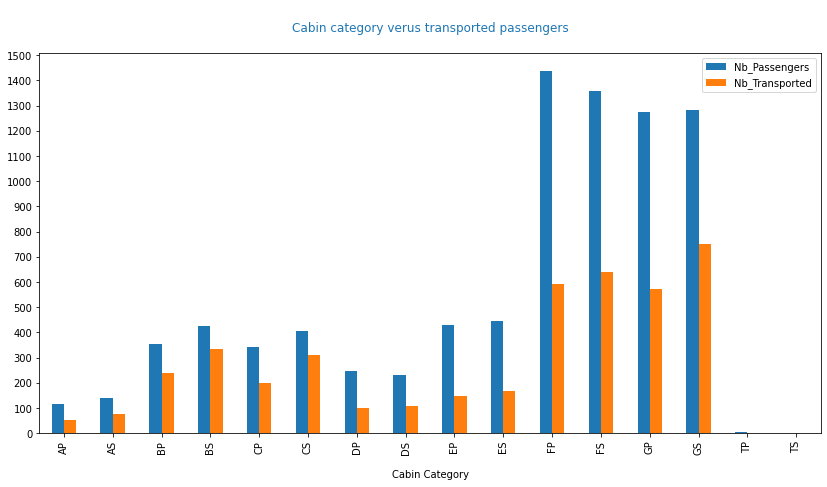

In [99]:
# Analyzing the cabin column further:-
_cabin_prf = train_df.Cabin.str.split('/', expand= True).add_prefix('Cabin').join(train_df.Transported);
_cabin_prf['CabinCtg'] = _cabin_prf['Cabin0']+_cabin_prf['Cabin2'];

fig, ax = plt.subplots(1,1, figsize= (14,7));
_cabin_prf.groupby('CabinCtg').agg(Nb_Passengers= pd.NamedAgg('Transported',np.size), #count
                                   Nb_Transported= pd.NamedAgg('Transported',np.sum)  # count in true transported category
                                  ).plot.bar(ax= ax);
ax.set_title(f"\nCabin category verus transported passengers\n", color= 'tab:blue', fontsize= 12);

ax.set_yticks(range(0,1600,100), fontsize= 8);
ax.set_xlabel("\nCabin Category");
plt.show();

In [100]:
# Generating cross-tab between cabin category and destination:-
_ = _cabin_prf.join(train_df.Destination).groupby(['Destination', 'CabinCtg']).\
agg({'Transported': [np.size, np.sum]}).reset_index().\
pivot(index= 'CabinCtg', columns= 'Destination');

_.columns = [j+'-'+k for i, j,k in _.columns.to_flat_index()];

print(colored(f"\nCross-tab between cabin category and destination\n", 
              color = 'blue', attrs= ['bold', 'dark']));
display(_.style.format(precision = 0));

del _;


Cross-tab between cabin category and destination



,size-55 Cancri e,size-PSO J318.5-22,size-TRAPPIST-1e,sum-55 Cancri e,sum-PSO J318.5-22,sum-TRAPPIST-1e
CabinCtg,,,,,,
AP,53,nan,62,24,nan,25
AS,55,2,80,34,2,40
BP,155,2,187,109,1,124
BS,178,1,239,145,1,181
CP,152,6,174,95,4,91
CS,165,7,231,125,6,177
DP,55,9,179,33,3,63
DS,58,8,159,36,3,65
EP,50,21,350,35,14,94


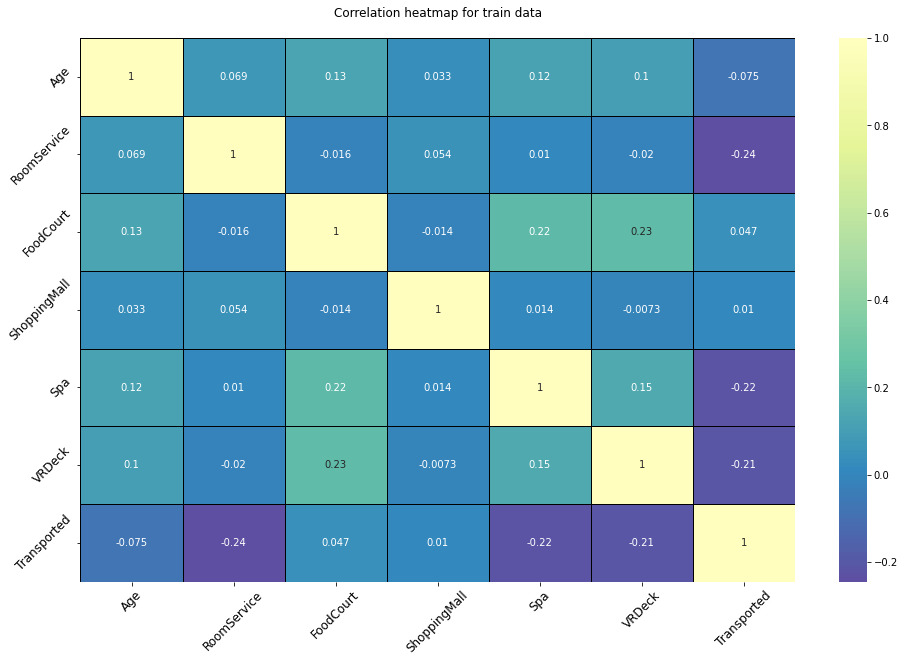

In [105]:
# Analyzing the correlation between the training features and the target:-
fig, ax = plt.subplots(1,1,figsize= (16,10));
sns.heatmap(data=train_df.corr(), cmap = 'Spectral_r', ax=ax,linecolor= 'black', center=True,
            linewidth = 1.0, annot= True);
ax.set_title(f"Correlation heatmap for train data\n", color = 'black', fontsize= 12);
plt.yticks(rotation= 45, fontsize= 12);
plt.xticks(rotation= 45, fontsize= 12);
plt.show();

In [106]:
# Analyzing customer spending by VIP-status and cryosleep:-
filterwarnings('ignore');
df = train_df[['CryoSleep','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']];
df['Total_Spend'] = df.select_dtypes(include= np.number).sum(axis=1);

print(colored(f"Cross-tab:- Total Spend versus Cryosleep and VIP status\n",
      color = 'blue', attrs= ['dark', 'bold']));
display(df.groupby(['CryoSleep', 'VIP'])['Total_Spend'].describe().\
        style.highlight_max(axis=0, color= 'lightblue').\
        format('{:,.2f}'));



Cross-tab:- Total Spend versus Cryosleep and VIP status



## Key notes and inferences:-

1. People in cryosleep did not spend any money throughout the trip

In [107]:
# Analyzing transported passengers versus VIP-status and cryosleep:-
_xtab = df[['VIP','CryoSleep']].join(train_df.Transported).\
groupby(['VIP','CryoSleep']).agg({'Transported': [np.size, np.sum]});


In [109]:
_xtab

Transported      
                       size   sum
VIP   CryoSleep                  
False False            5143  1688
      True             2941  2406
True  False             175    54
      True               21    21

In [110]:
_xtab.columns = ['Nb_Passengers', 'Nb_Transported'];
_xtab['Rt_Transported'] = _xtab['Nb_Transported']/ _xtab['Nb_Passengers'];

print(colored(f"\nCross-tab:- Total transported passengers versus Cryosleep and VIP status\n",
      color = 'blue', attrs= ['dark', 'bold']));
display(_xtab.style.format({'Nb_Passengers': '{:,.0f}','Nb_Transported': '{:,.0f}',
                           'Rt_Transported': '{:.2%}'}));

del _xtab;


Cross-tab:- Total transported passengers versus Cryosleep and VIP status



# Key notes and inferences:-

1. Transportation rate for cryosleep > others
2. VIP passengers also have higher transportation rate than others

In [112]:
# Analyzing total spending and target distribution by age:-
_ = df[['Total_Spend', 'VIP', 'CryoSleep']].join(train_df[['Age', 'Transported']]);
_['Lifestage'] = np.select([_.Age < 13.0, _.Age<18.0], ['1.Child', '2.Teen'], '3.Adult');

print(colored(f"Cross-tab:- Total transported passengers versus Cryosleep,VIP status and Lifestage\n",
      color = 'blue', attrs= ['dark', 'bold']));
display(
_.groupby(['Lifestage','VIP','CryoSleep']).\
agg({'Transported': [np.size, np.sum],'Total_Spend': [np.mean, np.median]}).\
style.format('{:,.0f}').highlight_max(axis=1, color= 'lightblue').\
highlight_min(axis=1, color= 'lightyellow')
);

Cross-tab:- Total transported passengers versus Cryosleep,VIP status and Lifestage



## Key notes and inferences:-

1. Children and teens have a higher propensity for transportation
2. Children under 12 years of age did not spend any money at all, maybe it was captured on their parents' records

In [113]:
# Analyzing Name and Passenger ID to elicit filial relations:-
_ = pd.concat((train_df['PassengerId'].str.split('_', expand= True).add_prefix('ID'),
               train_df['Name'].str.split(' ', expand= True).\
               rename({0:'FirstName', 1:'LastName'}, axis=1),
              _[['Total_Spend']],
              train_df[['CryoSleep', 'Transported', 'VIP']]
              ),
              axis=1);
_['CryoSleep'] = np.where(_.CryoSleep == True, 1,0);



In [114]:
_

,ID0,ID1,FirstName,LastName,Total_Spend,CryoSleep,Transported,VIP
0,0001,01,Maham,Ofracculy,0.0,0,False,False
1,0002,01,Juanna,Vines,736.0,0,True,False
2,0003,01,Altark,Susent,10383.0,0,False,True
3,0003,02,Solam,Susent,5176.0,0,False,False
4,0004,01,Willy,Santantines,1091.0,0,True,False
...,...,...,...,...,...,...,...,...
8688,9276,01,Gravior,Noxnuther,8536.0,0,False,True
8689,9278,01,Kurta,Mondalley,0.0,1,False,False
8690,9279,01,Fayey,Connon,1873.0,0,True,False
8691,9280,01,Celeon,Hontichre,4637.0,0,False,False


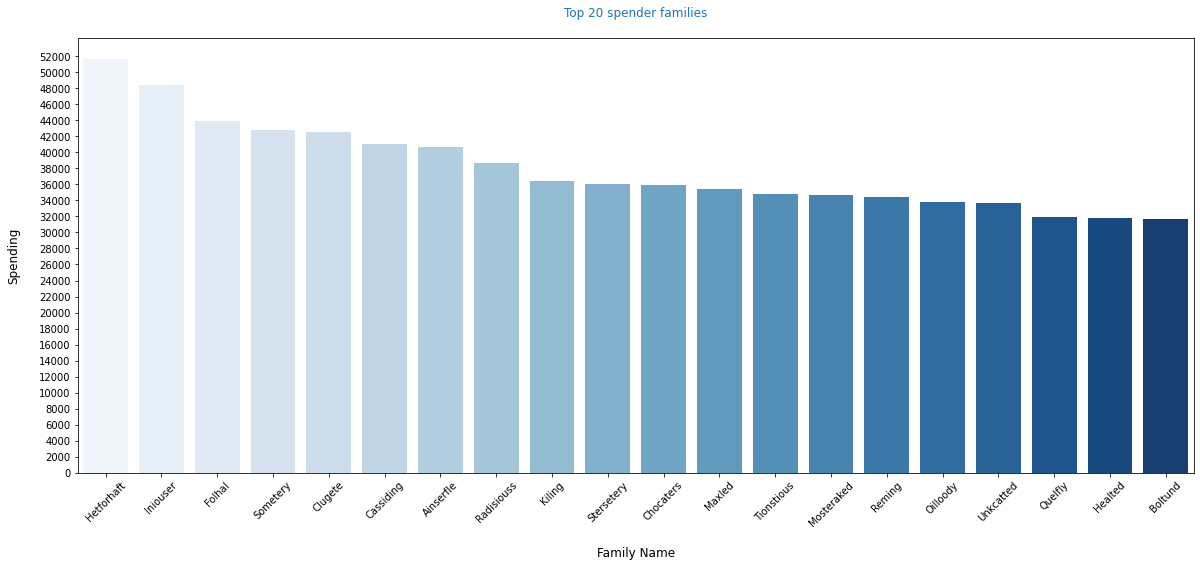

In [116]:
# Pooling spending details and passengers per family name:-
_family_dtl = \
_.groupby(['VIP','LastName']).\
agg(Total_Spend = pd.NamedAgg('Total_Spend',np.sum),
    Nb_Passengers = pd.NamedAgg('Transported', np.size),
    Nb_Transported = pd.NamedAgg('Transported', np.sum),
    Nb_CryoSleep = pd.NamedAgg('CryoSleep', np.sum)
   ).\
reset_index().sort_values('Total_Spend', ascending= False);

_family_dtl['Rt_Transport'] = _family_dtl['Nb_Transported']/ _family_dtl['Nb_Passengers'];

# Plotting the top 20 spender families:-
fig, ax= plt.subplots(1,1, figsize= (20,8));
sns.barplot(data= _family_dtl.head(20),y= 'Total_Spend', x= 'LastName', 
            palette= 'Blues', ax=ax);
ax.set_title("Top 20 spender families\n", color= 'tab:blue', fontsize=12);

ax.set_yticks(range(0,53000,2000));
ax.set_xlabel(f"\nFamily Name\n", fontsize=12);
ax.set_ylabel(f"Spending\n", fontsize=12);
plt.xticks(rotation=45);
plt.show();

# Data Processing

# 2. Data Transformation Pipeline:-

In this section, we develop a pipeline that elicits the data transformation process and returns the associated model train-test sets. Custom classes and functions are used to develop the pipeline.

This is divided into 4 functions as below-
1. Add features- create new columns for name, cabinID components and treat nulls in float columns for amenities
2. Treat nulls in age and cryosleep columns based on family name and spending details
3. Create journey column based on null treated home planet and destination, based on family name
4. Treat nulls in VIP and cabin columns based on family names

The pipeline is then developed using FunctionTransformer as all of these functions are stateless

In [117]:
def AddFeatures(X: pd.DataFrame):
    "This function adds the name split, total spending features and treats nulls in amenities";
    
    df = pd.concat((X[Ftre_Lst].drop(['Name', 'Cabin'],axis=1),
                X.Name.str.split(' ', expand= True).add_prefix('Name'),
                X.Cabin.str.split('/', expand= True).add_prefix('Cabin')), axis=1);

    df[['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']]=\
    df[['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0.0);
    df['TotalSpend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + \
    df['Spa'] + df['VRDeck'];
    
    df['VIP'] = df['VIP']*1.0;
    df['VIP'] = df['VIP'].astype(np.float16);
    
    return df;

In [118]:
def TrtNullAgeCrSlp(df:pd.DataFrame):
    """
    This function fills nulls in age and cryosleep as below-
    Cryosleep:-
    1. For non-spenders, cryosleep=1 as cryosleep customers don't spend
    2. If age <=12 and cryosleep is null, then cryosleep= 1
    3. For spenders, cryosleep= 0
    
    Age:-
    1. For spenders/ non-cryosleep, median age > 12 for family is considered (child cannot spend)
    2. For all remaining nulls, overall median age is used
    
    Flag for Is_Child (Age <=12) is also created
    """;
    
    # 1. Filling nulls in cryosleep based on spending and age details:-
    df['CryoSleep'] = np.float16(df['CryoSleep']*1.0);
    df.loc[(df.CryoSleep.isna()==True) & (df.TotalSpend == 0.0), ['CryoSleep']] = 1.0;
    # Assuming child (age <=12) and null cryosleep = cryosleep
    df.loc[(df.CryoSleep.isna()==True) & (df.Age <=12), ['CryoSleep']] = 1.0;
    # Assuming no cryosleep for spenders:-
    df.loc[(df.CryoSleep.isna()==True) & (df['TotalSpend'] > 0.0), ['CryoSleep']] = 0.0;
    df['CryoSleep'] = df['CryoSleep'].astype(np.int8);
    
    # 2. Assuming average family age for spenders:-
    df = df.merge(df.loc[df.Age >12,['Name1', 'Age']].dropna().groupby('Name1').\
                  agg(_Age= pd.NamedAgg('Age', np.median)),
                  how= 'left', left_on= 'Name1', right_on='Name1', suffixes= ('',''));
    df.loc[(df.Age.isna()==True) & ((df.TotalSpend > 0.0) | (df.CryoSleep==0)), ['Age']] = df._Age;
    # Filling median age for remaining nulls:-
    df['Age'] = df['Age'].fillna(df.Age.median());
    
    # 3. Creating flag for child:-
    df['Is_Child'] = np.where(df.Age <= 12, 1,0);
    df['Is_Child'] = df['Is_Child'].astype(np.int8);
    
    df = df.drop(['_Age'], axis=1);  
    df['Age'] = df['Age'].astype(np.int8);
    return df;

In [119]:
def CreateJourney(df: pd.DataFrame):
    """
    This function treats nulls in HomePlanet and Destination and combines them to form Journey
    1. Home Planet:-
    a. Based on family name, home planet nulls are filled (all family members have same home planet)
    b. Remaining nulls are filled using the overall mode
    
    2. Destination:-
    a. Based on family name, mode of destination is created and filled up for nulls
    b. For all remaining nulls, overall mode is used
    
    3. Journey = HomePlanet - Destination is the interaction feature
    """;
    
    # 1. Fostering null treatment for HomePlanet based on last name and overall mode:-
    df = df.merge(df[['Name1', 'HomePlanet']].drop_duplicates().dropna(), 
                 how= 'left',left_on= 'Name1', right_on= 'Name1', suffixes= ('', '_'));
    df['HomePlanet'] = df['HomePlanet'].fillna(df.HomePlanet_);
    df['HomePlanet'] = df['HomePlanet'].fillna(df[['HomePlanet']].\
                                               apply(lambda x: x.mode()).values[0][0]);

    # 2. Fostering null treatment for destination based on last name and overall mode:-
    _ = df[['Name1', 'Destination']].groupby('Name1')['Destination'].\
    value_counts(ascending= False);
    _.name = 'Nb_Destination';
    _ = _.reset_index().groupby(['Name1']).head(1);

    df = df.merge(_, how = 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('', '_'));
    df['Destination'] = df['Destination'].fillna(df['Destination_']);
    df['Destination'] = df['Destination'].fillna(df[['Destination']].\
                                                 apply(lambda x: x.mode()).values[0][0]);
    del _;

    # 3. Developing interaction column for journey:-
    df['Journey'] = df['HomePlanet'] + ' - ' + df['Destination'];
    df = df.drop(['HomePlanet','Destination','HomePlanet_','Destination_','Nb_Destination'], 
                 axis=1,errors = 'ignore');

    return df;

In [120]:
def TrtNullVIPCabin(df: pd.DataFrame):
    """
    This function treats nulls in VIP and cabin columns using the last name.
    We assume that members of the same family have the same cabin and VIP IDs
    As an addition, it downcasts the float64 columns to conserve memory.
    """;

    # Assuming that members of the same family have the same VIP ID:-
    df = df.merge(df[['VIP', 'Name1']].groupby('Name1')['VIP'].max(), 
                how = 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['VIP'] = df['VIP'].fillna(df.VIP_);
    df['VIP'] = df['VIP'].fillna(0.0);
    df['VIP'] = df['VIP'].astype(np.int8);

    # Assuming that members of the same family have the same cabin0/ cabin2 ID:-
    _ = df[['Cabin0', 'Name1']].groupby('Name1')['Cabin0'].value_counts();
    _.name = 'Nb_Records';
    df = df.merge(_.reset_index().groupby('Name1').head(1).drop('Nb_Records', axis=1), 
                how= 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['Cabin0'] = df['Cabin0'].fillna(df.Cabin0_);
    del _;

    _ = df[['Cabin2', 'Name1']].groupby('Name1')['Cabin2'].value_counts();
    _.name = 'Nb_Records';
    df = df.merge(_.reset_index().groupby('Name1').head(1).drop('Nb_Records', axis=1), 
                how= 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['Cabin2'] = df['Cabin2'].fillna(df.Cabin2_);

    df = df.drop(['Cabin0_', 'Cabin2_'], axis=1, errors= 'ignore');
    del _;

    # Considering remaining nulls with overall cabin mode based on VIP status:-
    df = df.merge(df.groupby(['VIP']).agg({'Cabin0': lambda df: df.mode(), 'Cabin2': lambda y: y.mode()}),
                how= 'left', left_on= 'VIP', right_index= True, suffixes= ('', '_'));
    df['Cabin0'] = df['Cabin0'].fillna(df.Cabin0_);
    df['Cabin2'] = df['Cabin2'].fillna(df.Cabin2_);
    df = df.drop(['Cabin0_', 'Cabin2_', 'VIP_'], axis=1, errors= 'ignore');
 
    # Downcasting columns to conserve memory:-    
    df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend']] = \
    df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend']].astype(np.float16);  
    
    # Dropping extra columns after usage:-
    df = df.drop(['Cabin1', 'Name0', 'Name1'], axis=1, errors= 'ignore');
    return df;

In [128]:
# Organizing the target columns:-
ytrain = np.where(train_df[['Transported']] == True, 1,0).ravel();

# Collating train data for the feature transformation:-
Xtrain = train_df.drop('Transported', axis=1);

# Developing the data transformer pipeline:-
Data_Xformer=\
Pipeline(steps= 
         [('AddFeatures', FunctionTransformer(AddFeatures)),
          ('TrtNullAgeCrSlp', FunctionTransformer(TrtNullAgeCrSlp)),
          ('CreateJourney', FunctionTransformer(CreateJourney)),
          ('TrtNullVIPCabin', FunctionTransformer(TrtNullVIPCabin)),
          ('LblEncode', DataFrameMapper(input_df= True, df_out= True, drop_cols= ['PassengerId'],default=None,
                                       features=gen_features(columns= [['Journey'], ['Cabin0'], ['Cabin2']],
                                                             classes= [LabelEncoder])
                                       ))
         ], verbose= True);

# Implementing the pipeline on the training set and test set:-
Xtrain = Data_Xformer.fit_transform(Xtrain, ytrain);
Xtest = Data_Xformer.transform(xtest);

print(colored(f"\nTrain-Test pipeline implementation results", color= 'blue', attrs= ['bold', 'dark']));
print(colored(f"{len(Xtrain), len(Xtest)}", color = 'blue'));

print(colored(f"\nTrain-set pipeline output columns", color= 'blue', attrs= ['bold', 'dark']));
print(colored(f"{list(Xtrain.columns)}", color = 'blue'));

print(colored(f"\nTest-set pipeline output columns", color= 'blue', attrs= ['bold', 'dark']));
print(colored(f"{list(Xtest.columns)}", color = 'blue'));

collect();

[Pipeline] ....... (step 1 of 5) Processing AddFeatures, total=   0.0s
[Pipeline] ... (step 2 of 5) Processing TrtNullAgeCrSlp, total=   0.0s
[Pipeline] ..... (step 3 of 5) Processing CreateJourney, total=   0.0s
[Pipeline] ... (step 4 of 5) Processing TrtNullVIPCabin, total=   0.0s
[Pipeline] ......... (step 5 of 5) Processing LblEncode, total=   0.0s

Train-Test pipeline implementation results
(8693, 4277)

Train-set pipeline output columns
['Journey', 'Cabin0', 'Cabin2', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'Is_Child']

Test-set pipeline output columns
['Journey', 'Cabin0', 'Cabin2', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'Is_Child']


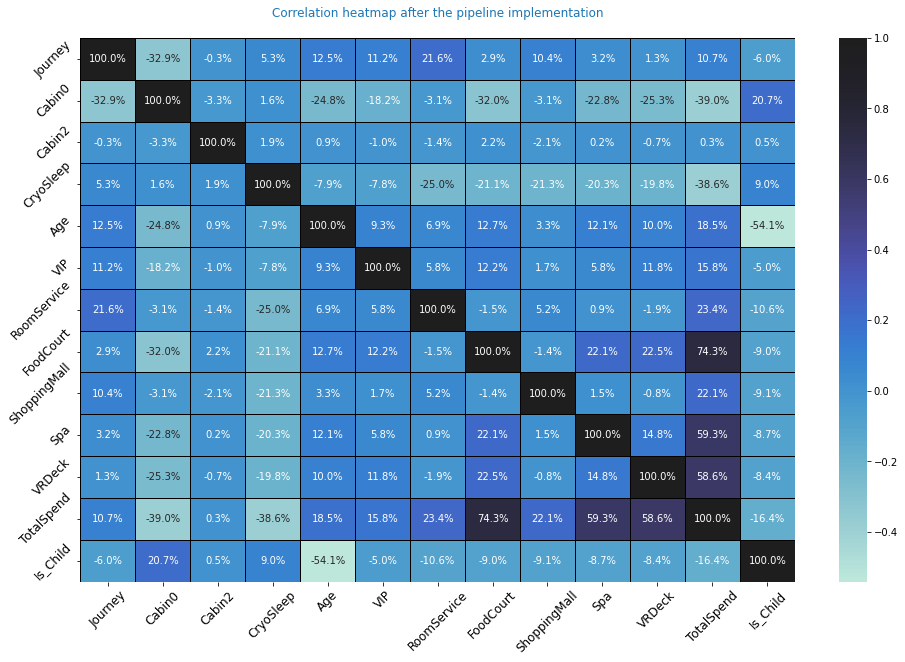

In [131]:
# Plotting correlation plot after the pipeline:-
fig, ax= plt.subplots(1,1, figsize= (16,10));
sns.heatmap(Xtrain.corr(), cmap = 'icefire', annot= True, fmt= '.1%', 
            linewidth= 1.0, linecolor= 'black', ax=ax, center= True);
ax.set_title("Correlation heatmap after the pipeline implementation\n", fontsize= 12, color= 'tab:blue');
plt.yticks(rotation= 45, fontsize= 12);
plt.xticks(rotation= 45, fontsize= 12);
plt.show();

collect();

In [142]:
from tqdm.notebook import tqdm;
# Estimating the best model parameters using grid-search:-
param_grid = {'n_estimators': [500],
              'learning_rate': np.arange(0.05,0.15,0.01),
              'max_depth': range(4,10,1)};

mdl_grid = {'LGBM': LGBMClassifier(random_state=42),
            'XgBoost': XGBClassifier(random_state=42),
            'CatBoost': CatBoostClassifier(random_state=42, verbose= False)
           };
mdl_best_params = {};

for mdl_name, mdl in tqdm(mdl_grid.items()):
    print(colored(f"\nCurrent model is {mdl_name}\n", color= 'blue', attrs= ['bold', 'dark']));
    grid= GridSearchCV(estimator= mdl, param_grid= param_grid, scoring= 'roc_auc', cv= 5);
    grid.fit(Xtrain, ytrain, verbose= False);
    print(colored(f"{grid.best_params_}\n", color= 'red'));
    mdl_best_params[mdl_name] = grid.best_params_;  
    collect();
collect();             

  0%|          | 0/3 [00:00<?, ?it/s]


Current model is LGBM

{'learning_rate': 0.060000000000000005, 'max_depth': 4, 'n_estimators': 500}


Current model is XgBoost

[14:35:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:35:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:35:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:

[14:36:19] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:21] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:22] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:36:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:37:17] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:19] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:37:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:38:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:17] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:38:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:39:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:39:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:39:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:39:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:39:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:39:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:39:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:39:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:40:08] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:40:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [143]:
# Creating the output dataframe for test predictions:-
Mdl_Pred_Prf = pd.DataFrame(data= None, index= xtest['PassengerId'], columns= None);

# Defining the training function for the ensemble models:-
def TrainEnsembles(mdl_name: str, n_mdl_runs: np.int16 = 500, mdl_best_params= mdl_best_params, 
                   sample_frac:np.float16 = 0.95):
    """
    This function trains the ensemble models based on the best parameters obtained from the grid-search.
    Inputs- 
    1. mdl_name- (string):- Model ensemble method
    2. n_mdl_runs- (int):- Number of candidates
    3. mdl_best_params- (dict):- Best parameters (from grid search)
    4. sample_frac- (float):- Sampling fraction for the training set
    """;
    
    for i in tqdm(range(0,n_mdl_runs,1)):
        print(colored(f"\nIteration{i}", color= 'blue', attrs= ['bold', 'dark']));
        xtr = Xtrain.sample(random_state = i, frac= sample_frac);
        xdev = Xtrain.loc[~Xtrain.index.isin(xtr.index)];
        ytr = ytrain[xtr.index];
        ydev = ytrain[xdev.index];
        
        if mdl_name == 'LGBM':
            mdl = LGBMClassifier(**mdl_best_params.get('LGBM'));
        elif mdl_name == 'XgBoost':
            mdl = XGBClassifier(**mdl_best_params.get('XgBoost'));
        elif mdl_name == 'CatBoost':
            mdl = CatBoostClassifier(**mdl_best_params.get('CatBoost'), eval_metric= 'AUC');
        
        if mdl_name != 'CatBoost':
            mdl.fit(xtr, ytr, eval_set=[(xtr, ytr), (xdev, ydev)], eval_metric= ['auc'], 
                    early_stopping_rounds= 35, verbose= 50);
        elif mdl_name == 'CatBoost':
            mdl.fit(xtr, ytr, eval_set=[(xtr, ytr), (xdev, ydev)], early_stopping_rounds= 35,verbose= 50);
            
        Mdl_Pred_Prf[f"{mdl_name}{i}"] = mdl.predict_proba(Xtest)[:,1];

        del xtr, xdev, ytr, ydev;
        collect();
    collect();
collect();

In [144]:
TrainEnsembles(mdl_name= 'LGBM', n_mdl_runs = 1000);
TrainEnsembles(mdl_name= 'XgBoost', n_mdl_runs = 1000);
TrainEnsembles(mdl_name= 'CatBoost', n_mdl_runs = 1000);

collect();

  0%|          | 0/1000 [00:00<?, ?it/s]


Iteration0
[50]	training's auc: 0.897301	training's binary_logloss: 0.414307	valid_1's auc: 0.889102	valid_1's binary_logloss: 0.418963
[100]	training's auc: 0.904697	training's binary_logloss: 0.392201	valid_1's auc: 0.895801	valid_1's binary_logloss: 0.400601
[150]	training's auc: 0.912213	training's binary_logloss: 0.376691	valid_1's auc: 0.903347	valid_1's binary_logloss: 0.384707
[200]	training's auc: 0.918482	training's binary_logloss: 0.363673	valid_1's auc: 0.907258	valid_1's binary_logloss: 0.376631
[250]	training's auc: 0.923364	training's binary_logloss: 0.353629	valid_1's auc: 0.909749	valid_1's binary_logloss: 0.371473
[300]	training's auc: 0.927367	training's binary_logloss: 0.345219	valid_1's auc: 0.913554	valid_1's binary_logloss: 0.365858
[350]	training's auc: 0.932283	training's binary_logloss: 0.335657	valid_1's auc: 0.915653	valid_1's binary_logloss: 0.361048

Iteration1
[50]	training's auc: 0.897681	training's binary_logloss: 0.412451	valid_1's auc: 0.854754	valid

[200]	training's auc: 0.919488	training's binary_logloss: 0.361423	valid_1's auc: 0.870083	valid_1's binary_logloss: 0.442729
[250]	training's auc: 0.924651	training's binary_logloss: 0.350424	valid_1's auc: 0.871819	valid_1's binary_logloss: 0.438145
[300]	training's auc: 0.928797	training's binary_logloss: 0.341735	valid_1's auc: 0.87364	valid_1's binary_logloss: 0.4361
[350]	training's auc: 0.932659	training's binary_logloss: 0.333546	valid_1's auc: 0.874635	valid_1's binary_logloss: 0.435065
[400]	training's auc: 0.936642	training's binary_logloss: 0.325329	valid_1's auc: 0.875672	valid_1's binary_logloss: 0.434085

Iteration16
[50]	training's auc: 0.896604	training's binary_logloss: 0.415378	valid_1's auc: 0.888735	valid_1's binary_logloss: 0.426852
[100]	training's auc: 0.904799	training's binary_logloss: 0.392097	valid_1's auc: 0.891625	valid_1's binary_logloss: 0.414116
[150]	training's auc: 0.911941	training's binary_logloss: 0.377019	valid_1's auc: 0.895319	valid_1's binary_l


Iteration31
[50]	training's auc: 0.89628	training's binary_logloss: 0.415437	valid_1's auc: 0.897096	valid_1's binary_logloss: 0.424044
[100]	training's auc: 0.904044	training's binary_logloss: 0.392345	valid_1's auc: 0.905097	valid_1's binary_logloss: 0.402011
[150]	training's auc: 0.910947	training's binary_logloss: 0.37814	valid_1's auc: 0.912009	valid_1's binary_logloss: 0.390906
[200]	training's auc: 0.917317	training's binary_logloss: 0.365239	valid_1's auc: 0.916353	valid_1's binary_logloss: 0.381316
[250]	training's auc: 0.923002	training's binary_logloss: 0.353657	valid_1's auc: 0.919894	valid_1's binary_logloss: 0.37243
[300]	training's auc: 0.927465	training's binary_logloss: 0.344586	valid_1's auc: 0.920782	valid_1's binary_logloss: 0.369107
[350]	training's auc: 0.931841	training's binary_logloss: 0.335636	valid_1's auc: 0.921289	valid_1's binary_logloss: 0.365584
[400]	training's auc: 0.93606	training's binary_logloss: 0.326716	valid_1's auc: 0.92279	valid_1's binary_log


Iteration47
[50]	training's auc: 0.8977	training's binary_logloss: 0.413269	valid_1's auc: 0.865626	valid_1's binary_logloss: 0.452006
[100]	training's auc: 0.906354	training's binary_logloss: 0.389802	valid_1's auc: 0.873662	valid_1's binary_logloss: 0.437
[150]	training's auc: 0.913079	training's binary_logloss: 0.375032	valid_1's auc: 0.87989	valid_1's binary_logloss: 0.425584
[200]	training's auc: 0.919191	training's binary_logloss: 0.3625	valid_1's auc: 0.87859	valid_1's binary_logloss: 0.420793

Iteration48
[50]	training's auc: 0.89682	training's binary_logloss: 0.414948	valid_1's auc: 0.894245	valid_1's binary_logloss: 0.423904
[100]	training's auc: 0.905093	training's binary_logloss: 0.391794	valid_1's auc: 0.899181	valid_1's binary_logloss: 0.407748
[150]	training's auc: 0.912504	training's binary_logloss: 0.375572	valid_1's auc: 0.901372	valid_1's binary_logloss: 0.40305
[200]	training's auc: 0.919746	training's binary_logloss: 0.361168	valid_1's auc: 0.901468	valid_1's bina


Iteration63
[50]	training's auc: 0.897206	training's binary_logloss: 0.413341	valid_1's auc: 0.876094	valid_1's binary_logloss: 0.438652
[100]	training's auc: 0.906416	training's binary_logloss: 0.389578	valid_1's auc: 0.887572	valid_1's binary_logloss: 0.417005
[150]	training's auc: 0.912907	training's binary_logloss: 0.375823	valid_1's auc: 0.891916	valid_1's binary_logloss: 0.407527
[200]	training's auc: 0.919336	training's binary_logloss: 0.36226	valid_1's auc: 0.894115	valid_1's binary_logloss: 0.401416
[250]	training's auc: 0.92534	training's binary_logloss: 0.350084	valid_1's auc: 0.896979	valid_1's binary_logloss: 0.396499

Iteration64
[50]	training's auc: 0.895836	training's binary_logloss: 0.415689	valid_1's auc: 0.896837	valid_1's binary_logloss: 0.415084
[100]	training's auc: 0.905466	training's binary_logloss: 0.391722	valid_1's auc: 0.904099	valid_1's binary_logloss: 0.393416
[150]	training's auc: 0.913564	training's binary_logloss: 0.374869	valid_1's auc: 0.906224	valid


Iteration79
[50]	training's auc: 0.896127	training's binary_logloss: 0.415663	valid_1's auc: 0.890145	valid_1's binary_logloss: 0.425819
[100]	training's auc: 0.905091	training's binary_logloss: 0.392025	valid_1's auc: 0.895052	valid_1's binary_logloss: 0.408963
[150]	training's auc: 0.912938	training's binary_logloss: 0.375826	valid_1's auc: 0.897337	valid_1's binary_logloss: 0.399817

Iteration80
[50]	training's auc: 0.897448	training's binary_logloss: 0.41276	valid_1's auc: 0.875227	valid_1's binary_logloss: 0.447833
[100]	training's auc: 0.90568	training's binary_logloss: 0.390204	valid_1's auc: 0.878018	valid_1's binary_logloss: 0.436288
[150]	training's auc: 0.913968	training's binary_logloss: 0.37363	valid_1's auc: 0.879657	valid_1's binary_logloss: 0.429825
[200]	training's auc: 0.920375	training's binary_logloss: 0.360451	valid_1's auc: 0.881105	valid_1's binary_logloss: 0.426105
[250]	training's auc: 0.925544	training's binary_logloss: 0.349316	valid_1's auc: 0.882205	valid_

[300]	training's auc: 0.929677	training's binary_logloss: 0.340563	valid_1's auc: 0.875429	valid_1's binary_logloss: 0.438257

Iteration93
[50]	training's auc: 0.897675	training's binary_logloss: 0.413712	valid_1's auc: 0.874434	valid_1's binary_logloss: 0.444488
[100]	training's auc: 0.905726	training's binary_logloss: 0.390114	valid_1's auc: 0.8825	valid_1's binary_logloss: 0.432314
[150]	training's auc: 0.912201	training's binary_logloss: 0.375878	valid_1's auc: 0.883664	valid_1's binary_logloss: 0.430617

Iteration94
[50]	training's auc: 0.896484	training's binary_logloss: 0.41509	valid_1's auc: 0.885061	valid_1's binary_logloss: 0.425615
[100]	training's auc: 0.905352	training's binary_logloss: 0.390916	valid_1's auc: 0.888583	valid_1's binary_logloss: 0.414219

Iteration95
[50]	training's auc: 0.897117	training's binary_logloss: 0.414444	valid_1's auc: 0.88012	valid_1's binary_logloss: 0.437414
[100]	training's auc: 0.906573	training's binary_logloss: 0.38984	valid_1's auc: 0.881


Iteration108
[50]	training's auc: 0.897498	training's binary_logloss: 0.413128	valid_1's auc: 0.871811	valid_1's binary_logloss: 0.450671
[100]	training's auc: 0.906348	training's binary_logloss: 0.389392	valid_1's auc: 0.87518	valid_1's binary_logloss: 0.437459

Iteration109
[50]	training's auc: 0.896971	training's binary_logloss: 0.414994	valid_1's auc: 0.878333	valid_1's binary_logloss: 0.43711
[100]	training's auc: 0.905133	training's binary_logloss: 0.391444	valid_1's auc: 0.887544	valid_1's binary_logloss: 0.419221
[150]	training's auc: 0.913211	training's binary_logloss: 0.374812	valid_1's auc: 0.893193	valid_1's binary_logloss: 0.406692
[200]	training's auc: 0.918842	training's binary_logloss: 0.362798	valid_1's auc: 0.892769	valid_1's binary_logloss: 0.403843

Iteration110
[50]	training's auc: 0.896026	training's binary_logloss: 0.416141	valid_1's auc: 0.914973	valid_1's binary_logloss: 0.392666
[100]	training's auc: 0.903567	training's binary_logloss: 0.394304	valid_1's auc:


Iteration126
[50]	training's auc: 0.8965	training's binary_logloss: 0.415561	valid_1's auc: 0.894749	valid_1's binary_logloss: 0.413647
[100]	training's auc: 0.905039	training's binary_logloss: 0.391822	valid_1's auc: 0.89707	valid_1's binary_logloss: 0.401453
[150]	training's auc: 0.912312	training's binary_logloss: 0.376449	valid_1's auc: 0.899295	valid_1's binary_logloss: 0.393404
[200]	training's auc: 0.918477	training's binary_logloss: 0.363707	valid_1's auc: 0.903469	valid_1's binary_logloss: 0.386254
[250]	training's auc: 0.923661	training's binary_logloss: 0.352834	valid_1's auc: 0.905449	valid_1's binary_logloss: 0.380733
[300]	training's auc: 0.928443	training's binary_logloss: 0.34315	valid_1's auc: 0.907418	valid_1's binary_logloss: 0.377105
[350]	training's auc: 0.93159	training's binary_logloss: 0.336377	valid_1's auc: 0.907312	valid_1's binary_logloss: 0.376892

Iteration127
[50]	training's auc: 0.897777	training's binary_logloss: 0.413859	valid_1's auc: 0.873046	valid_

[150]	training's auc: 0.913231	training's binary_logloss: 0.375349	valid_1's auc: 0.907767	valid_1's binary_logloss: 0.386758

Iteration143
[50]	training's auc: 0.896388	training's binary_logloss: 0.415818	valid_1's auc: 0.900848	valid_1's binary_logloss: 0.404545
[100]	training's auc: 0.904725	training's binary_logloss: 0.392894	valid_1's auc: 0.903164	valid_1's binary_logloss: 0.390381
[150]	training's auc: 0.912641	training's binary_logloss: 0.37655	valid_1's auc: 0.905215	valid_1's binary_logloss: 0.384537

Iteration144
[50]	training's auc: 0.896462	training's binary_logloss: 0.415343	valid_1's auc: 0.889633	valid_1's binary_logloss: 0.422046
[100]	training's auc: 0.905411	training's binary_logloss: 0.391034	valid_1's auc: 0.892931	valid_1's binary_logloss: 0.410445

Iteration145
[50]	training's auc: 0.897026	training's binary_logloss: 0.414159	valid_1's auc: 0.877886	valid_1's binary_logloss: 0.439314
[100]	training's auc: 0.906754	training's binary_logloss: 0.389008	valid_1's auc


Iteration161
[50]	training's auc: 0.897589	training's binary_logloss: 0.413059	valid_1's auc: 0.883096	valid_1's binary_logloss: 0.435897
[100]	training's auc: 0.905628	training's binary_logloss: 0.389281	valid_1's auc: 0.888178	valid_1's binary_logloss: 0.422544
[150]	training's auc: 0.912815	training's binary_logloss: 0.374844	valid_1's auc: 0.890194	valid_1's binary_logloss: 0.41902

Iteration162
[50]	training's auc: 0.897814	training's binary_logloss: 0.413558	valid_1's auc: 0.876189	valid_1's binary_logloss: 0.438896

Iteration163
[50]	training's auc: 0.897017	training's binary_logloss: 0.414604	valid_1's auc: 0.879852	valid_1's binary_logloss: 0.426609
[100]	training's auc: 0.905567	training's binary_logloss: 0.391069	valid_1's auc: 0.886593	valid_1's binary_logloss: 0.411355

Iteration164
[50]	training's auc: 0.898043	training's binary_logloss: 0.413354	valid_1's auc: 0.869585	valid_1's binary_logloss: 0.451312
[100]	training's auc: 0.905777	training's binary_logloss: 0.390895	

[150]	training's auc: 0.912959	training's binary_logloss: 0.375574	valid_1's auc: 0.883648	valid_1's binary_logloss: 0.42017
[200]	training's auc: 0.919083	training's binary_logloss: 0.362631	valid_1's auc: 0.885737	valid_1's binary_logloss: 0.416168

Iteration178
[50]	training's auc: 0.896432	training's binary_logloss: 0.415772	valid_1's auc: 0.897369	valid_1's binary_logloss: 0.415214
[100]	training's auc: 0.904907	training's binary_logloss: 0.392394	valid_1's auc: 0.902106	valid_1's binary_logloss: 0.396329
[150]	training's auc: 0.912153	training's binary_logloss: 0.377438	valid_1's auc: 0.902106	valid_1's binary_logloss: 0.390162

Iteration179
[50]	training's auc: 0.898291	training's binary_logloss: 0.412231	valid_1's auc: 0.863738	valid_1's binary_logloss: 0.457499
[100]	training's auc: 0.906432	training's binary_logloss: 0.389208	valid_1's auc: 0.869382	valid_1's binary_logloss: 0.443578
[150]	training's auc: 0.913729	training's binary_logloss: 0.374176	valid_1's auc: 0.874392	va


Iteration196
[50]	training's auc: 0.897765	training's binary_logloss: 0.413744	valid_1's auc: 0.880831	valid_1's binary_logloss: 0.431049
[100]	training's auc: 0.90647	training's binary_logloss: 0.389591	valid_1's auc: 0.887216	valid_1's binary_logloss: 0.410873
[150]	training's auc: 0.913198	training's binary_logloss: 0.374665	valid_1's auc: 0.892671	valid_1's binary_logloss: 0.399735
[200]	training's auc: 0.919811	training's binary_logloss: 0.361363	valid_1's auc: 0.894754	valid_1's binary_logloss: 0.39539
[250]	training's auc: 0.924535	training's binary_logloss: 0.351283	valid_1's auc: 0.895367	valid_1's binary_logloss: 0.39279

Iteration197
[50]	training's auc: 0.896926	training's binary_logloss: 0.414921	valid_1's auc: 0.902842	valid_1's binary_logloss: 0.417346

Iteration198
[50]	training's auc: 0.896326	training's binary_logloss: 0.415171	valid_1's auc: 0.894134	valid_1's binary_logloss: 0.41091
[100]	training's auc: 0.905346	training's binary_logloss: 0.391968	valid_1's auc: 0

[150]	training's auc: 0.912496	training's binary_logloss: 0.376155	valid_1's auc: 0.891368	valid_1's binary_logloss: 0.413033
[200]	training's auc: 0.918747	training's binary_logloss: 0.363096	valid_1's auc: 0.894006	valid_1's binary_logloss: 0.408473
[250]	training's auc: 0.923978	training's binary_logloss: 0.352199	valid_1's auc: 0.895076	valid_1's binary_logloss: 0.405533

Iteration211
[50]	training's auc: 0.897537	training's binary_logloss: 0.413947	valid_1's auc: 0.88189	valid_1's binary_logloss: 0.430469
[100]	training's auc: 0.905759	training's binary_logloss: 0.390528	valid_1's auc: 0.884406	valid_1's binary_logloss: 0.418276
[150]	training's auc: 0.912833	training's binary_logloss: 0.375179	valid_1's auc: 0.885786	valid_1's binary_logloss: 0.413112
[200]	training's auc: 0.919423	training's binary_logloss: 0.362059	valid_1's auc: 0.888005	valid_1's binary_logloss: 0.411505

Iteration212
[50]	training's auc: 0.896865	training's binary_logloss: 0.41534	valid_1's auc: 0.893772	val

[250]	training's auc: 0.924857	training's binary_logloss: 0.350811	valid_1's auc: 0.889936	valid_1's binary_logloss: 0.412209

Iteration227
[50]	training's auc: 0.896717	training's binary_logloss: 0.413763	valid_1's auc: 0.868429	valid_1's binary_logloss: 0.448002
[100]	training's auc: 0.906531	training's binary_logloss: 0.389488	valid_1's auc: 0.875101	valid_1's binary_logloss: 0.432891
[150]	training's auc: 0.913916	training's binary_logloss: 0.373686	valid_1's auc: 0.876779	valid_1's binary_logloss: 0.427975
[200]	training's auc: 0.919227	training's binary_logloss: 0.362114	valid_1's auc: 0.878543	valid_1's binary_logloss: 0.426754
[250]	training's auc: 0.924709	training's binary_logloss: 0.351144	valid_1's auc: 0.879935	valid_1's binary_logloss: 0.426431

Iteration228
[50]	training's auc: 0.896533	training's binary_logloss: 0.415231	valid_1's auc: 0.883928	valid_1's binary_logloss: 0.424736
[100]	training's auc: 0.905751	training's binary_logloss: 0.391331	valid_1's auc: 0.893697	v

[50]	training's auc: 0.8978	training's binary_logloss: 0.4128	valid_1's auc: 0.860503	valid_1's binary_logloss: 0.461938
[100]	training's auc: 0.906168	training's binary_logloss: 0.389156	valid_1's auc: 0.86835	valid_1's binary_logloss: 0.448768
[150]	training's auc: 0.913854	training's binary_logloss: 0.373538	valid_1's auc: 0.872723	valid_1's binary_logloss: 0.442012
[200]	training's auc: 0.920917	training's binary_logloss: 0.359425	valid_1's auc: 0.874894	valid_1's binary_logloss: 0.438926
[250]	training's auc: 0.92571	training's binary_logloss: 0.349285	valid_1's auc: 0.876917	valid_1's binary_logloss: 0.437563

Iteration246
[50]	training's auc: 0.897455	training's binary_logloss: 0.413513	valid_1's auc: 0.864208	valid_1's binary_logloss: 0.455561
[100]	training's auc: 0.906274	training's binary_logloss: 0.390077	valid_1's auc: 0.871829	valid_1's binary_logloss: 0.440718
[150]	training's auc: 0.913489	training's binary_logloss: 0.375031	valid_1's auc: 0.874799	valid_1's binary_logl

[150]	training's auc: 0.913565	training's binary_logloss: 0.374912	valid_1's auc: 0.887379	valid_1's binary_logloss: 0.413379
[200]	training's auc: 0.919878	training's binary_logloss: 0.361791	valid_1's auc: 0.887591	valid_1's binary_logloss: 0.41242

Iteration260
[50]	training's auc: 0.897235	training's binary_logloss: 0.414086	valid_1's auc: 0.875381	valid_1's binary_logloss: 0.436792
[100]	training's auc: 0.905158	training's binary_logloss: 0.391285	valid_1's auc: 0.880764	valid_1's binary_logloss: 0.42366
[150]	training's auc: 0.912463	training's binary_logloss: 0.376098	valid_1's auc: 0.886274	valid_1's binary_logloss: 0.41493

Iteration261
[50]	training's auc: 0.89792	training's binary_logloss: 0.413486	valid_1's auc: 0.876281	valid_1's binary_logloss: 0.440938
[100]	training's auc: 0.905826	training's binary_logloss: 0.39043	valid_1's auc: 0.882223	valid_1's binary_logloss: 0.426752
[150]	training's auc: 0.912926	training's binary_logloss: 0.375349	valid_1's auc: 0.885891	valid_

[250]	training's auc: 0.922369	training's binary_logloss: 0.355593	valid_1's auc: 0.90519	valid_1's binary_logloss: 0.372439

Iteration274
[50]	training's auc: 0.895771	training's binary_logloss: 0.415589	valid_1's auc: 0.912037	valid_1's binary_logloss: 0.397947
[100]	training's auc: 0.904342	training's binary_logloss: 0.392679	valid_1's auc: 0.916152	valid_1's binary_logloss: 0.374844
[150]	training's auc: 0.912356	training's binary_logloss: 0.376063	valid_1's auc: 0.916787	valid_1's binary_logloss: 0.367845
[200]	training's auc: 0.918431	training's binary_logloss: 0.363435	valid_1's auc: 0.915644	valid_1's binary_logloss: 0.365747

Iteration275
[50]	training's auc: 0.898373	training's binary_logloss: 0.412163	valid_1's auc: 0.863373	valid_1's binary_logloss: 0.458395
[100]	training's auc: 0.906843	training's binary_logloss: 0.388393	valid_1's auc: 0.864102	valid_1's binary_logloss: 0.450346

Iteration276
[50]	training's auc: 0.897435	training's binary_logloss: 0.414182	valid_1's auc

[250]	training's auc: 0.92415	training's binary_logloss: 0.351999	valid_1's auc: 0.906329	valid_1's binary_logloss: 0.389154

Iteration290
[50]	training's auc: 0.89713	training's binary_logloss: 0.414842	valid_1's auc: 0.894376	valid_1's binary_logloss: 0.413912
[100]	training's auc: 0.906561	training's binary_logloss: 0.38999	valid_1's auc: 0.900393	valid_1's binary_logloss: 0.3931
[150]	training's auc: 0.912963	training's binary_logloss: 0.376003	valid_1's auc: 0.903027	valid_1's binary_logloss: 0.38649

Iteration291
[50]	training's auc: 0.898034	training's binary_logloss: 0.413274	valid_1's auc: 0.872235	valid_1's binary_logloss: 0.446583
[100]	training's auc: 0.906919	training's binary_logloss: 0.388249	valid_1's auc: 0.878653	valid_1's binary_logloss: 0.431221
[150]	training's auc: 0.914257	training's binary_logloss: 0.372904	valid_1's auc: 0.880704	valid_1's binary_logloss: 0.424507
[200]	training's auc: 0.92028	training's binary_logloss: 0.360343	valid_1's auc: 0.881507	valid_1'


Iteration306
[50]	training's auc: 0.895949	training's binary_logloss: 0.415348	valid_1's auc: 0.891688	valid_1's binary_logloss: 0.420938
[100]	training's auc: 0.905018	training's binary_logloss: 0.392385	valid_1's auc: 0.894648	valid_1's binary_logloss: 0.408769
[150]	training's auc: 0.912092	training's binary_logloss: 0.377275	valid_1's auc: 0.89561	valid_1's binary_logloss: 0.402367

Iteration307
[50]	training's auc: 0.898513	training's binary_logloss: 0.412756	valid_1's auc: 0.857952	valid_1's binary_logloss: 0.459336
[100]	training's auc: 0.907577	training's binary_logloss: 0.387988	valid_1's auc: 0.861318	valid_1's binary_logloss: 0.451938
[150]	training's auc: 0.914648	training's binary_logloss: 0.372984	valid_1's auc: 0.86425	valid_1's binary_logloss: 0.447119
[200]	training's auc: 0.920567	training's binary_logloss: 0.360604	valid_1's auc: 0.866092	valid_1's binary_logloss: 0.443939

Iteration308
[50]	training's auc: 0.89616	training's binary_logloss: 0.415192	valid_1's auc: 


Iteration323
[50]	training's auc: 0.896048	training's binary_logloss: 0.415454	valid_1's auc: 0.894169	valid_1's binary_logloss: 0.416537
[100]	training's auc: 0.905223	training's binary_logloss: 0.391258	valid_1's auc: 0.900561	valid_1's binary_logloss: 0.397606
[150]	training's auc: 0.913112	training's binary_logloss: 0.374888	valid_1's auc: 0.9	valid_1's binary_logloss: 0.390469

Iteration324
[50]	training's auc: 0.897573	training's binary_logloss: 0.413387	valid_1's auc: 0.873841	valid_1's binary_logloss: 0.442284
[100]	training's auc: 0.905618	training's binary_logloss: 0.390086	valid_1's auc: 0.878816	valid_1's binary_logloss: 0.430742
[150]	training's auc: 0.9128	training's binary_logloss: 0.37521	valid_1's auc: 0.884829	valid_1's binary_logloss: 0.42125
[200]	training's auc: 0.918486	training's binary_logloss: 0.363628	valid_1's auc: 0.88828	valid_1's binary_logloss: 0.414682
[250]	training's auc: 0.924188	training's binary_logloss: 0.352356	valid_1's auc: 0.889624	valid_1's b


Iteration338
[50]	training's auc: 0.897953	training's binary_logloss: 0.413352	valid_1's auc: 0.858152	valid_1's binary_logloss: 0.45719
[100]	training's auc: 0.907227	training's binary_logloss: 0.388713	valid_1's auc: 0.860953	valid_1's binary_logloss: 0.446575
[150]	training's auc: 0.914299	training's binary_logloss: 0.373104	valid_1's auc: 0.862866	valid_1's binary_logloss: 0.441717
[200]	training's auc: 0.920507	training's binary_logloss: 0.360375	valid_1's auc: 0.864346	valid_1's binary_logloss: 0.440671

Iteration339
[50]	training's auc: 0.89675	training's binary_logloss: 0.413951	valid_1's auc: 0.878933	valid_1's binary_logloss: 0.441781
[100]	training's auc: 0.90466	training's binary_logloss: 0.391523	valid_1's auc: 0.884638	valid_1's binary_logloss: 0.427293
[150]	training's auc: 0.912112	training's binary_logloss: 0.376706	valid_1's auc: 0.887422	valid_1's binary_logloss: 0.41903
[200]	training's auc: 0.919007	training's binary_logloss: 0.362826	valid_1's auc: 0.89027	valid_

[200]	training's auc: 0.91946	training's binary_logloss: 0.362655	valid_1's auc: 0.892292	valid_1's binary_logloss: 0.396651
[250]	training's auc: 0.924669	training's binary_logloss: 0.351431	valid_1's auc: 0.892874	valid_1's binary_logloss: 0.396554

Iteration356
[50]	training's auc: 0.895762	training's binary_logloss: 0.416313	valid_1's auc: 0.90289	valid_1's binary_logloss: 0.406719
[100]	training's auc: 0.905521	training's binary_logloss: 0.391443	valid_1's auc: 0.908219	valid_1's binary_logloss: 0.386229
[150]	training's auc: 0.913218	training's binary_logloss: 0.375109	valid_1's auc: 0.90857	valid_1's binary_logloss: 0.380832

Iteration357
[50]	training's auc: 0.897476	training's binary_logloss: 0.413079	valid_1's auc: 0.876946	valid_1's binary_logloss: 0.438264
[100]	training's auc: 0.906325	training's binary_logloss: 0.389339	valid_1's auc: 0.881949	valid_1's binary_logloss: 0.422104
[150]	training's auc: 0.91362	training's binary_logloss: 0.374337	valid_1's auc: 0.88473	valid_


Iteration373
[50]	training's auc: 0.897042	training's binary_logloss: 0.414435	valid_1's auc: 0.894722	valid_1's binary_logloss: 0.414533
[100]	training's auc: 0.905952	training's binary_logloss: 0.390123	valid_1's auc: 0.898366	valid_1's binary_logloss: 0.399311
[150]	training's auc: 0.912956	training's binary_logloss: 0.374886	valid_1's auc: 0.902722	valid_1's binary_logloss: 0.387505

Iteration374
[50]	training's auc: 0.897637	training's binary_logloss: 0.413588	valid_1's auc: 0.881047	valid_1's binary_logloss: 0.433621
[100]	training's auc: 0.906597	training's binary_logloss: 0.389655	valid_1's auc: 0.885928	valid_1's binary_logloss: 0.418869
[150]	training's auc: 0.913467	training's binary_logloss: 0.374977	valid_1's auc: 0.88919	valid_1's binary_logloss: 0.409846
[200]	training's auc: 0.919128	training's binary_logloss: 0.362816	valid_1's auc: 0.891901	valid_1's binary_logloss: 0.403921
[250]	training's auc: 0.924095	training's binary_logloss: 0.352468	valid_1's auc: 0.891996	va

[350]	training's auc: 0.932007	training's binary_logloss: 0.335831	valid_1's auc: 0.902773	valid_1's binary_logloss: 0.385133

Iteration391
[50]	training's auc: 0.897041	training's binary_logloss: 0.414279	valid_1's auc: 0.876939	valid_1's binary_logloss: 0.437826
[100]	training's auc: 0.906217	training's binary_logloss: 0.389584	valid_1's auc: 0.879619	valid_1's binary_logloss: 0.423504
[150]	training's auc: 0.912895	training's binary_logloss: 0.375374	valid_1's auc: 0.884291	valid_1's binary_logloss: 0.416406
[200]	training's auc: 0.919105	training's binary_logloss: 0.362401	valid_1's auc: 0.887268	valid_1's binary_logloss: 0.410912
[250]	training's auc: 0.924882	training's binary_logloss: 0.35069	valid_1's auc: 0.887236	valid_1's binary_logloss: 0.409062

Iteration392
[50]	training's auc: 0.896155	training's binary_logloss: 0.415873	valid_1's auc: 0.892177	valid_1's binary_logloss: 0.421749
[100]	training's auc: 0.905496	training's binary_logloss: 0.391099	valid_1's auc: 0.894303	va

[350]	training's auc: 0.932103	training's binary_logloss: 0.334936	valid_1's auc: 0.895018	valid_1's binary_logloss: 0.403589
[400]	training's auc: 0.935779	training's binary_logloss: 0.327214	valid_1's auc: 0.896065	valid_1's binary_logloss: 0.401288
[450]	training's auc: 0.939351	training's binary_logloss: 0.319175	valid_1's auc: 0.899237	valid_1's binary_logloss: 0.396546

Iteration405
[50]	training's auc: 0.896438	training's binary_logloss: 0.415121	valid_1's auc: 0.885009	valid_1's binary_logloss: 0.426312
[100]	training's auc: 0.904745	training's binary_logloss: 0.391709	valid_1's auc: 0.888315	valid_1's binary_logloss: 0.409802
[150]	training's auc: 0.911627	training's binary_logloss: 0.377406	valid_1's auc: 0.89296	valid_1's binary_logloss: 0.401434
[200]	training's auc: 0.917778	training's binary_logloss: 0.364495	valid_1's auc: 0.897872	valid_1's binary_logloss: 0.393339
[250]	training's auc: 0.923586	training's binary_logloss: 0.352774	valid_1's auc: 0.900136	valid_1's binar

[50]	training's auc: 0.896924	training's binary_logloss: 0.415484	valid_1's auc: 0.886796	valid_1's binary_logloss: 0.426282
[100]	training's auc: 0.905679	training's binary_logloss: 0.391411	valid_1's auc: 0.89361	valid_1's binary_logloss: 0.406776
[150]	training's auc: 0.911896	training's binary_logloss: 0.37719	valid_1's auc: 0.896133	valid_1's binary_logloss: 0.399975
[200]	training's auc: 0.91783	training's binary_logloss: 0.364523	valid_1's auc: 0.897464	valid_1's binary_logloss: 0.395975
[250]	training's auc: 0.923228	training's binary_logloss: 0.353307	valid_1's auc: 0.89723	valid_1's binary_logloss: 0.392794

Iteration420
[50]	training's auc: 0.896134	training's binary_logloss: 0.414924	valid_1's auc: 0.898318	valid_1's binary_logloss: 0.412004
[100]	training's auc: 0.905634	training's binary_logloss: 0.390863	valid_1's auc: 0.90733	valid_1's binary_logloss: 0.388415
[150]	training's auc: 0.912791	training's binary_logloss: 0.376066	valid_1's auc: 0.908548	valid_1's binary_log


Iteration435
[50]	training's auc: 0.897113	training's binary_logloss: 0.413899	valid_1's auc: 0.86666	valid_1's binary_logloss: 0.450031
[100]	training's auc: 0.906529	training's binary_logloss: 0.38931	valid_1's auc: 0.873964	valid_1's binary_logloss: 0.43509
[150]	training's auc: 0.913421	training's binary_logloss: 0.374532	valid_1's auc: 0.875909	valid_1's binary_logloss: 0.432921

Iteration436
[50]	training's auc: 0.89767	training's binary_logloss: 0.41348	valid_1's auc: 0.881101	valid_1's binary_logloss: 0.434289
[100]	training's auc: 0.906641	training's binary_logloss: 0.389045	valid_1's auc: 0.885186	valid_1's binary_logloss: 0.422839
[150]	training's auc: 0.913727	training's binary_logloss: 0.373974	valid_1's auc: 0.888157	valid_1's binary_logloss: 0.413647
[200]	training's auc: 0.919727	training's binary_logloss: 0.361576	valid_1's auc: 0.890852	valid_1's binary_logloss: 0.407731
[250]	training's auc: 0.925212	training's binary_logloss: 0.350179	valid_1's auc: 0.890162	valid_


Iteration452
[50]	training's auc: 0.897559	training's binary_logloss: 0.413058	valid_1's auc: 0.868663	valid_1's binary_logloss: 0.451461
[100]	training's auc: 0.90675	training's binary_logloss: 0.388586	valid_1's auc: 0.874609	valid_1's binary_logloss: 0.437513
[150]	training's auc: 0.914859	training's binary_logloss: 0.371975	valid_1's auc: 0.87738	valid_1's binary_logloss: 0.42979

Iteration453
[50]	training's auc: 0.896528	training's binary_logloss: 0.415179	valid_1's auc: 0.88928	valid_1's binary_logloss: 0.420291
[100]	training's auc: 0.905862	training's binary_logloss: 0.39125	valid_1's auc: 0.897863	valid_1's binary_logloss: 0.399414
[150]	training's auc: 0.913311	training's binary_logloss: 0.375547	valid_1's auc: 0.900241	valid_1's binary_logloss: 0.391447

Iteration454
[50]	training's auc: 0.897049	training's binary_logloss: 0.414313	valid_1's auc: 0.88667	valid_1's binary_logloss: 0.431745
[100]	training's auc: 0.905738	training's binary_logloss: 0.390172	valid_1's auc: 0.8

[100]	training's auc: 0.906569	training's binary_logloss: 0.388881	valid_1's auc: 0.881826	valid_1's binary_logloss: 0.43782
[150]	training's auc: 0.913653	training's binary_logloss: 0.37376	valid_1's auc: 0.885214	valid_1's binary_logloss: 0.433139
[200]	training's auc: 0.919753	training's binary_logloss: 0.361454	valid_1's auc: 0.884598	valid_1's binary_logloss: 0.43304

Iteration470
[50]	training's auc: 0.895911	training's binary_logloss: 0.416735	valid_1's auc: 0.914066	valid_1's binary_logloss: 0.390796
[100]	training's auc: 0.904117	training's binary_logloss: 0.393511	valid_1's auc: 0.915049	valid_1's binary_logloss: 0.375851

Iteration471
[50]	training's auc: 0.897186	training's binary_logloss: 0.414611	valid_1's auc: 0.875297	valid_1's binary_logloss: 0.439895
[100]	training's auc: 0.905737	training's binary_logloss: 0.391276	valid_1's auc: 0.87845	valid_1's binary_logloss: 0.425896

Iteration472
[50]	training's auc: 0.896714	training's binary_logloss: 0.413984	valid_1's auc: 0


Iteration487
[50]	training's auc: 0.898226	training's binary_logloss: 0.412667	valid_1's auc: 0.875315	valid_1's binary_logloss: 0.442123
[100]	training's auc: 0.90599	training's binary_logloss: 0.390127	valid_1's auc: 0.881969	valid_1's binary_logloss: 0.424629
[150]	training's auc: 0.912389	training's binary_logloss: 0.376222	valid_1's auc: 0.886693	valid_1's binary_logloss: 0.414649
[200]	training's auc: 0.91949	training's binary_logloss: 0.362395	valid_1's auc: 0.887888	valid_1's binary_logloss: 0.40957
[250]	training's auc: 0.924814	training's binary_logloss: 0.351533	valid_1's auc: 0.888879	valid_1's binary_logloss: 0.406693

Iteration488
[50]	training's auc: 0.896587	training's binary_logloss: 0.414927	valid_1's auc: 0.882706	valid_1's binary_logloss: 0.430442
[100]	training's auc: 0.906012	training's binary_logloss: 0.390182	valid_1's auc: 0.885476	valid_1's binary_logloss: 0.415865
[150]	training's auc: 0.912989	training's binary_logloss: 0.374934	valid_1's auc: 0.885846	vali

[300]	training's auc: 0.930601	training's binary_logloss: 0.339368	valid_1's auc: 0.888534	valid_1's binary_logloss: 0.419147

Iteration500
[50]	training's auc: 0.897329	training's binary_logloss: 0.414898	valid_1's auc: 0.889373	valid_1's binary_logloss: 0.426717

Iteration501
[50]	training's auc: 0.896723	training's binary_logloss: 0.415388	valid_1's auc: 0.90023	valid_1's binary_logloss: 0.413532
[100]	training's auc: 0.904834	training's binary_logloss: 0.39216	valid_1's auc: 0.903169	valid_1's binary_logloss: 0.39761
[150]	training's auc: 0.913255	training's binary_logloss: 0.37478	valid_1's auc: 0.907207	valid_1's binary_logloss: 0.390598
[200]	training's auc: 0.919267	training's binary_logloss: 0.362502	valid_1's auc: 0.907756	valid_1's binary_logloss: 0.388364
[250]	training's auc: 0.924485	training's binary_logloss: 0.351911	valid_1's auc: 0.907534	valid_1's binary_logloss: 0.386399
[300]	training's auc: 0.929718	training's binary_logloss: 0.341119	valid_1's auc: 0.907111	valid


Iteration515
[50]	training's auc: 0.896904	training's binary_logloss: 0.414221	valid_1's auc: 0.881642	valid_1's binary_logloss: 0.433253
[100]	training's auc: 0.906852	training's binary_logloss: 0.388913	valid_1's auc: 0.886031	valid_1's binary_logloss: 0.416411
[150]	training's auc: 0.913971	training's binary_logloss: 0.373953	valid_1's auc: 0.887385	valid_1's binary_logloss: 0.411305
[200]	training's auc: 0.920388	training's binary_logloss: 0.361025	valid_1's auc: 0.887924	valid_1's binary_logloss: 0.4092
[250]	training's auc: 0.925588	training's binary_logloss: 0.349963	valid_1's auc: 0.88748	valid_1's binary_logloss: 0.409873

Iteration516
[50]	training's auc: 0.898283	training's binary_logloss: 0.412825	valid_1's auc: 0.874551	valid_1's binary_logloss: 0.435158
[100]	training's auc: 0.906988	training's binary_logloss: 0.389364	valid_1's auc: 0.879668	valid_1's binary_logloss: 0.422412

Iteration517
[50]	training's auc: 0.896482	training's binary_logloss: 0.414183	valid_1's auc: 

[300]	training's auc: 0.927905	training's binary_logloss: 0.344312	valid_1's auc: 0.885185	valid_1's binary_logloss: 0.406697
[350]	training's auc: 0.932244	training's binary_logloss: 0.334875	valid_1's auc: 0.886835	valid_1's binary_logloss: 0.404036
[400]	training's auc: 0.936108	training's binary_logloss: 0.326879	valid_1's auc: 0.88822	valid_1's binary_logloss: 0.403408

Iteration530
[50]	training's auc: 0.898594	training's binary_logloss: 0.413023	valid_1's auc: 0.861999	valid_1's binary_logloss: 0.453386
[100]	training's auc: 0.906722	training's binary_logloss: 0.388813	valid_1's auc: 0.865278	valid_1's binary_logloss: 0.445291

Iteration531
[50]	training's auc: 0.897252	training's binary_logloss: 0.413258	valid_1's auc: 0.872299	valid_1's binary_logloss: 0.448338
[100]	training's auc: 0.906402	training's binary_logloss: 0.388876	valid_1's auc: 0.880545	valid_1's binary_logloss: 0.430618
[150]	training's auc: 0.913884	training's binary_logloss: 0.372925	valid_1's auc: 0.886518	va


Iteration546
[50]	training's auc: 0.897628	training's binary_logloss: 0.41305	valid_1's auc: 0.879235	valid_1's binary_logloss: 0.438432
[100]	training's auc: 0.906448	training's binary_logloss: 0.389441	valid_1's auc: 0.886404	valid_1's binary_logloss: 0.421764
[150]	training's auc: 0.912405	training's binary_logloss: 0.376345	valid_1's auc: 0.886415	valid_1's binary_logloss: 0.417815

Iteration547
[50]	training's auc: 0.896853	training's binary_logloss: 0.414956	valid_1's auc: 0.8906	valid_1's binary_logloss: 0.414886
[100]	training's auc: 0.905383	training's binary_logloss: 0.391554	valid_1's auc: 0.894048	valid_1's binary_logloss: 0.400217
[150]	training's auc: 0.912552	training's binary_logloss: 0.376454	valid_1's auc: 0.898733	valid_1's binary_logloss: 0.391137
[200]	training's auc: 0.918585	training's binary_logloss: 0.363481	valid_1's auc: 0.898511	valid_1's binary_logloss: 0.387864

Iteration548
[50]	training's auc: 0.897125	training's binary_logloss: 0.414066	valid_1's auc: 

[100]	training's auc: 0.905354	training's binary_logloss: 0.391727	valid_1's auc: 0.901605	valid_1's binary_logloss: 0.405171
[150]	training's auc: 0.912569	training's binary_logloss: 0.376156	valid_1's auc: 0.90354	valid_1's binary_logloss: 0.398457
[200]	training's auc: 0.918486	training's binary_logloss: 0.363773	valid_1's auc: 0.904692	valid_1's binary_logloss: 0.395195
[250]	training's auc: 0.923596	training's binary_logloss: 0.353329	valid_1's auc: 0.905654	valid_1's binary_logloss: 0.392495
[300]	training's auc: 0.92806	training's binary_logloss: 0.343828	valid_1's auc: 0.907293	valid_1's binary_logloss: 0.389917

Iteration563
[50]	training's auc: 0.894857	training's binary_logloss: 0.417492	valid_1's auc: 0.910012	valid_1's binary_logloss: 0.38472
[100]	training's auc: 0.904346	training's binary_logloss: 0.393336	valid_1's auc: 0.917252	valid_1's binary_logloss: 0.362939
[150]	training's auc: 0.912432	training's binary_logloss: 0.377069	valid_1's auc: 0.919295	valid_1's binary_


Iteration582
[50]	training's auc: 0.897153	training's binary_logloss: 0.413572	valid_1's auc: 0.87635	valid_1's binary_logloss: 0.449797
[100]	training's auc: 0.906094	training's binary_logloss: 0.389589	valid_1's auc: 0.881071	valid_1's binary_logloss: 0.432867
[150]	training's auc: 0.912958	training's binary_logloss: 0.37463	valid_1's auc: 0.885242	valid_1's binary_logloss: 0.424871
[200]	training's auc: 0.918968	training's binary_logloss: 0.362243	valid_1's auc: 0.886904	valid_1's binary_logloss: 0.420863

Iteration583
[50]	training's auc: 0.896836	training's binary_logloss: 0.414555	valid_1's auc: 0.887102	valid_1's binary_logloss: 0.42461
[100]	training's auc: 0.905602	training's binary_logloss: 0.390802	valid_1's auc: 0.889576	valid_1's binary_logloss: 0.410588
[150]	training's auc: 0.91224	training's binary_logloss: 0.376337	valid_1's auc: 0.892653	valid_1's binary_logloss: 0.40514

Iteration584
[50]	training's auc: 0.896958	training's binary_logloss: 0.415264	valid_1's auc: 0.

[150]	training's auc: 0.912552	training's binary_logloss: 0.376478	valid_1's auc: 0.893303	valid_1's binary_logloss: 0.404469
[200]	training's auc: 0.918781	training's binary_logloss: 0.36373	valid_1's auc: 0.893367	valid_1's binary_logloss: 0.401352

Iteration600
[50]	training's auc: 0.895571	training's binary_logloss: 0.417399	valid_1's auc: 0.90236	valid_1's binary_logloss: 0.396215
[100]	training's auc: 0.904418	training's binary_logloss: 0.39318	valid_1's auc: 0.905217	valid_1's binary_logloss: 0.379545
[150]	training's auc: 0.91231	training's binary_logloss: 0.376674	valid_1's auc: 0.908222	valid_1's binary_logloss: 0.370392
[200]	training's auc: 0.917663	training's binary_logloss: 0.364858	valid_1's auc: 0.910169	valid_1's binary_logloss: 0.36618
[250]	training's auc: 0.922312	training's binary_logloss: 0.354956	valid_1's auc: 0.911354	valid_1's binary_logloss: 0.364399
[300]	training's auc: 0.926972	training's binary_logloss: 0.345712	valid_1's auc: 0.91237	valid_1's binary_log


Iteration617
[50]	training's auc: 0.897055	training's binary_logloss: 0.414421	valid_1's auc: 0.871557	valid_1's binary_logloss: 0.433172
[100]	training's auc: 0.905671	training's binary_logloss: 0.390947	valid_1's auc: 0.875244	valid_1's binary_logloss: 0.423667
[150]	training's auc: 0.912849	training's binary_logloss: 0.375698	valid_1's auc: 0.877691	valid_1's binary_logloss: 0.419726
[200]	training's auc: 0.919062	training's binary_logloss: 0.362877	valid_1's auc: 0.880106	valid_1's binary_logloss: 0.416819
[250]	training's auc: 0.923742	training's binary_logloss: 0.352867	valid_1's auc: 0.881208	valid_1's binary_logloss: 0.414922
[300]	training's auc: 0.928668	training's binary_logloss: 0.342729	valid_1's auc: 0.881367	valid_1's binary_logloss: 0.41609

Iteration618
[50]	training's auc: 0.89625	training's binary_logloss: 0.415697	valid_1's auc: 0.9006	valid_1's binary_logloss: 0.407021
[100]	training's auc: 0.904707	training's binary_logloss: 0.392524	valid_1's auc: 0.907864	valid


Iteration636
[50]	training's auc: 0.89589	training's binary_logloss: 0.417265	valid_1's auc: 0.917563	valid_1's binary_logloss: 0.383532
[100]	training's auc: 0.904681	training's binary_logloss: 0.393505	valid_1's auc: 0.922864	valid_1's binary_logloss: 0.362788
[150]	training's auc: 0.91143	training's binary_logloss: 0.37822	valid_1's auc: 0.924287	valid_1's binary_logloss: 0.354764
[200]	training's auc: 0.917795	training's binary_logloss: 0.364864	valid_1's auc: 0.925456	valid_1's binary_logloss: 0.349281

Iteration637
[50]	training's auc: 0.895985	training's binary_logloss: 0.415651	valid_1's auc: 0.900082	valid_1's binary_logloss: 0.404853
[100]	training's auc: 0.904941	training's binary_logloss: 0.392275	valid_1's auc: 0.910105	valid_1's binary_logloss: 0.383717
[150]	training's auc: 0.912096	training's binary_logloss: 0.376951	valid_1's auc: 0.913425	valid_1's binary_logloss: 0.373743

Iteration638
[50]	training's auc: 0.895097	training's binary_logloss: 0.417171	valid_1's auc: 

[250]	training's auc: 0.925568	training's binary_logloss: 0.349742	valid_1's auc: 0.882788	valid_1's binary_logloss: 0.417723
[300]	training's auc: 0.930524	training's binary_logloss: 0.339246	valid_1's auc: 0.882999	valid_1's binary_logloss: 0.415996
[350]	training's auc: 0.934741	training's binary_logloss: 0.330055	valid_1's auc: 0.883538	valid_1's binary_logloss: 0.415409

Iteration653
[50]	training's auc: 0.89682	training's binary_logloss: 0.413814	valid_1's auc: 0.886237	valid_1's binary_logloss: 0.437447
[100]	training's auc: 0.904959	training's binary_logloss: 0.390971	valid_1's auc: 0.891163	valid_1's binary_logloss: 0.422867
[150]	training's auc: 0.911682	training's binary_logloss: 0.377401	valid_1's auc: 0.892252	valid_1's binary_logloss: 0.415223

Iteration654
[50]	training's auc: 0.896576	training's binary_logloss: 0.414691	valid_1's auc: 0.893402	valid_1's binary_logloss: 0.422951
[100]	training's auc: 0.905873	training's binary_logloss: 0.389992	valid_1's auc: 0.89448	val

[50]	training's auc: 0.897094	training's binary_logloss: 0.414454	valid_1's auc: 0.898945	valid_1's binary_logloss: 0.403323
[100]	training's auc: 0.906024	training's binary_logloss: 0.390143	valid_1's auc: 0.906206	valid_1's binary_logloss: 0.383804
[150]	training's auc: 0.912476	training's binary_logloss: 0.376234	valid_1's auc: 0.908532	valid_1's binary_logloss: 0.376115
[200]	training's auc: 0.919217	training's binary_logloss: 0.362518	valid_1's auc: 0.909842	valid_1's binary_logloss: 0.371554
[250]	training's auc: 0.924522	training's binary_logloss: 0.351395	valid_1's auc: 0.911914	valid_1's binary_logloss: 0.366223
[300]	training's auc: 0.929082	training's binary_logloss: 0.341847	valid_1's auc: 0.912051	valid_1's binary_logloss: 0.365817

Iteration673
[50]	training's auc: 0.89584	training's binary_logloss: 0.415474	valid_1's auc: 0.892479	valid_1's binary_logloss: 0.417911
[100]	training's auc: 0.905451	training's binary_logloss: 0.391029	valid_1's auc: 0.898985	valid_1's binary


Iteration687
[50]	training's auc: 0.896677	training's binary_logloss: 0.414857	valid_1's auc: 0.886742	valid_1's binary_logloss: 0.425846
[100]	training's auc: 0.905373	training's binary_logloss: 0.390604	valid_1's auc: 0.891286	valid_1's binary_logloss: 0.415821
[150]	training's auc: 0.912006	training's binary_logloss: 0.37645	valid_1's auc: 0.892783	valid_1's binary_logloss: 0.413356
[200]	training's auc: 0.918895	training's binary_logloss: 0.362736	valid_1's auc: 0.892931	valid_1's binary_logloss: 0.412348

Iteration688
[50]	training's auc: 0.897147	training's binary_logloss: 0.414119	valid_1's auc: 0.88017	valid_1's binary_logloss: 0.43721
[100]	training's auc: 0.905041	training's binary_logloss: 0.391939	valid_1's auc: 0.884252	valid_1's binary_logloss: 0.419853
[150]	training's auc: 0.912227	training's binary_logloss: 0.376806	valid_1's auc: 0.887794	valid_1's binary_logloss: 0.409754
[200]	training's auc: 0.918612	training's binary_logloss: 0.363916	valid_1's auc: 0.88913	valid

[300]	training's auc: 0.929102	training's binary_logloss: 0.341387	valid_1's auc: 0.905399	valid_1's binary_logloss: 0.386603
[350]	training's auc: 0.933147	training's binary_logloss: 0.332944	valid_1's auc: 0.906974	valid_1's binary_logloss: 0.384451

Iteration703
[50]	training's auc: 0.895342	training's binary_logloss: 0.417138	valid_1's auc: 0.902243	valid_1's binary_logloss: 0.404541
[100]	training's auc: 0.903963	training's binary_logloss: 0.394071	valid_1's auc: 0.905139	valid_1's binary_logloss: 0.387481
[150]	training's auc: 0.911929	training's binary_logloss: 0.376726	valid_1's auc: 0.906428	valid_1's binary_logloss: 0.380369
[200]	training's auc: 0.918797	training's binary_logloss: 0.363191	valid_1's auc: 0.906566	valid_1's binary_logloss: 0.376755
[250]	training's auc: 0.924125	training's binary_logloss: 0.352187	valid_1's auc: 0.906682	valid_1's binary_logloss: 0.375531

Iteration704
[50]	training's auc: 0.896652	training's binary_logloss: 0.415089	valid_1's auc: 0.880602	v


Iteration717
[50]	training's auc: 0.896242	training's binary_logloss: 0.414321	valid_1's auc: 0.887325	valid_1's binary_logloss: 0.430537
[100]	training's auc: 0.905006	training's binary_logloss: 0.390709	valid_1's auc: 0.898085	valid_1's binary_logloss: 0.406564
[150]	training's auc: 0.913056	training's binary_logloss: 0.374699	valid_1's auc: 0.900791	valid_1's binary_logloss: 0.398586
[200]	training's auc: 0.919958	training's binary_logloss: 0.361304	valid_1's auc: 0.902619	valid_1's binary_logloss: 0.393848

Iteration718
[50]	training's auc: 0.896425	training's binary_logloss: 0.416262	valid_1's auc: 0.891265	valid_1's binary_logloss: 0.412191
[100]	training's auc: 0.904145	training's binary_logloss: 0.393916	valid_1's auc: 0.899374	valid_1's binary_logloss: 0.392587
[150]	training's auc: 0.912123	training's binary_logloss: 0.377478	valid_1's auc: 0.906405	valid_1's binary_logloss: 0.377903
[200]	training's auc: 0.917391	training's binary_logloss: 0.36625	valid_1's auc: 0.90854	val


Iteration731
[50]	training's auc: 0.895652	training's binary_logloss: 0.417268	valid_1's auc: 0.899712	valid_1's binary_logloss: 0.394325
[100]	training's auc: 0.90404	training's binary_logloss: 0.393868	valid_1's auc: 0.906911	valid_1's binary_logloss: 0.377786
[150]	training's auc: 0.911201	training's binary_logloss: 0.378766	valid_1's auc: 0.909321	valid_1's binary_logloss: 0.371047

Iteration732
[50]	training's auc: 0.897294	training's binary_logloss: 0.413512	valid_1's auc: 0.872183	valid_1's binary_logloss: 0.445007

Iteration733
[50]	training's auc: 0.897595	training's binary_logloss: 0.413859	valid_1's auc: 0.879827	valid_1's binary_logloss: 0.432006
[100]	training's auc: 0.904947	training's binary_logloss: 0.391576	valid_1's auc: 0.888307	valid_1's binary_logloss: 0.413405
[150]	training's auc: 0.912479	training's binary_logloss: 0.3755	valid_1's auc: 0.894007	valid_1's binary_logloss: 0.402323
[200]	training's auc: 0.918522	training's binary_logloss: 0.363346	valid_1's auc: 


Iteration750
[50]	training's auc: 0.897168	training's binary_logloss: 0.413467	valid_1's auc: 0.887624	valid_1's binary_logloss: 0.431188
[100]	training's auc: 0.905238	training's binary_logloss: 0.390726	valid_1's auc: 0.896937	valid_1's binary_logloss: 0.409487
[150]	training's auc: 0.912302	training's binary_logloss: 0.37621	valid_1's auc: 0.902156	valid_1's binary_logloss: 0.399669
[200]	training's auc: 0.919164	training's binary_logloss: 0.36256	valid_1's auc: 0.904128	valid_1's binary_logloss: 0.393784
[250]	training's auc: 0.923935	training's binary_logloss: 0.35279	valid_1's auc: 0.906229	valid_1's binary_logloss: 0.390181
[300]	training's auc: 0.928136	training's binary_logloss: 0.343616	valid_1's auc: 0.907118	valid_1's binary_logloss: 0.385775

Iteration751
[50]	training's auc: 0.897881	training's binary_logloss: 0.412901	valid_1's auc: 0.872626	valid_1's binary_logloss: 0.447396
[100]	training's auc: 0.906689	training's binary_logloss: 0.38876	valid_1's auc: 0.876629	valid

[100]	training's auc: 0.905002	training's binary_logloss: 0.391915	valid_1's auc: 0.900146	valid_1's binary_logloss: 0.396123

Iteration765
[50]	training's auc: 0.897286	training's binary_logloss: 0.413705	valid_1's auc: 0.874012	valid_1's binary_logloss: 0.441209
[100]	training's auc: 0.905598	training's binary_logloss: 0.390556	valid_1's auc: 0.879372	valid_1's binary_logloss: 0.427776
[150]	training's auc: 0.913254	training's binary_logloss: 0.374528	valid_1's auc: 0.88414	valid_1's binary_logloss: 0.41901
[200]	training's auc: 0.919059	training's binary_logloss: 0.362144	valid_1's auc: 0.886	valid_1's binary_logloss: 0.416336

Iteration766
[50]	training's auc: 0.896838	training's binary_logloss: 0.414153	valid_1's auc: 0.875645	valid_1's binary_logloss: 0.439589
[100]	training's auc: 0.906231	training's binary_logloss: 0.389962	valid_1's auc: 0.879676	valid_1's binary_logloss: 0.42471
[150]	training's auc: 0.913627	training's binary_logloss: 0.374318	valid_1's auc: 0.880734	valid_1

[250]	training's auc: 0.92437	training's binary_logloss: 0.351397	valid_1's auc: 0.903418	valid_1's binary_logloss: 0.385535

Iteration781
[50]	training's auc: 0.895667	training's binary_logloss: 0.416324	valid_1's auc: 0.910407	valid_1's binary_logloss: 0.391305
[100]	training's auc: 0.904577	training's binary_logloss: 0.392841	valid_1's auc: 0.911107	valid_1's binary_logloss: 0.375065

Iteration782
[50]	training's auc: 0.896163	training's binary_logloss: 0.415402	valid_1's auc: 0.901372	valid_1's binary_logloss: 0.40685
[100]	training's auc: 0.904843	training's binary_logloss: 0.392517	valid_1's auc: 0.90505	valid_1's binary_logloss: 0.386884
[150]	training's auc: 0.912208	training's binary_logloss: 0.377027	valid_1's auc: 0.906118	valid_1's binary_logloss: 0.381344

Iteration783
[50]	training's auc: 0.899302	training's binary_logloss: 0.411234	valid_1's auc: 0.851123	valid_1's binary_logloss: 0.474167

Iteration784
[50]	training's auc: 0.897518	training's binary_logloss: 0.413271	va

[250]	training's auc: 0.925149	training's binary_logloss: 0.35019	valid_1's auc: 0.863779	valid_1's binary_logloss: 0.456605

Iteration798
[50]	training's auc: 0.896341	training's binary_logloss: 0.41552	valid_1's auc: 0.906898	valid_1's binary_logloss: 0.396739
[100]	training's auc: 0.905468	training's binary_logloss: 0.391705	valid_1's auc: 0.910099	valid_1's binary_logloss: 0.377994
[150]	training's auc: 0.912277	training's binary_logloss: 0.377204	valid_1's auc: 0.91082	valid_1's binary_logloss: 0.373584

Iteration799
[50]	training's auc: 0.89687	training's binary_logloss: 0.414381	valid_1's auc: 0.879245	valid_1's binary_logloss: 0.432808
[100]	training's auc: 0.905989	training's binary_logloss: 0.390273	valid_1's auc: 0.882882	valid_1's binary_logloss: 0.418623
[150]	training's auc: 0.913217	training's binary_logloss: 0.375495	valid_1's auc: 0.884605	valid_1's binary_logloss: 0.41207

Iteration800
[50]	training's auc: 0.896201	training's binary_logloss: 0.414997	valid_1's auc: 0.

[50]	training's auc: 0.895638	training's binary_logloss: 0.41684	valid_1's auc: 0.91649	valid_1's binary_logloss: 0.388412
[100]	training's auc: 0.904737	training's binary_logloss: 0.392522	valid_1's auc: 0.919622	valid_1's binary_logloss: 0.370906

Iteration818
[50]	training's auc: 0.897521	training's binary_logloss: 0.412981	valid_1's auc: 0.858162	valid_1's binary_logloss: 0.458012
[100]	training's auc: 0.906426	training's binary_logloss: 0.389587	valid_1's auc: 0.861978	valid_1's binary_logloss: 0.454097
[150]	training's auc: 0.913617	training's binary_logloss: 0.373956	valid_1's auc: 0.865371	valid_1's binary_logloss: 0.44917
[200]	training's auc: 0.919814	training's binary_logloss: 0.360845	valid_1's auc: 0.867326	valid_1's binary_logloss: 0.446518
[250]	training's auc: 0.925018	training's binary_logloss: 0.349866	valid_1's auc: 0.869736	valid_1's binary_logloss: 0.442386
[300]	training's auc: 0.929649	training's binary_logloss: 0.34033	valid_1's auc: 0.871459	valid_1's binary_lo


Iteration832
[50]	training's auc: 0.897142	training's binary_logloss: 0.414538	valid_1's auc: 0.879196	valid_1's binary_logloss: 0.43739
[100]	training's auc: 0.905306	training's binary_logloss: 0.391196	valid_1's auc: 0.885344	valid_1's binary_logloss: 0.421913
[150]	training's auc: 0.912804	training's binary_logloss: 0.375308	valid_1's auc: 0.891376	valid_1's binary_logloss: 0.410819
[200]	training's auc: 0.919266	training's binary_logloss: 0.36194	valid_1's auc: 0.894741	valid_1's binary_logloss: 0.406314
[250]	training's auc: 0.924187	training's binary_logloss: 0.351668	valid_1's auc: 0.89418	valid_1's binary_logloss: 0.405949

Iteration833
[50]	training's auc: 0.896017	training's binary_logloss: 0.41472	valid_1's auc: 0.894376	valid_1's binary_logloss: 0.412735
[100]	training's auc: 0.903986	training's binary_logloss: 0.39277	valid_1's auc: 0.904641	valid_1's binary_logloss: 0.39489
[150]	training's auc: 0.911583	training's binary_logloss: 0.377435	valid_1's auc: 0.906808	valid_1


Iteration850
[50]	training's auc: 0.897685	training's binary_logloss: 0.413784	valid_1's auc: 0.866118	valid_1's binary_logloss: 0.4487
[100]	training's auc: 0.906405	training's binary_logloss: 0.389717	valid_1's auc: 0.869456	valid_1's binary_logloss: 0.436413
[150]	training's auc: 0.913445	training's binary_logloss: 0.374554	valid_1's auc: 0.872007	valid_1's binary_logloss: 0.429728

Iteration851
[50]	training's auc: 0.898936	training's binary_logloss: 0.411754	valid_1's auc: 0.847146	valid_1's binary_logloss: 0.476154
[100]	training's auc: 0.90744	training's binary_logloss: 0.387223	valid_1's auc: 0.85435	valid_1's binary_logloss: 0.46335
[150]	training's auc: 0.913728	training's binary_logloss: 0.37346	valid_1's auc: 0.856699	valid_1's binary_logloss: 0.45892

Iteration852
[50]	training's auc: 0.897689	training's binary_logloss: 0.41315	valid_1's auc: 0.86785	valid_1's binary_logloss: 0.451254
[100]	training's auc: 0.906454	training's binary_logloss: 0.389053	valid_1's auc: 0.8755

[150]	training's auc: 0.913398	training's binary_logloss: 0.374616	valid_1's auc: 0.877739	valid_1's binary_logloss: 0.428463
[200]	training's auc: 0.920202	training's binary_logloss: 0.360599	valid_1's auc: 0.881589	valid_1's binary_logloss: 0.423018
[250]	training's auc: 0.925241	training's binary_logloss: 0.350101	valid_1's auc: 0.882742	valid_1's binary_logloss: 0.422

Iteration870
[50]	training's auc: 0.897948	training's binary_logloss: 0.413201	valid_1's auc: 0.865966	valid_1's binary_logloss: 0.453959
[100]	training's auc: 0.906343	training's binary_logloss: 0.389119	valid_1's auc: 0.870079	valid_1's binary_logloss: 0.442349
[150]	training's auc: 0.912954	training's binary_logloss: 0.374764	valid_1's auc: 0.873303	valid_1's binary_logloss: 0.434085
[200]	training's auc: 0.920107	training's binary_logloss: 0.360593	valid_1's auc: 0.878399	valid_1's binary_logloss: 0.426514
[250]	training's auc: 0.924879	training's binary_logloss: 0.350546	valid_1's auc: 0.880291	valid_1's binary_

[50]	training's auc: 0.895947	training's binary_logloss: 0.415538	valid_1's auc: 0.892033	valid_1's binary_logloss: 0.415845
[100]	training's auc: 0.904496	training's binary_logloss: 0.39272	valid_1's auc: 0.892487	valid_1's binary_logloss: 0.403814

Iteration886
[50]	training's auc: 0.896587	training's binary_logloss: 0.414825	valid_1's auc: 0.883697	valid_1's binary_logloss: 0.432822

Iteration887
[50]	training's auc: 0.897074	training's binary_logloss: 0.414457	valid_1's auc: 0.885268	valid_1's binary_logloss: 0.430544
[100]	training's auc: 0.905811	training's binary_logloss: 0.390515	valid_1's auc: 0.887883	valid_1's binary_logloss: 0.415913

Iteration888
[50]	training's auc: 0.896911	training's binary_logloss: 0.413917	valid_1's auc: 0.87427	valid_1's binary_logloss: 0.44909
[100]	training's auc: 0.905883	training's binary_logloss: 0.390054	valid_1's auc: 0.879876	valid_1's binary_logloss: 0.433627
[150]	training's auc: 0.912982	training's binary_logloss: 0.374954	valid_1's auc: 0


Iteration902
[50]	training's auc: 0.898018	training's binary_logloss: 0.412385	valid_1's auc: 0.850061	valid_1's binary_logloss: 0.471173
[100]	training's auc: 0.907222	training's binary_logloss: 0.388502	valid_1's auc: 0.86377	valid_1's binary_logloss: 0.452342
[150]	training's auc: 0.914269	training's binary_logloss: 0.373167	valid_1's auc: 0.869894	valid_1's binary_logloss: 0.445295
[200]	training's auc: 0.919386	training's binary_logloss: 0.362008	valid_1's auc: 0.870582	valid_1's binary_logloss: 0.443992

Iteration903
[50]	training's auc: 0.895199	training's binary_logloss: 0.416555	valid_1's auc: 0.888412	valid_1's binary_logloss: 0.412912
[100]	training's auc: 0.903965	training's binary_logloss: 0.392903	valid_1's auc: 0.895955	valid_1's binary_logloss: 0.392958
[150]	training's auc: 0.911733	training's binary_logloss: 0.376901	valid_1's auc: 0.899663	valid_1's binary_logloss: 0.384035

Iteration904
[50]	training's auc: 0.897321	training's binary_logloss: 0.41456	valid_1's auc:

[100]	training's auc: 0.904275	training's binary_logloss: 0.393022	valid_1's auc: 0.926826	valid_1's binary_logloss: 0.360114
[150]	training's auc: 0.9123	training's binary_logloss: 0.376794	valid_1's auc: 0.930243	valid_1's binary_logloss: 0.346564

Iteration917
[50]	training's auc: 0.896776	training's binary_logloss: 0.413849	valid_1's auc: 0.875185	valid_1's binary_logloss: 0.448236
[100]	training's auc: 0.906137	training's binary_logloss: 0.389516	valid_1's auc: 0.879497	valid_1's binary_logloss: 0.431738
[150]	training's auc: 0.914312	training's binary_logloss: 0.372957	valid_1's auc: 0.883556	valid_1's binary_logloss: 0.425013
[200]	training's auc: 0.920166	training's binary_logloss: 0.360246	valid_1's auc: 0.8866	valid_1's binary_logloss: 0.420046
[250]	training's auc: 0.926123	training's binary_logloss: 0.348334	valid_1's auc: 0.887361	valid_1's binary_logloss: 0.41745

Iteration918
[50]	training's auc: 0.895731	training's binary_logloss: 0.416295	valid_1's auc: 0.894502	valid_


Iteration932
[50]	training's auc: 0.897586	training's binary_logloss: 0.413645	valid_1's auc: 0.869077	valid_1's binary_logloss: 0.454104
[100]	training's auc: 0.905909	training's binary_logloss: 0.39028	valid_1's auc: 0.877528	valid_1's binary_logloss: 0.43882
[150]	training's auc: 0.912587	training's binary_logloss: 0.375824	valid_1's auc: 0.877718	valid_1's binary_logloss: 0.436437

Iteration933
[50]	training's auc: 0.896343	training's binary_logloss: 0.415726	valid_1's auc: 0.903192	valid_1's binary_logloss: 0.408732
[100]	training's auc: 0.904886	training's binary_logloss: 0.39184	valid_1's auc: 0.906099	valid_1's binary_logloss: 0.391043
[150]	training's auc: 0.912008	training's binary_logloss: 0.376967	valid_1's auc: 0.909144	valid_1's binary_logloss: 0.383262
[200]	training's auc: 0.919151	training's binary_logloss: 0.362478	valid_1's auc: 0.912526	valid_1's binary_logloss: 0.376867

Iteration934
[50]	training's auc: 0.897301	training's binary_logloss: 0.41419	valid_1's auc: 0


Iteration949
[50]	training's auc: 0.895234	training's binary_logloss: 0.416599	valid_1's auc: 0.90235	valid_1's binary_logloss: 0.406226
[100]	training's auc: 0.903569	training's binary_logloss: 0.393999	valid_1's auc: 0.906093	valid_1's binary_logloss: 0.388673
[150]	training's auc: 0.911186	training's binary_logloss: 0.378351	valid_1's auc: 0.910417	valid_1's binary_logloss: 0.376743
[200]	training's auc: 0.917699	training's binary_logloss: 0.364788	valid_1's auc: 0.91139	valid_1's binary_logloss: 0.372561

Iteration950
[50]	training's auc: 0.897352	training's binary_logloss: 0.413729	valid_1's auc: 0.868077	valid_1's binary_logloss: 0.44983
[100]	training's auc: 0.906447	training's binary_logloss: 0.38932	valid_1's auc: 0.875824	valid_1's binary_logloss: 0.436264
[150]	training's auc: 0.91432	training's binary_logloss: 0.37316	valid_1's auc: 0.878361	valid_1's binary_logloss: 0.430585
[200]	training's auc: 0.921345	training's binary_logloss: 0.358666	valid_1's auc: 0.881585	valid_1

[150]	training's auc: 0.911916	training's binary_logloss: 0.376868	valid_1's auc: 0.911952	valid_1's binary_logloss: 0.379216
[200]	training's auc: 0.919172	training's binary_logloss: 0.362352	valid_1's auc: 0.913823	valid_1's binary_logloss: 0.374424
[250]	training's auc: 0.92403	training's binary_logloss: 0.352386	valid_1's auc: 0.914288	valid_1's binary_logloss: 0.37268

Iteration964
[50]	training's auc: 0.897022	training's binary_logloss: 0.41441	valid_1's auc: 0.88093	valid_1's binary_logloss: 0.435252
[100]	training's auc: 0.906263	training's binary_logloss: 0.3903	valid_1's auc: 0.88611	valid_1's binary_logloss: 0.421312
[150]	training's auc: 0.912884	training's binary_logloss: 0.375481	valid_1's auc: 0.888277	valid_1's binary_logloss: 0.414476
[200]	training's auc: 0.91839	training's binary_logloss: 0.363522	valid_1's auc: 0.889958	valid_1's binary_logloss: 0.410123

Iteration965
[50]	training's auc: 0.896488	training's binary_logloss: 0.415002	valid_1's auc: 0.892868	valid_1's


Iteration981
[50]	training's auc: 0.897438	training's binary_logloss: 0.413988	valid_1's auc: 0.883927	valid_1's binary_logloss: 0.428941
[100]	training's auc: 0.905577	training's binary_logloss: 0.390997	valid_1's auc: 0.886087	valid_1's binary_logloss: 0.414804

Iteration982
[50]	training's auc: 0.896166	training's binary_logloss: 0.414997	valid_1's auc: 0.891798	valid_1's binary_logloss: 0.426179
[100]	training's auc: 0.904615	training's binary_logloss: 0.391741	valid_1's auc: 0.901366	valid_1's binary_logloss: 0.403238
[150]	training's auc: 0.912734	training's binary_logloss: 0.375093	valid_1's auc: 0.904914	valid_1's binary_logloss: 0.393594
[200]	training's auc: 0.91861	training's binary_logloss: 0.36297	valid_1's auc: 0.905266	valid_1's binary_logloss: 0.389151

Iteration983
[50]	training's auc: 0.898453	training's binary_logloss: 0.412398	valid_1's auc: 0.864685	valid_1's binary_logloss: 0.456182

Iteration984
[50]	training's auc: 0.897048	training's binary_logloss: 0.414079	v


Iteration999
[50]	training's auc: 0.89705	training's binary_logloss: 0.414103	valid_1's auc: 0.869475	valid_1's binary_logloss: 0.445001
[100]	training's auc: 0.906277	training's binary_logloss: 0.389835	valid_1's auc: 0.872584	valid_1's binary_logloss: 0.433079
[150]	training's auc: 0.914284	training's binary_logloss: 0.373672	valid_1's auc: 0.87546	valid_1's binary_logloss: 0.427039
[200]	training's auc: 0.920062	training's binary_logloss: 0.360962	valid_1's auc: 0.878326	valid_1's binary_logloss: 0.423229
[250]	training's auc: 0.924946	training's binary_logloss: 0.350576	valid_1's auc: 0.880514	valid_1's binary_logloss: 0.42163


  0%|          | 0/1000 [00:00<?, ?it/s]


Iteration0
[0]	validation_0-auc:0.85712	validation_1-auc:0.86483
[50]	validation_0-auc:0.89410	validation_1-auc:0.88579
[100]	validation_0-auc:0.90279	validation_1-auc:0.89136
[150]	validation_0-auc:0.90795	validation_1-auc:0.89851
[200]	validation_0-auc:0.91343	validation_1-auc:0.90355
[250]	validation_0-auc:0.91738	validation_1-auc:0.90606
[300]	validation_0-auc:0.92067	validation_1-auc:0.90747
[350]	validation_0-auc:0.92321	validation_1-auc:0.90805
[400]	validation_0-auc:0.92688	validation_1-auc:0.91014
[450]	validation_0-auc:0.93012	validation_1-auc:0.91201
[499]	validation_0-auc:0.93314	validation_1-auc:0.91351

Iteration1
[0]	validation_0-auc:0.85991	validation_1-auc:0.82542
[50]	validation_0-auc:0.89599	validation_1-auc:0.85153
[100]	validation_0-auc:0.90530	validation_1-auc:0.85706
[150]	validation_0-auc:0.91117	validation_1-auc:0.85982
[161]	validation_0-auc:0.91239	validation_1-auc:0.86007

Iteration2
[0]	validation_0-auc:0.85635	validation_1-auc:0.87448
[50]	validation_0-au

[150]	validation_0-auc:0.90803	validation_1-auc:0.89584
[200]	validation_0-auc:0.91314	validation_1-auc:0.89875
[250]	validation_0-auc:0.91718	validation_1-auc:0.90038
[298]	validation_0-auc:0.92064	validation_1-auc:0.90029

Iteration21
[0]	validation_0-auc:0.85746	validation_1-auc:0.85800
[50]	validation_0-auc:0.89497	validation_1-auc:0.88387
[100]	validation_0-auc:0.90383	validation_1-auc:0.89140
[150]	validation_0-auc:0.90983	validation_1-auc:0.89184
[200]	validation_0-auc:0.91517	validation_1-auc:0.89132

Iteration22
[0]	validation_0-auc:0.85714	validation_1-auc:0.84337
[50]	validation_0-auc:0.89362	validation_1-auc:0.88254
[100]	validation_0-auc:0.90382	validation_1-auc:0.89029
[150]	validation_0-auc:0.90876	validation_1-auc:0.89294
[200]	validation_0-auc:0.91431	validation_1-auc:0.89371
[250]	validation_0-auc:0.91856	validation_1-auc:0.89573
[300]	validation_0-auc:0.92171	validation_1-auc:0.89759
[350]	validation_0-auc:0.92573	validation_1-auc:0.89789
[377]	validation_0-auc:0.927

[50]	validation_0-auc:0.89422	validation_1-auc:0.89382
[100]	validation_0-auc:0.90324	validation_1-auc:0.89765
[150]	validation_0-auc:0.90921	validation_1-auc:0.89996
[200]	validation_0-auc:0.91407	validation_1-auc:0.90194
[250]	validation_0-auc:0.91851	validation_1-auc:0.90430
[300]	validation_0-auc:0.92184	validation_1-auc:0.90442
[317]	validation_0-auc:0.92309	validation_1-auc:0.90428

Iteration43
[0]	validation_0-auc:0.85842	validation_1-auc:0.83732
[50]	validation_0-auc:0.89447	validation_1-auc:0.87461
[100]	validation_0-auc:0.90487	validation_1-auc:0.88504
[150]	validation_0-auc:0.91016	validation_1-auc:0.88781
[200]	validation_0-auc:0.91507	validation_1-auc:0.88876
[250]	validation_0-auc:0.92014	validation_1-auc:0.88985
[300]	validation_0-auc:0.92336	validation_1-auc:0.89091
[350]	validation_0-auc:0.92667	validation_1-auc:0.89144
[400]	validation_0-auc:0.92948	validation_1-auc:0.89146
[402]	validation_0-auc:0.92959	validation_1-auc:0.89146

Iteration44
[0]	validation_0-auc:0.856

[100]	validation_0-auc:0.90327	validation_1-auc:0.88586
[150]	validation_0-auc:0.90975	validation_1-auc:0.88896
[200]	validation_0-auc:0.91494	validation_1-auc:0.89004
[211]	validation_0-auc:0.91597	validation_1-auc:0.89041

Iteration62
[0]	validation_0-auc:0.85877	validation_1-auc:0.83487
[50]	validation_0-auc:0.89501	validation_1-auc:0.86382
[100]	validation_0-auc:0.90445	validation_1-auc:0.87156
[150]	validation_0-auc:0.90985	validation_1-auc:0.87655
[200]	validation_0-auc:0.91483	validation_1-auc:0.87950
[250]	validation_0-auc:0.91865	validation_1-auc:0.88105
[300]	validation_0-auc:0.92243	validation_1-auc:0.88238
[350]	validation_0-auc:0.92613	validation_1-auc:0.88345
[400]	validation_0-auc:0.92992	validation_1-auc:0.88419
[450]	validation_0-auc:0.93280	validation_1-auc:0.88572
[499]	validation_0-auc:0.93533	validation_1-auc:0.88714

Iteration63
[0]	validation_0-auc:0.85771	validation_1-auc:0.86044
[50]	validation_0-auc:0.89460	validation_1-auc:0.87536
[100]	validation_0-auc:0.903

[50]	validation_0-auc:0.89455	validation_1-auc:0.88886
[100]	validation_0-auc:0.90357	validation_1-auc:0.89417
[150]	validation_0-auc:0.90963	validation_1-auc:0.89711
[200]	validation_0-auc:0.91426	validation_1-auc:0.89955
[250]	validation_0-auc:0.91844	validation_1-auc:0.90024
[300]	validation_0-auc:0.92172	validation_1-auc:0.90140
[350]	validation_0-auc:0.92522	validation_1-auc:0.90219
[400]	validation_0-auc:0.92838	validation_1-auc:0.90299
[450]	validation_0-auc:0.93159	validation_1-auc:0.90387
[487]	validation_0-auc:0.93362	validation_1-auc:0.90362

Iteration83
[0]	validation_0-auc:0.85581	validation_1-auc:0.87924
[50]	validation_0-auc:0.89283	validation_1-auc:0.90929
[100]	validation_0-auc:0.90170	validation_1-auc:0.91645
[150]	validation_0-auc:0.90789	validation_1-auc:0.92139
[200]	validation_0-auc:0.91297	validation_1-auc:0.92177
[235]	validation_0-auc:0.91588	validation_1-auc:0.92105

Iteration84
[0]	validation_0-auc:0.85774	validation_1-auc:0.87366
[50]	validation_0-auc:0.8926

[150]	validation_0-auc:0.91035	validation_1-auc:0.87585
[200]	validation_0-auc:0.91565	validation_1-auc:0.87822
[250]	validation_0-auc:0.92060	validation_1-auc:0.88156
[300]	validation_0-auc:0.92427	validation_1-auc:0.88321
[350]	validation_0-auc:0.92699	validation_1-auc:0.88339
[400]	validation_0-auc:0.93027	validation_1-auc:0.88417
[450]	validation_0-auc:0.93306	validation_1-auc:0.88516
[470]	validation_0-auc:0.93385	validation_1-auc:0.88492

Iteration102
[0]	validation_0-auc:0.85806	validation_1-auc:0.86751
[50]	validation_0-auc:0.89509	validation_1-auc:0.88163
[100]	validation_0-auc:0.90431	validation_1-auc:0.89074
[150]	validation_0-auc:0.90941	validation_1-auc:0.89377
[200]	validation_0-auc:0.91471	validation_1-auc:0.89383
[250]	validation_0-auc:0.91962	validation_1-auc:0.89477
[256]	validation_0-auc:0.92013	validation_1-auc:0.89475

Iteration103
[0]	validation_0-auc:0.85770	validation_1-auc:0.83697
[50]	validation_0-auc:0.89544	validation_1-auc:0.86436
[100]	validation_0-auc:0.9


Iteration122
[0]	validation_0-auc:0.85942	validation_1-auc:0.83967
[50]	validation_0-auc:0.89453	validation_1-auc:0.87188
[100]	validation_0-auc:0.90438	validation_1-auc:0.87462
[150]	validation_0-auc:0.91056	validation_1-auc:0.87488
[159]	validation_0-auc:0.91173	validation_1-auc:0.87505

Iteration123
[0]	validation_0-auc:0.85662	validation_1-auc:0.85846
[50]	validation_0-auc:0.89446	validation_1-auc:0.89947
[100]	validation_0-auc:0.90308	validation_1-auc:0.90432
[150]	validation_0-auc:0.90934	validation_1-auc:0.90826
[200]	validation_0-auc:0.91443	validation_1-auc:0.90854
[250]	validation_0-auc:0.91898	validation_1-auc:0.90926
[300]	validation_0-auc:0.92214	validation_1-auc:0.90905
[327]	validation_0-auc:0.92371	validation_1-auc:0.90845

Iteration124
[0]	validation_0-auc:0.85871	validation_1-auc:0.83742
[50]	validation_0-auc:0.89468	validation_1-auc:0.86845
[100]	validation_0-auc:0.90473	validation_1-auc:0.88056
[150]	validation_0-auc:0.91066	validation_1-auc:0.88257
[200]	validatio

[100]	validation_0-auc:0.90306	validation_1-auc:0.89761
[150]	validation_0-auc:0.90893	validation_1-auc:0.90168
[200]	validation_0-auc:0.91367	validation_1-auc:0.90451
[250]	validation_0-auc:0.91844	validation_1-auc:0.90544
[279]	validation_0-auc:0.92048	validation_1-auc:0.90518

Iteration147
[0]	validation_0-auc:0.85688	validation_1-auc:0.84075
[50]	validation_0-auc:0.89548	validation_1-auc:0.85748
[100]	validation_0-auc:0.90472	validation_1-auc:0.86456
[150]	validation_0-auc:0.91126	validation_1-auc:0.86743
[200]	validation_0-auc:0.91635	validation_1-auc:0.86840
[250]	validation_0-auc:0.92083	validation_1-auc:0.86918
[300]	validation_0-auc:0.92479	validation_1-auc:0.87086
[350]	validation_0-auc:0.92802	validation_1-auc:0.87083
[373]	validation_0-auc:0.92903	validation_1-auc:0.87119

Iteration148
[0]	validation_0-auc:0.85778	validation_1-auc:0.85034
[50]	validation_0-auc:0.89436	validation_1-auc:0.87153
[100]	validation_0-auc:0.90385	validation_1-auc:0.88013
[150]	validation_0-auc:0.9

[0]	validation_0-auc:0.85910	validation_1-auc:0.81983
[50]	validation_0-auc:0.89541	validation_1-auc:0.85041
[100]	validation_0-auc:0.90564	validation_1-auc:0.86081
[150]	validation_0-auc:0.91122	validation_1-auc:0.86277
[171]	validation_0-auc:0.91330	validation_1-auc:0.86324

Iteration170
[0]	validation_0-auc:0.85872	validation_1-auc:0.85311
[50]	validation_0-auc:0.89360	validation_1-auc:0.88889
[100]	validation_0-auc:0.90297	validation_1-auc:0.89642
[150]	validation_0-auc:0.90917	validation_1-auc:0.89836
[200]	validation_0-auc:0.91413	validation_1-auc:0.90009
[250]	validation_0-auc:0.91868	validation_1-auc:0.89872
[251]	validation_0-auc:0.91880	validation_1-auc:0.89870

Iteration171
[0]	validation_0-auc:0.85696	validation_1-auc:0.86768
[50]	validation_0-auc:0.89344	validation_1-auc:0.89396
[100]	validation_0-auc:0.90236	validation_1-auc:0.90257
[150]	validation_0-auc:0.90771	validation_1-auc:0.90642
[200]	validation_0-auc:0.91337	validation_1-auc:0.90868
[250]	validation_0-auc:0.9176

[254]	validation_0-auc:0.91982	validation_1-auc:0.89445

Iteration190
[0]	validation_0-auc:0.85699	validation_1-auc:0.87035
[50]	validation_0-auc:0.89409	validation_1-auc:0.89291
[100]	validation_0-auc:0.90274	validation_1-auc:0.89430

Iteration191
[0]	validation_0-auc:0.85748	validation_1-auc:0.85385
[50]	validation_0-auc:0.89409	validation_1-auc:0.89380
[100]	validation_0-auc:0.90326	validation_1-auc:0.89748
[150]	validation_0-auc:0.90882	validation_1-auc:0.89953
[200]	validation_0-auc:0.91480	validation_1-auc:0.90004
[224]	validation_0-auc:0.91663	validation_1-auc:0.90000

Iteration192
[0]	validation_0-auc:0.85706	validation_1-auc:0.85989
[50]	validation_0-auc:0.89495	validation_1-auc:0.87701
[100]	validation_0-auc:0.90393	validation_1-auc:0.88523
[150]	validation_0-auc:0.90974	validation_1-auc:0.88607
[186]	validation_0-auc:0.91365	validation_1-auc:0.88448

Iteration193
[0]	validation_0-auc:0.85726	validation_1-auc:0.85831
[50]	validation_0-auc:0.89422	validation_1-auc:0.89550
[100


Iteration211
[0]	validation_0-auc:0.85830	validation_1-auc:0.84757
[50]	validation_0-auc:0.89434	validation_1-auc:0.88050
[100]	validation_0-auc:0.90404	validation_1-auc:0.88190
[150]	validation_0-auc:0.90980	validation_1-auc:0.88382
[174]	validation_0-auc:0.91213	validation_1-auc:0.88452

Iteration212
[0]	validation_0-auc:0.85754	validation_1-auc:0.86235
[50]	validation_0-auc:0.89343	validation_1-auc:0.89213
[100]	validation_0-auc:0.90305	validation_1-auc:0.89659
[150]	validation_0-auc:0.90894	validation_1-auc:0.89831
[200]	validation_0-auc:0.91424	validation_1-auc:0.89985
[250]	validation_0-auc:0.91900	validation_1-auc:0.90029
[281]	validation_0-auc:0.92144	validation_1-auc:0.89958

Iteration213
[0]	validation_0-auc:0.85883	validation_1-auc:0.83996
[50]	validation_0-auc:0.89499	validation_1-auc:0.86286
[100]	validation_0-auc:0.90433	validation_1-auc:0.86994
[150]	validation_0-auc:0.91002	validation_1-auc:0.87255
[200]	validation_0-auc:0.91515	validation_1-auc:0.87394
[243]	validatio

[250]	validation_0-auc:0.91710	validation_1-auc:0.91165
[284]	validation_0-auc:0.92000	validation_1-auc:0.91108

Iteration233
[0]	validation_0-auc:0.85877	validation_1-auc:0.84831
[50]	validation_0-auc:0.89450	validation_1-auc:0.88104
[100]	validation_0-auc:0.90361	validation_1-auc:0.88615
[150]	validation_0-auc:0.90957	validation_1-auc:0.89161
[200]	validation_0-auc:0.91515	validation_1-auc:0.89487
[250]	validation_0-auc:0.91953	validation_1-auc:0.89831
[300]	validation_0-auc:0.92252	validation_1-auc:0.89909
[317]	validation_0-auc:0.92331	validation_1-auc:0.89890

Iteration234
[0]	validation_0-auc:0.85897	validation_1-auc:0.85346
[50]	validation_0-auc:0.89506	validation_1-auc:0.87882
[100]	validation_0-auc:0.90349	validation_1-auc:0.88571
[150]	validation_0-auc:0.90931	validation_1-auc:0.88925
[200]	validation_0-auc:0.91468	validation_1-auc:0.88962
[250]	validation_0-auc:0.91897	validation_1-auc:0.88943
[253]	validation_0-auc:0.91924	validation_1-auc:0.88968

Iteration235
[0]	validati

[150]	validation_0-auc:0.90859	validation_1-auc:0.91139
[200]	validation_0-auc:0.91376	validation_1-auc:0.91276
[250]	validation_0-auc:0.91805	validation_1-auc:0.91316
[280]	validation_0-auc:0.92007	validation_1-auc:0.91264

Iteration254
[0]	validation_0-auc:0.85813	validation_1-auc:0.84026
[50]	validation_0-auc:0.89555	validation_1-auc:0.86377
[100]	validation_0-auc:0.90449	validation_1-auc:0.86750
[150]	validation_0-auc:0.91054	validation_1-auc:0.86952
[174]	validation_0-auc:0.91234	validation_1-auc:0.86899

Iteration255
[0]	validation_0-auc:0.85462	validation_1-auc:0.88697
[50]	validation_0-auc:0.89333	validation_1-auc:0.91470
[100]	validation_0-auc:0.90342	validation_1-auc:0.92052
[150]	validation_0-auc:0.90836	validation_1-auc:0.92033
[151]	validation_0-auc:0.90853	validation_1-auc:0.92031

Iteration256
[0]	validation_0-auc:0.85816	validation_1-auc:0.83435
[50]	validation_0-auc:0.89465	validation_1-auc:0.86714
[100]	validation_0-auc:0.90370	validation_1-auc:0.87671
[150]	validatio

[50]	validation_0-auc:0.89349	validation_1-auc:0.89812
[100]	validation_0-auc:0.90267	validation_1-auc:0.90074
[150]	validation_0-auc:0.90792	validation_1-auc:0.90416
[200]	validation_0-auc:0.91423	validation_1-auc:0.90669
[250]	validation_0-auc:0.91719	validation_1-auc:0.90930
[284]	validation_0-auc:0.91972	validation_1-auc:0.90848

Iteration274
[0]	validation_0-auc:0.85665	validation_1-auc:0.87063
[50]	validation_0-auc:0.89329	validation_1-auc:0.90847
[100]	validation_0-auc:0.90207	validation_1-auc:0.91360
[150]	validation_0-auc:0.90749	validation_1-auc:0.91504
[200]	validation_0-auc:0.91279	validation_1-auc:0.91519
[223]	validation_0-auc:0.91506	validation_1-auc:0.91405

Iteration275
[0]	validation_0-auc:0.85778	validation_1-auc:0.84285
[50]	validation_0-auc:0.89560	validation_1-auc:0.86447
[100]	validation_0-auc:0.90455	validation_1-auc:0.86641
[109]	validation_0-auc:0.90581	validation_1-auc:0.86668

Iteration276
[0]	validation_0-auc:0.85821	validation_1-auc:0.84073
[50]	validation

[50]	validation_0-auc:0.89401	validation_1-auc:0.88496
[100]	validation_0-auc:0.90406	validation_1-auc:0.88823
[150]	validation_0-auc:0.91009	validation_1-auc:0.89095
[200]	validation_0-auc:0.91526	validation_1-auc:0.89280
[250]	validation_0-auc:0.91892	validation_1-auc:0.89498
[300]	validation_0-auc:0.92262	validation_1-auc:0.89471
[318]	validation_0-auc:0.92379	validation_1-auc:0.89461

Iteration294
[0]	validation_0-auc:0.85858	validation_1-auc:0.85299
[50]	validation_0-auc:0.89448	validation_1-auc:0.87624
[100]	validation_0-auc:0.90415	validation_1-auc:0.88195
[150]	validation_0-auc:0.90934	validation_1-auc:0.88588
[200]	validation_0-auc:0.91462	validation_1-auc:0.88813
[250]	validation_0-auc:0.91861	validation_1-auc:0.88862
[300]	validation_0-auc:0.92229	validation_1-auc:0.88819
[313]	validation_0-auc:0.92293	validation_1-auc:0.88802

Iteration295
[0]	validation_0-auc:0.85777	validation_1-auc:0.86550
[50]	validation_0-auc:0.89238	validation_1-auc:0.89858
[100]	validation_0-auc:0.90

[50]	validation_0-auc:0.89461	validation_1-auc:0.88448
[100]	validation_0-auc:0.90390	validation_1-auc:0.89048
[150]	validation_0-auc:0.90928	validation_1-auc:0.89206
[200]	validation_0-auc:0.91422	validation_1-auc:0.89390
[231]	validation_0-auc:0.91696	validation_1-auc:0.89396

Iteration315
[0]	validation_0-auc:0.85821	validation_1-auc:0.85623
[50]	validation_0-auc:0.89507	validation_1-auc:0.86888
[100]	validation_0-auc:0.90549	validation_1-auc:0.87308
[150]	validation_0-auc:0.91122	validation_1-auc:0.87488
[189]	validation_0-auc:0.91544	validation_1-auc:0.87513

Iteration316
[0]	validation_0-auc:0.85971	validation_1-auc:0.81420
[50]	validation_0-auc:0.89495	validation_1-auc:0.86590
[100]	validation_0-auc:0.90450	validation_1-auc:0.86976
[150]	validation_0-auc:0.90998	validation_1-auc:0.87068
[200]	validation_0-auc:0.91496	validation_1-auc:0.87406
[250]	validation_0-auc:0.91875	validation_1-auc:0.87434
[300]	validation_0-auc:0.92231	validation_1-auc:0.87629
[350]	validation_0-auc:0.92

[100]	validation_0-auc:0.90441	validation_1-auc:0.86734
[150]	validation_0-auc:0.90973	validation_1-auc:0.86845
[200]	validation_0-auc:0.91485	validation_1-auc:0.86902
[204]	validation_0-auc:0.91525	validation_1-auc:0.86924

Iteration335
[0]	validation_0-auc:0.85906	validation_1-auc:0.84705
[50]	validation_0-auc:0.89440	validation_1-auc:0.86971
[100]	validation_0-auc:0.90399	validation_1-auc:0.87617
[150]	validation_0-auc:0.90895	validation_1-auc:0.87808
[200]	validation_0-auc:0.91409	validation_1-auc:0.88023
[250]	validation_0-auc:0.91856	validation_1-auc:0.88253
[300]	validation_0-auc:0.92339	validation_1-auc:0.88372
[350]	validation_0-auc:0.92679	validation_1-auc:0.88461
[400]	validation_0-auc:0.93012	validation_1-auc:0.88616
[446]	validation_0-auc:0.93230	validation_1-auc:0.88646

Iteration336
[0]	validation_0-auc:0.85825	validation_1-auc:0.84371
[50]	validation_0-auc:0.89487	validation_1-auc:0.88269
[100]	validation_0-auc:0.90382	validation_1-auc:0.88730
[150]	validation_0-auc:0.9

[290]	validation_0-auc:0.92091	validation_1-auc:0.91584

Iteration354
[0]	validation_0-auc:0.85546	validation_1-auc:0.90142
[50]	validation_0-auc:0.89351	validation_1-auc:0.91109
[72]	validation_0-auc:0.89831	validation_1-auc:0.91191

Iteration355
[0]	validation_0-auc:0.85781	validation_1-auc:0.84991
[50]	validation_0-auc:0.89485	validation_1-auc:0.88161
[100]	validation_0-auc:0.90374	validation_1-auc:0.88568
[150]	validation_0-auc:0.90920	validation_1-auc:0.89016
[200]	validation_0-auc:0.91492	validation_1-auc:0.89212
[250]	validation_0-auc:0.91879	validation_1-auc:0.89272
[269]	validation_0-auc:0.91996	validation_1-auc:0.89232

Iteration356
[0]	validation_0-auc:0.85599	validation_1-auc:0.88075
[50]	validation_0-auc:0.89305	validation_1-auc:0.89653
[100]	validation_0-auc:0.90237	validation_1-auc:0.90443
[150]	validation_0-auc:0.90853	validation_1-auc:0.90563
[199]	validation_0-auc:0.91431	validation_1-auc:0.90526

Iteration357
[0]	validation_0-auc:0.85799	validation_1-auc:0.84611
[50]

[200]	validation_0-auc:0.91574	validation_1-auc:0.89095
[250]	validation_0-auc:0.92009	validation_1-auc:0.89143
[300]	validation_0-auc:0.92354	validation_1-auc:0.89247
[350]	validation_0-auc:0.92665	validation_1-auc:0.89296
[400]	validation_0-auc:0.93002	validation_1-auc:0.89459
[437]	validation_0-auc:0.93212	validation_1-auc:0.89417

Iteration375
[0]	validation_0-auc:0.85930	validation_1-auc:0.84813
[50]	validation_0-auc:0.89394	validation_1-auc:0.89279
[100]	validation_0-auc:0.90356	validation_1-auc:0.90033
[132]	validation_0-auc:0.90687	validation_1-auc:0.90017

Iteration376
[0]	validation_0-auc:0.85759	validation_1-auc:0.86225
[50]	validation_0-auc:0.89403	validation_1-auc:0.88796
[100]	validation_0-auc:0.90355	validation_1-auc:0.89011
[150]	validation_0-auc:0.90878	validation_1-auc:0.89272
[200]	validation_0-auc:0.91395	validation_1-auc:0.89529
[250]	validation_0-auc:0.91804	validation_1-auc:0.89710
[269]	validation_0-auc:0.91931	validation_1-auc:0.89727

Iteration377
[0]	validati

[200]	validation_0-auc:0.91475	validation_1-auc:0.88768
[250]	validation_0-auc:0.91941	validation_1-auc:0.88826
[260]	validation_0-auc:0.92014	validation_1-auc:0.88812

Iteration396
[0]	validation_0-auc:0.85627	validation_1-auc:0.84759
[50]	validation_0-auc:0.89339	validation_1-auc:0.89568
[100]	validation_0-auc:0.90308	validation_1-auc:0.89955
[150]	validation_0-auc:0.90863	validation_1-auc:0.90009
[200]	validation_0-auc:0.91368	validation_1-auc:0.90150
[250]	validation_0-auc:0.91829	validation_1-auc:0.90219
[300]	validation_0-auc:0.92188	validation_1-auc:0.90274
[350]	validation_0-auc:0.92521	validation_1-auc:0.90360
[400]	validation_0-auc:0.92890	validation_1-auc:0.90298
[401]	validation_0-auc:0.92895	validation_1-auc:0.90300

Iteration397
[0]	validation_0-auc:0.85832	validation_1-auc:0.84719
[50]	validation_0-auc:0.89415	validation_1-auc:0.88181
[100]	validation_0-auc:0.90317	validation_1-auc:0.88846
[150]	validation_0-auc:0.90865	validation_1-auc:0.89404
[200]	validation_0-auc:0.9

[100]	validation_0-auc:0.90434	validation_1-auc:0.88418
[150]	validation_0-auc:0.91007	validation_1-auc:0.88693
[200]	validation_0-auc:0.91544	validation_1-auc:0.88869
[250]	validation_0-auc:0.91951	validation_1-auc:0.89046
[264]	validation_0-auc:0.92032	validation_1-auc:0.89040

Iteration416
[0]	validation_0-auc:0.85994	validation_1-auc:0.83287
[50]	validation_0-auc:0.89417	validation_1-auc:0.87424
[100]	validation_0-auc:0.90288	validation_1-auc:0.87867
[150]	validation_0-auc:0.90940	validation_1-auc:0.88110
[200]	validation_0-auc:0.91437	validation_1-auc:0.88382
[250]	validation_0-auc:0.91805	validation_1-auc:0.88498
[300]	validation_0-auc:0.92158	validation_1-auc:0.88668
[350]	validation_0-auc:0.92582	validation_1-auc:0.88800
[381]	validation_0-auc:0.92727	validation_1-auc:0.88799

Iteration417
[0]	validation_0-auc:0.85887	validation_1-auc:0.84732
[50]	validation_0-auc:0.89361	validation_1-auc:0.87683
[100]	validation_0-auc:0.90360	validation_1-auc:0.88233
[150]	validation_0-auc:0.9

[50]	validation_0-auc:0.89556	validation_1-auc:0.88154
[100]	validation_0-auc:0.90396	validation_1-auc:0.88739
[150]	validation_0-auc:0.90998	validation_1-auc:0.88878
[200]	validation_0-auc:0.91545	validation_1-auc:0.88950
[224]	validation_0-auc:0.91697	validation_1-auc:0.88919

Iteration437
[0]	validation_0-auc:0.85960	validation_1-auc:0.82219
[50]	validation_0-auc:0.89516	validation_1-auc:0.85716
[100]	validation_0-auc:0.90415	validation_1-auc:0.86564
[150]	validation_0-auc:0.91036	validation_1-auc:0.86777
[200]	validation_0-auc:0.91523	validation_1-auc:0.86960
[250]	validation_0-auc:0.91931	validation_1-auc:0.87228
[300]	validation_0-auc:0.92263	validation_1-auc:0.87257

Iteration438
[0]	validation_0-auc:0.85858	validation_1-auc:0.84659
[50]	validation_0-auc:0.89481	validation_1-auc:0.87450
[100]	validation_0-auc:0.90368	validation_1-auc:0.88274
[150]	validation_0-auc:0.91016	validation_1-auc:0.88436
[162]	validation_0-auc:0.91169	validation_1-auc:0.88411

Iteration439
[0]	validatio

[0]	validation_0-auc:0.85865	validation_1-auc:0.85048
[50]	validation_0-auc:0.89476	validation_1-auc:0.87689
[100]	validation_0-auc:0.90366	validation_1-auc:0.87851
[150]	validation_0-auc:0.90961	validation_1-auc:0.88000
[200]	validation_0-auc:0.91468	validation_1-auc:0.88146
[250]	validation_0-auc:0.91862	validation_1-auc:0.88255
[297]	validation_0-auc:0.92231	validation_1-auc:0.88214

Iteration458
[0]	validation_0-auc:0.85890	validation_1-auc:0.84672
[50]	validation_0-auc:0.89294	validation_1-auc:0.90282
[100]	validation_0-auc:0.90268	validation_1-auc:0.91492
[150]	validation_0-auc:0.90803	validation_1-auc:0.91797
[200]	validation_0-auc:0.91354	validation_1-auc:0.92001
[250]	validation_0-auc:0.91754	validation_1-auc:0.92202
[300]	validation_0-auc:0.92083	validation_1-auc:0.92189
[350]	validation_0-auc:0.92532	validation_1-auc:0.92207
[364]	validation_0-auc:0.92639	validation_1-auc:0.92185

Iteration459
[0]	validation_0-auc:0.86001	validation_1-auc:0.83005
[50]	validation_0-auc:0.8953


Iteration478
[0]	validation_0-auc:0.85968	validation_1-auc:0.82156
[50]	validation_0-auc:0.89575	validation_1-auc:0.85082
[100]	validation_0-auc:0.90495	validation_1-auc:0.85558
[150]	validation_0-auc:0.91007	validation_1-auc:0.85794
[200]	validation_0-auc:0.91507	validation_1-auc:0.86124
[250]	validation_0-auc:0.91907	validation_1-auc:0.86554
[300]	validation_0-auc:0.92319	validation_1-auc:0.86682
[344]	validation_0-auc:0.92597	validation_1-auc:0.86729

Iteration479
[0]	validation_0-auc:0.85827	validation_1-auc:0.82567
[50]	validation_0-auc:0.89483	validation_1-auc:0.85987
[100]	validation_0-auc:0.90475	validation_1-auc:0.86501
[150]	validation_0-auc:0.91002	validation_1-auc:0.86510
[200]	validation_0-auc:0.91582	validation_1-auc:0.86866
[250]	validation_0-auc:0.92120	validation_1-auc:0.86927
[271]	validation_0-auc:0.92292	validation_1-auc:0.86849

Iteration480
[0]	validation_0-auc:0.85813	validation_1-auc:0.84283
[50]	validation_0-auc:0.89517	validation_1-auc:0.88327
[100]	validatio

[300]	validation_0-auc:0.92322	validation_1-auc:0.89258
[350]	validation_0-auc:0.92655	validation_1-auc:0.89418
[400]	validation_0-auc:0.93001	validation_1-auc:0.89560
[403]	validation_0-auc:0.93021	validation_1-auc:0.89551

Iteration497
[0]	validation_0-auc:0.85785	validation_1-auc:0.84760
[50]	validation_0-auc:0.89387	validation_1-auc:0.88326
[100]	validation_0-auc:0.90310	validation_1-auc:0.89545
[150]	validation_0-auc:0.90899	validation_1-auc:0.90045
[200]	validation_0-auc:0.91370	validation_1-auc:0.90277
[250]	validation_0-auc:0.91819	validation_1-auc:0.90342
[300]	validation_0-auc:0.92161	validation_1-auc:0.90343

Iteration498
[0]	validation_0-auc:0.85824	validation_1-auc:0.84963
[50]	validation_0-auc:0.89487	validation_1-auc:0.87199
[100]	validation_0-auc:0.90369	validation_1-auc:0.87713
[150]	validation_0-auc:0.90923	validation_1-auc:0.88022
[200]	validation_0-auc:0.91419	validation_1-auc:0.88260
[250]	validation_0-auc:0.91827	validation_1-auc:0.88560
[300]	validation_0-auc:0.9


Iteration518
[0]	validation_0-auc:0.85841	validation_1-auc:0.83027
[50]	validation_0-auc:0.89408	validation_1-auc:0.86283
[100]	validation_0-auc:0.90395	validation_1-auc:0.87736
[150]	validation_0-auc:0.90934	validation_1-auc:0.88184
[200]	validation_0-auc:0.91503	validation_1-auc:0.88437
[250]	validation_0-auc:0.91897	validation_1-auc:0.88698
[300]	validation_0-auc:0.92339	validation_1-auc:0.88749
[318]	validation_0-auc:0.92470	validation_1-auc:0.88749

Iteration519
[0]	validation_0-auc:0.85787	validation_1-auc:0.86962
[50]	validation_0-auc:0.89350	validation_1-auc:0.90005
[72]	validation_0-auc:0.89925	validation_1-auc:0.89899

Iteration520
[0]	validation_0-auc:0.85853	validation_1-auc:0.85552
[50]	validation_0-auc:0.89416	validation_1-auc:0.86518
[100]	validation_0-auc:0.90471	validation_1-auc:0.86983
[150]	validation_0-auc:0.91041	validation_1-auc:0.87431
[200]	validation_0-auc:0.91556	validation_1-auc:0.87699
[250]	validation_0-auc:0.91982	validation_1-auc:0.87733
[300]	validation

[150]	validation_0-auc:0.90957	validation_1-auc:0.88273
[200]	validation_0-auc:0.91505	validation_1-auc:0.88485
[250]	validation_0-auc:0.91943	validation_1-auc:0.88606
[270]	validation_0-auc:0.92140	validation_1-auc:0.88633

Iteration540
[0]	validation_0-auc:0.85623	validation_1-auc:0.85535
[50]	validation_0-auc:0.89556	validation_1-auc:0.87467
[100]	validation_0-auc:0.90457	validation_1-auc:0.88154
[150]	validation_0-auc:0.90955	validation_1-auc:0.88296
[200]	validation_0-auc:0.91491	validation_1-auc:0.88494
[250]	validation_0-auc:0.91880	validation_1-auc:0.88558
[300]	validation_0-auc:0.92305	validation_1-auc:0.88624
[350]	validation_0-auc:0.92788	validation_1-auc:0.88723
[390]	validation_0-auc:0.93033	validation_1-auc:0.88648

Iteration541
[0]	validation_0-auc:0.85704	validation_1-auc:0.86410
[50]	validation_0-auc:0.89347	validation_1-auc:0.88614
[100]	validation_0-auc:0.90319	validation_1-auc:0.89667
[150]	validation_0-auc:0.90880	validation_1-auc:0.90018
[200]	validation_0-auc:0.9

[150]	validation_0-auc:0.90854	validation_1-auc:0.89599
[200]	validation_0-auc:0.91348	validation_1-auc:0.89626
[250]	validation_0-auc:0.91766	validation_1-auc:0.89506

Iteration561
[0]	validation_0-auc:0.85913	validation_1-auc:0.83835
[50]	validation_0-auc:0.89448	validation_1-auc:0.86037
[100]	validation_0-auc:0.90431	validation_1-auc:0.87045
[150]	validation_0-auc:0.90928	validation_1-auc:0.87441
[200]	validation_0-auc:0.91450	validation_1-auc:0.87642
[236]	validation_0-auc:0.91800	validation_1-auc:0.87524

Iteration562
[0]	validation_0-auc:0.85744	validation_1-auc:0.85973
[50]	validation_0-auc:0.89400	validation_1-auc:0.89255
[100]	validation_0-auc:0.90338	validation_1-auc:0.89989
[150]	validation_0-auc:0.90983	validation_1-auc:0.90189
[200]	validation_0-auc:0.91434	validation_1-auc:0.90270
[250]	validation_0-auc:0.91802	validation_1-auc:0.90365
[273]	validation_0-auc:0.91984	validation_1-auc:0.90350

Iteration563
[0]	validation_0-auc:0.85524	validation_1-auc:0.90166
[50]	validatio

[250]	validation_0-auc:0.91837	validation_1-auc:0.88675
[284]	validation_0-auc:0.92143	validation_1-auc:0.88649

Iteration583
[0]	validation_0-auc:0.85762	validation_1-auc:0.85547
[50]	validation_0-auc:0.89405	validation_1-auc:0.88368
[100]	validation_0-auc:0.90322	validation_1-auc:0.88841
[150]	validation_0-auc:0.90943	validation_1-auc:0.89111
[200]	validation_0-auc:0.91555	validation_1-auc:0.89234
[250]	validation_0-auc:0.91989	validation_1-auc:0.89409
[297]	validation_0-auc:0.92336	validation_1-auc:0.89359

Iteration584
[0]	validation_0-auc:0.85766	validation_1-auc:0.87007
[50]	validation_0-auc:0.89398	validation_1-auc:0.89908
[100]	validation_0-auc:0.90381	validation_1-auc:0.90345
[134]	validation_0-auc:0.90761	validation_1-auc:0.90265

Iteration585
[0]	validation_0-auc:0.85674	validation_1-auc:0.86893
[50]	validation_0-auc:0.89373	validation_1-auc:0.89239
[100]	validation_0-auc:0.90374	validation_1-auc:0.89554
[112]	validation_0-auc:0.90508	validation_1-auc:0.89520

Iteration586
[

[100]	validation_0-auc:0.90404	validation_1-auc:0.88049
[150]	validation_0-auc:0.90957	validation_1-auc:0.88455
[200]	validation_0-auc:0.91467	validation_1-auc:0.88617
[233]	validation_0-auc:0.91758	validation_1-auc:0.88581

Iteration606
[0]	validation_0-auc:0.85861	validation_1-auc:0.81814
[50]	validation_0-auc:0.89558	validation_1-auc:0.85570
[100]	validation_0-auc:0.90492	validation_1-auc:0.86294
[143]	validation_0-auc:0.90942	validation_1-auc:0.86329

Iteration607
[0]	validation_0-auc:0.85874	validation_1-auc:0.83356
[50]	validation_0-auc:0.89493	validation_1-auc:0.85932
[100]	validation_0-auc:0.90475	validation_1-auc:0.86204
[101]	validation_0-auc:0.90491	validation_1-auc:0.86175

Iteration608
[0]	validation_0-auc:0.85776	validation_1-auc:0.85868
[50]	validation_0-auc:0.89427	validation_1-auc:0.88130
[100]	validation_0-auc:0.90391	validation_1-auc:0.88617
[150]	validation_0-auc:0.90979	validation_1-auc:0.88794
[200]	validation_0-auc:0.91549	validation_1-auc:0.89050
[222]	validatio

[150]	validation_0-auc:0.90863	validation_1-auc:0.89929
[200]	validation_0-auc:0.91433	validation_1-auc:0.90104
[250]	validation_0-auc:0.91902	validation_1-auc:0.90196
[298]	validation_0-auc:0.92255	validation_1-auc:0.90193

Iteration628
[0]	validation_0-auc:0.85847	validation_1-auc:0.85567
[50]	validation_0-auc:0.89414	validation_1-auc:0.88512
[100]	validation_0-auc:0.90351	validation_1-auc:0.88729
[110]	validation_0-auc:0.90489	validation_1-auc:0.88802

Iteration629
[0]	validation_0-auc:0.85914	validation_1-auc:0.83058
[50]	validation_0-auc:0.89518	validation_1-auc:0.87062
[100]	validation_0-auc:0.90416	validation_1-auc:0.87681
[150]	validation_0-auc:0.90958	validation_1-auc:0.87759
[155]	validation_0-auc:0.90995	validation_1-auc:0.87768

Iteration630
[0]	validation_0-auc:0.85843	validation_1-auc:0.84175
[50]	validation_0-auc:0.89350	validation_1-auc:0.88048
[100]	validation_0-auc:0.90289	validation_1-auc:0.88913
[150]	validation_0-auc:0.90887	validation_1-auc:0.89160
[200]	validatio

[200]	validation_0-auc:0.91333	validation_1-auc:0.89820
[250]	validation_0-auc:0.91810	validation_1-auc:0.90006
[300]	validation_0-auc:0.92271	validation_1-auc:0.90055
[318]	validation_0-auc:0.92380	validation_1-auc:0.89986

Iteration649
[0]	validation_0-auc:0.85517	validation_1-auc:0.88460
[50]	validation_0-auc:0.89270	validation_1-auc:0.91593
[100]	validation_0-auc:0.90197	validation_1-auc:0.92085
[150]	validation_0-auc:0.90828	validation_1-auc:0.92158
[153]	validation_0-auc:0.90846	validation_1-auc:0.92154

Iteration650
[0]	validation_0-auc:0.85705	validation_1-auc:0.86638
[50]	validation_0-auc:0.89453	validation_1-auc:0.88878
[100]	validation_0-auc:0.90328	validation_1-auc:0.89660
[150]	validation_0-auc:0.90850	validation_1-auc:0.90162
[200]	validation_0-auc:0.91384	validation_1-auc:0.90324
[250]	validation_0-auc:0.91796	validation_1-auc:0.90319
[288]	validation_0-auc:0.92083	validation_1-auc:0.90327

Iteration651
[0]	validation_0-auc:0.85880	validation_1-auc:0.83849
[50]	validatio

[119]	validation_0-auc:0.90674	validation_1-auc:0.88552

Iteration672
[0]	validation_0-auc:0.85718	validation_1-auc:0.87570
[50]	validation_0-auc:0.89370	validation_1-auc:0.89562
[100]	validation_0-auc:0.90349	validation_1-auc:0.90478
[150]	validation_0-auc:0.90885	validation_1-auc:0.90725
[200]	validation_0-auc:0.91369	validation_1-auc:0.90923
[250]	validation_0-auc:0.91783	validation_1-auc:0.91060
[295]	validation_0-auc:0.92156	validation_1-auc:0.91088

Iteration673
[0]	validation_0-auc:0.85694	validation_1-auc:0.87377
[50]	validation_0-auc:0.89284	validation_1-auc:0.89111
[100]	validation_0-auc:0.90308	validation_1-auc:0.89728
[150]	validation_0-auc:0.90885	validation_1-auc:0.90058
[200]	validation_0-auc:0.91321	validation_1-auc:0.90218
[250]	validation_0-auc:0.91786	validation_1-auc:0.90580
[300]	validation_0-auc:0.92159	validation_1-auc:0.90654
[316]	validation_0-auc:0.92282	validation_1-auc:0.90654

Iteration674
[0]	validation_0-auc:0.85736	validation_1-auc:0.85946
[50]	validatio

[100]	validation_0-auc:0.90399	validation_1-auc:0.85944
[150]	validation_0-auc:0.91054	validation_1-auc:0.86325
[200]	validation_0-auc:0.91583	validation_1-auc:0.86766
[250]	validation_0-auc:0.92080	validation_1-auc:0.86910
[300]	validation_0-auc:0.92366	validation_1-auc:0.86987
[348]	validation_0-auc:0.92662	validation_1-auc:0.86926

Iteration693
[0]	validation_0-auc:0.85676	validation_1-auc:0.87811
[50]	validation_0-auc:0.89318	validation_1-auc:0.90271
[100]	validation_0-auc:0.90265	validation_1-auc:0.90760
[150]	validation_0-auc:0.90868	validation_1-auc:0.91063
[200]	validation_0-auc:0.91347	validation_1-auc:0.91083
[211]	validation_0-auc:0.91438	validation_1-auc:0.91098

Iteration694
[0]	validation_0-auc:0.85700	validation_1-auc:0.84299
[50]	validation_0-auc:0.89500	validation_1-auc:0.88488
[100]	validation_0-auc:0.90405	validation_1-auc:0.88986
[150]	validation_0-auc:0.91036	validation_1-auc:0.88996
[192]	validation_0-auc:0.91392	validation_1-auc:0.89016

Iteration695
[0]	validati

[200]	validation_0-auc:0.91513	validation_1-auc:0.86922
[250]	validation_0-auc:0.91946	validation_1-auc:0.87055
[300]	validation_0-auc:0.92256	validation_1-auc:0.87233
[350]	validation_0-auc:0.92566	validation_1-auc:0.87280
[361]	validation_0-auc:0.92632	validation_1-auc:0.87270

Iteration716
[0]	validation_0-auc:0.85782	validation_1-auc:0.82527
[50]	validation_0-auc:0.89431	validation_1-auc:0.86031
[100]	validation_0-auc:0.90439	validation_1-auc:0.86941
[150]	validation_0-auc:0.90962	validation_1-auc:0.87401
[200]	validation_0-auc:0.91429	validation_1-auc:0.87746
[250]	validation_0-auc:0.91881	validation_1-auc:0.88091
[300]	validation_0-auc:0.92202	validation_1-auc:0.88160
[331]	validation_0-auc:0.92460	validation_1-auc:0.88179

Iteration717
[0]	validation_0-auc:0.85739	validation_1-auc:0.85364
[50]	validation_0-auc:0.89395	validation_1-auc:0.88230
[100]	validation_0-auc:0.90298	validation_1-auc:0.89373
[150]	validation_0-auc:0.90917	validation_1-auc:0.89846
[200]	validation_0-auc:0.9

[150]	validation_0-auc:0.91041	validation_1-auc:0.87278
[200]	validation_0-auc:0.91538	validation_1-auc:0.87537
[250]	validation_0-auc:0.92002	validation_1-auc:0.87613
[300]	validation_0-auc:0.92397	validation_1-auc:0.87598

Iteration736
[0]	validation_0-auc:0.85715	validation_1-auc:0.86891
[50]	validation_0-auc:0.89409	validation_1-auc:0.89110
[78]	validation_0-auc:0.90029	validation_1-auc:0.88947

Iteration737
[0]	validation_0-auc:0.85763	validation_1-auc:0.85554
[46]	validation_0-auc:0.89367	validation_1-auc:0.85847

Iteration738
[0]	validation_0-auc:0.85657	validation_1-auc:0.87183
[50]	validation_0-auc:0.89543	validation_1-auc:0.89078
[88]	validation_0-auc:0.90226	validation_1-auc:0.89062

Iteration739
[0]	validation_0-auc:0.85699	validation_1-auc:0.83956
[50]	validation_0-auc:0.89377	validation_1-auc:0.86703
[100]	validation_0-auc:0.90332	validation_1-auc:0.87818
[150]	validation_0-auc:0.90937	validation_1-auc:0.88310
[200]	validation_0-auc:0.91478	validation_1-auc:0.88609
[250]	

[150]	validation_0-auc:0.90931	validation_1-auc:0.89555
[184]	validation_0-auc:0.91305	validation_1-auc:0.89394

Iteration757
[0]	validation_0-auc:0.85767	validation_1-auc:0.82461
[50]	validation_0-auc:0.89596	validation_1-auc:0.85749
[100]	validation_0-auc:0.90478	validation_1-auc:0.86892
[150]	validation_0-auc:0.91022	validation_1-auc:0.87322
[200]	validation_0-auc:0.91545	validation_1-auc:0.87471
[250]	validation_0-auc:0.91928	validation_1-auc:0.87534
[294]	validation_0-auc:0.92182	validation_1-auc:0.87455

Iteration758
[0]	validation_0-auc:0.85759	validation_1-auc:0.86322
[50]	validation_0-auc:0.89458	validation_1-auc:0.88882
[100]	validation_0-auc:0.90458	validation_1-auc:0.89353
[150]	validation_0-auc:0.91003	validation_1-auc:0.89400
[200]	validation_0-auc:0.91465	validation_1-auc:0.89532
[250]	validation_0-auc:0.91939	validation_1-auc:0.89525
[268]	validation_0-auc:0.92102	validation_1-auc:0.89519

Iteration759
[0]	validation_0-auc:0.85711	validation_1-auc:0.86907
[50]	validatio

[50]	validation_0-auc:0.89462	validation_1-auc:0.86788
[100]	validation_0-auc:0.90459	validation_1-auc:0.87665
[150]	validation_0-auc:0.91001	validation_1-auc:0.88321
[200]	validation_0-auc:0.91532	validation_1-auc:0.88502
[250]	validation_0-auc:0.91975	validation_1-auc:0.88627
[300]	validation_0-auc:0.92346	validation_1-auc:0.88657
[350]	validation_0-auc:0.92685	validation_1-auc:0.88707
[400]	validation_0-auc:0.92979	validation_1-auc:0.88864
[450]	validation_0-auc:0.93249	validation_1-auc:0.88883
[480]	validation_0-auc:0.93404	validation_1-auc:0.88881

Iteration778
[0]	validation_0-auc:0.85611	validation_1-auc:0.88086
[50]	validation_0-auc:0.89352	validation_1-auc:0.89447
[100]	validation_0-auc:0.90280	validation_1-auc:0.89645
[103]	validation_0-auc:0.90295	validation_1-auc:0.89619

Iteration779
[0]	validation_0-auc:0.85843	validation_1-auc:0.83398
[50]	validation_0-auc:0.89483	validation_1-auc:0.87235
[100]	validation_0-auc:0.90419	validation_1-auc:0.87775
[150]	validation_0-auc:0.91

[150]	validation_0-auc:0.91127	validation_1-auc:0.85878
[200]	validation_0-auc:0.91637	validation_1-auc:0.86027
[250]	validation_0-auc:0.91985	validation_1-auc:0.86181
[296]	validation_0-auc:0.92275	validation_1-auc:0.86183

Iteration798
[0]	validation_0-auc:0.85729	validation_1-auc:0.86421
[50]	validation_0-auc:0.89362	validation_1-auc:0.90376
[100]	validation_0-auc:0.90310	validation_1-auc:0.90873
[150]	validation_0-auc:0.90880	validation_1-auc:0.91090
[164]	validation_0-auc:0.91024	validation_1-auc:0.91061

Iteration799
[0]	validation_0-auc:0.85888	validation_1-auc:0.85028
[50]	validation_0-auc:0.89447	validation_1-auc:0.87474
[100]	validation_0-auc:0.90375	validation_1-auc:0.87999
[150]	validation_0-auc:0.91025	validation_1-auc:0.88216
[159]	validation_0-auc:0.91122	validation_1-auc:0.88201

Iteration800
[0]	validation_0-auc:0.85716	validation_1-auc:0.86685
[50]	validation_0-auc:0.89322	validation_1-auc:0.89879
[100]	validation_0-auc:0.90240	validation_1-auc:0.90772
[150]	validatio

[250]	validation_0-auc:0.91993	validation_1-auc:0.86595
[266]	validation_0-auc:0.92100	validation_1-auc:0.86627

Iteration819
[0]	validation_0-auc:0.85777	validation_1-auc:0.85900
[50]	validation_0-auc:0.89437	validation_1-auc:0.89323
[100]	validation_0-auc:0.90245	validation_1-auc:0.89580
[150]	validation_0-auc:0.90849	validation_1-auc:0.89782
[200]	validation_0-auc:0.91505	validation_1-auc:0.89984
[250]	validation_0-auc:0.91908	validation_1-auc:0.90196
[300]	validation_0-auc:0.92263	validation_1-auc:0.90538
[350]	validation_0-auc:0.92618	validation_1-auc:0.90540
[400]	validation_0-auc:0.92909	validation_1-auc:0.90619
[449]	validation_0-auc:0.93162	validation_1-auc:0.90679

Iteration820
[0]	validation_0-auc:0.85911	validation_1-auc:0.83015
[50]	validation_0-auc:0.89476	validation_1-auc:0.86639
[100]	validation_0-auc:0.90483	validation_1-auc:0.87088
[150]	validation_0-auc:0.91036	validation_1-auc:0.87249
[164]	validation_0-auc:0.91180	validation_1-auc:0.87335

Iteration821
[0]	validati

[100]	validation_0-auc:0.90371	validation_1-auc:0.89047
[150]	validation_0-auc:0.91011	validation_1-auc:0.89160
[200]	validation_0-auc:0.91519	validation_1-auc:0.89572
[250]	validation_0-auc:0.91937	validation_1-auc:0.89701
[280]	validation_0-auc:0.92103	validation_1-auc:0.89711

Iteration839
[0]	validation_0-auc:0.85943	validation_1-auc:0.83518
[50]	validation_0-auc:0.89397	validation_1-auc:0.87683
[100]	validation_0-auc:0.90374	validation_1-auc:0.88436
[150]	validation_0-auc:0.90869	validation_1-auc:0.88806
[200]	validation_0-auc:0.91438	validation_1-auc:0.88976
[250]	validation_0-auc:0.91862	validation_1-auc:0.89065
[300]	validation_0-auc:0.92142	validation_1-auc:0.89154
[350]	validation_0-auc:0.92525	validation_1-auc:0.89203
[400]	validation_0-auc:0.92807	validation_1-auc:0.89283
[450]	validation_0-auc:0.93100	validation_1-auc:0.89336
[499]	validation_0-auc:0.93362	validation_1-auc:0.89486

Iteration840
[0]	validation_0-auc:0.85830	validation_1-auc:0.84830
[50]	validation_0-auc:0.8

[150]	validation_0-auc:0.90885	validation_1-auc:0.89979
[171]	validation_0-auc:0.91135	validation_1-auc:0.89923

Iteration860
[0]	validation_0-auc:0.85957	validation_1-auc:0.81031
[50]	validation_0-auc:0.89584	validation_1-auc:0.84848
[100]	validation_0-auc:0.90440	validation_1-auc:0.85096
[150]	validation_0-auc:0.91013	validation_1-auc:0.85417
[200]	validation_0-auc:0.91552	validation_1-auc:0.85658
[250]	validation_0-auc:0.92041	validation_1-auc:0.85994
[287]	validation_0-auc:0.92309	validation_1-auc:0.85988

Iteration861
[0]	validation_0-auc:0.85828	validation_1-auc:0.84258
[50]	validation_0-auc:0.89463	validation_1-auc:0.87880
[100]	validation_0-auc:0.90429	validation_1-auc:0.88482
[144]	validation_0-auc:0.90946	validation_1-auc:0.88511

Iteration862
[0]	validation_0-auc:0.85815	validation_1-auc:0.85240
[50]	validation_0-auc:0.89475	validation_1-auc:0.88645
[100]	validation_0-auc:0.90366	validation_1-auc:0.89256
[150]	validation_0-auc:0.90873	validation_1-auc:0.89319
[200]	validatio


Iteration880
[0]	validation_0-auc:0.85719	validation_1-auc:0.86167
[50]	validation_0-auc:0.89388	validation_1-auc:0.89189
[100]	validation_0-auc:0.90258	validation_1-auc:0.89716
[150]	validation_0-auc:0.90811	validation_1-auc:0.89937
[200]	validation_0-auc:0.91369	validation_1-auc:0.90251
[250]	validation_0-auc:0.91784	validation_1-auc:0.90354
[300]	validation_0-auc:0.92156	validation_1-auc:0.90409

Iteration881
[0]	validation_0-auc:0.85562	validation_1-auc:0.88674
[50]	validation_0-auc:0.89349	validation_1-auc:0.91018
[100]	validation_0-auc:0.90239	validation_1-auc:0.91195
[101]	validation_0-auc:0.90259	validation_1-auc:0.91200

Iteration882
[0]	validation_0-auc:0.85722	validation_1-auc:0.87005
[50]	validation_0-auc:0.89416	validation_1-auc:0.88784
[100]	validation_0-auc:0.90356	validation_1-auc:0.89532
[150]	validation_0-auc:0.90869	validation_1-auc:0.89890
[200]	validation_0-auc:0.91368	validation_1-auc:0.89972
[204]	validation_0-auc:0.91402	validation_1-auc:0.89981

Iteration883
[

[150]	validation_0-auc:0.90852	validation_1-auc:0.89576
[200]	validation_0-auc:0.91329	validation_1-auc:0.89961
[240]	validation_0-auc:0.91637	validation_1-auc:0.90002

Iteration904
[0]	validation_0-auc:0.85743	validation_1-auc:0.86211
[50]	validation_0-auc:0.89455	validation_1-auc:0.88945
[100]	validation_0-auc:0.90356	validation_1-auc:0.89316
[127]	validation_0-auc:0.90664	validation_1-auc:0.89204

Iteration905
[0]	validation_0-auc:0.85715	validation_1-auc:0.86903
[50]	validation_0-auc:0.89340	validation_1-auc:0.88100
[100]	validation_0-auc:0.90333	validation_1-auc:0.89141
[150]	validation_0-auc:0.91035	validation_1-auc:0.89527
[200]	validation_0-auc:0.91511	validation_1-auc:0.89641
[250]	validation_0-auc:0.91868	validation_1-auc:0.89776
[282]	validation_0-auc:0.92112	validation_1-auc:0.89730

Iteration906
[0]	validation_0-auc:0.85854	validation_1-auc:0.86304
[50]	validation_0-auc:0.89462	validation_1-auc:0.88179
[100]	validation_0-auc:0.90327	validation_1-auc:0.89148
[150]	validatio

[50]	validation_0-auc:0.89508	validation_1-auc:0.87465
[100]	validation_0-auc:0.90497	validation_1-auc:0.87733
[150]	validation_0-auc:0.91046	validation_1-auc:0.88280
[200]	validation_0-auc:0.91530	validation_1-auc:0.88506
[250]	validation_0-auc:0.92015	validation_1-auc:0.88716
[300]	validation_0-auc:0.92371	validation_1-auc:0.88782
[330]	validation_0-auc:0.92559	validation_1-auc:0.88772

Iteration924
[0]	validation_0-auc:0.85822	validation_1-auc:0.85679
[50]	validation_0-auc:0.89436	validation_1-auc:0.87574
[100]	validation_0-auc:0.90412	validation_1-auc:0.88775
[150]	validation_0-auc:0.90956	validation_1-auc:0.88881
[178]	validation_0-auc:0.91263	validation_1-auc:0.88758

Iteration925
[0]	validation_0-auc:0.85804	validation_1-auc:0.84254
[50]	validation_0-auc:0.89444	validation_1-auc:0.87639
[100]	validation_0-auc:0.90337	validation_1-auc:0.88524
[150]	validation_0-auc:0.90924	validation_1-auc:0.88862
[200]	validation_0-auc:0.91478	validation_1-auc:0.89008
[250]	validation_0-auc:0.91

[150]	validation_0-auc:0.90989	validation_1-auc:0.89456
[200]	validation_0-auc:0.91570	validation_1-auc:0.89833
[250]	validation_0-auc:0.91931	validation_1-auc:0.90061
[282]	validation_0-auc:0.92156	validation_1-auc:0.89986

Iteration946
[0]	validation_0-auc:0.85861	validation_1-auc:0.84677
[50]	validation_0-auc:0.89399	validation_1-auc:0.86840
[100]	validation_0-auc:0.90312	validation_1-auc:0.87631
[150]	validation_0-auc:0.90924	validation_1-auc:0.88133
[200]	validation_0-auc:0.91440	validation_1-auc:0.88368
[250]	validation_0-auc:0.91833	validation_1-auc:0.88334
[264]	validation_0-auc:0.91948	validation_1-auc:0.88382

Iteration947
[0]	validation_0-auc:0.85745	validation_1-auc:0.84779
[50]	validation_0-auc:0.89354	validation_1-auc:0.88521
[100]	validation_0-auc:0.90249	validation_1-auc:0.89054
[150]	validation_0-auc:0.90896	validation_1-auc:0.89249
[200]	validation_0-auc:0.91390	validation_1-auc:0.89356
[227]	validation_0-auc:0.91626	validation_1-auc:0.89381

Iteration948
[0]	validati

[100]	validation_0-auc:0.90348	validation_1-auc:0.89877
[144]	validation_0-auc:0.90934	validation_1-auc:0.89873

Iteration968
[0]	validation_0-auc:0.85719	validation_1-auc:0.86468
[50]	validation_0-auc:0.89353	validation_1-auc:0.90927
[100]	validation_0-auc:0.90237	validation_1-auc:0.91668
[150]	validation_0-auc:0.90771	validation_1-auc:0.91860
[200]	validation_0-auc:0.91258	validation_1-auc:0.92005
[250]	validation_0-auc:0.91735	validation_1-auc:0.92059
[300]	validation_0-auc:0.92095	validation_1-auc:0.92192
[350]	validation_0-auc:0.92487	validation_1-auc:0.92334
[400]	validation_0-auc:0.92850	validation_1-auc:0.92407
[448]	validation_0-auc:0.93155	validation_1-auc:0.92403

Iteration969
[0]	validation_0-auc:0.85563	validation_1-auc:0.90929
[50]	validation_0-auc:0.89217	validation_1-auc:0.92274
[100]	validation_0-auc:0.90129	validation_1-auc:0.92466
[150]	validation_0-auc:0.90695	validation_1-auc:0.92681
[200]	validation_0-auc:0.91272	validation_1-auc:0.92695
[250]	validation_0-auc:0.9


Iteration990
[0]	validation_0-auc:0.86040	validation_1-auc:0.80881
[50]	validation_0-auc:0.89630	validation_1-auc:0.83540
[100]	validation_0-auc:0.90528	validation_1-auc:0.84148
[150]	validation_0-auc:0.91139	validation_1-auc:0.84398
[200]	validation_0-auc:0.91683	validation_1-auc:0.84467
[205]	validation_0-auc:0.91705	validation_1-auc:0.84499

Iteration991
[0]	validation_0-auc:0.85717	validation_1-auc:0.86895
[50]	validation_0-auc:0.89383	validation_1-auc:0.90716
[100]	validation_0-auc:0.90277	validation_1-auc:0.91164
[150]	validation_0-auc:0.90813	validation_1-auc:0.91429
[200]	validation_0-auc:0.91363	validation_1-auc:0.91432
[204]	validation_0-auc:0.91407	validation_1-auc:0.91455

Iteration992
[0]	validation_0-auc:0.85929	validation_1-auc:0.83579
[50]	validation_0-auc:0.89535	validation_1-auc:0.86003
[100]	validation_0-auc:0.90393	validation_1-auc:0.86616
[150]	validation_0-auc:0.90999	validation_1-auc:0.87016
[200]	validation_0-auc:0.91535	validation_1-auc:0.87357
[250]	validatio

  0%|          | 0/1000 [00:00<?, ?it/s]


Iteration0
0:	test: 0.8272099	test1: 0.8405372	best: 0.8405372 (0)	total: 5.54ms	remaining: 2.76s
50:	test: 0.8880567	test1: 0.8871200	best: 0.8871200 (50)	total: 253ms	remaining: 2.23s
100:	test: 0.9012995	test1: 0.9003476	best: 0.9003900 (98)	total: 504ms	remaining: 1.99s
150:	test: 0.9084995	test1: 0.9040255	best: 0.9040891 (147)	total: 754ms	remaining: 1.74s
200:	test: 0.9153892	test1: 0.9093145	best: 0.9093145 (200)	total: 1s	remaining: 1.49s
250:	test: 0.9221247	test1: 0.9119960	best: 0.9119960 (250)	total: 1.28s	remaining: 1.27s
300:	test: 0.9275589	test1: 0.9147942	best: 0.9150273 (297)	total: 1.53s	remaining: 1.01s
350:	test: 0.9323990	test1: 0.9166172	best: 0.9168292 (331)	total: 1.78s	remaining: 754ms
400:	test: 0.9367468	test1: 0.9182495	best: 0.9182495 (400)	total: 2.02s	remaining: 500ms
450:	test: 0.9403917	test1: 0.9198817	best: 0.9200937 (445)	total: 2.27s	remaining: 247ms
499:	test: 0.9439961	test1: 0.9207508	best: 0.9207508 (496)	total: 2.51s	remaining: 0us

bestTest

350:	test: 0.9329481	test1: 0.8884952	best: 0.8886327 (322)	total: 1.8s	remaining: 764ms
400:	test: 0.9375827	test1: 0.8899336	best: 0.8905682 (394)	total: 2.06s	remaining: 508ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.890568153
bestIteration = 394

Shrink model to first 395 iterations.

Iteration12
0:	test: 0.8301049	test1: 0.7991607	best: 0.7991607 (0)	total: 5.24ms	remaining: 2.61s
50:	test: 0.8882899	test1: 0.8640918	best: 0.8640918 (50)	total: 262ms	remaining: 2.31s
100:	test: 0.9018660	test1: 0.8754334	best: 0.8754334 (100)	total: 510ms	remaining: 2.02s
150:	test: 0.9096636	test1: 0.8784035	best: 0.8789637 (137)	total: 757ms	remaining: 1.75s
200:	test: 0.9160380	test1: 0.8812363	best: 0.8813631 (190)	total: 1.01s	remaining: 1.51s
250:	test: 0.9221997	test1: 0.8831388	best: 0.8840901 (230)	total: 1.29s	remaining: 1.28s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8840901404
bestIteration = 230

Shrink model to first 231 iterations

200:	test: 0.9149936	test1: 0.9014469	best: 0.9017444 (197)	total: 1.01s	remaining: 1.51s
250:	test: 0.9219189	test1: 0.9048995	best: 0.9048995 (250)	total: 1.26s	remaining: 1.25s
300:	test: 0.9275342	test1: 0.9063762	best: 0.9065249 (284)	total: 1.5s	remaining: 992ms
350:	test: 0.9324953	test1: 0.9076722	best: 0.9078634 (349)	total: 1.74s	remaining: 740ms
400:	test: 0.9370534	test1: 0.9083096	best: 0.9085646 (397)	total: 1.99s	remaining: 491ms
450:	test: 0.9414911	test1: 0.9083309	best: 0.9086920 (440)	total: 2.23s	remaining: 243ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9086920495
bestIteration = 440

Shrink model to first 441 iterations.

Iteration24
0:	test: 0.8260188	test1: 0.8044339	best: 0.8044339 (0)	total: 5.16ms	remaining: 2.58s
50:	test: 0.8891577	test1: 0.8738307	best: 0.8741270 (49)	total: 292ms	remaining: 2.57s
100:	test: 0.9018529	test1: 0.8818519	best: 0.8822328 (98)	total: 561ms	remaining: 2.22s
150:	test: 0.9100350	test1: 0.8859153	best: 0.

Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9057519131
bestIteration = 159

Shrink model to first 160 iterations.

Iteration34
0:	test: 0.8300667	test1: 0.7971768	best: 0.7971768 (0)	total: 4.99ms	remaining: 2.49s
50:	test: 0.8896536	test1: 0.8546785	best: 0.8546785 (50)	total: 250ms	remaining: 2.2s
100:	test: 0.9022546	test1: 0.8675873	best: 0.8675873 (100)	total: 508ms	remaining: 2s
150:	test: 0.9104185	test1: 0.8731574	best: 0.8731574 (150)	total: 770ms	remaining: 1.78s
200:	test: 0.9168206	test1: 0.8760166	best: 0.8760166 (200)	total: 1.02s	remaining: 1.52s
250:	test: 0.9238097	test1: 0.8775839	best: 0.8776474 (231)	total: 1.27s	remaining: 1.26s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8782616062
bestIteration = 253

Shrink model to first 254 iterations.

Iteration35
0:	test: 0.8277005	test1: 0.8293470	best: 0.8293470 (0)	total: 5.16ms	remaining: 2.57s
50:	test: 0.8888641	test1: 0.8849237	best: 0.8849237 (50)	total: 253ms	remaining

200:	test: 0.9158359	test1: 0.9033048	best: 0.9033260 (198)	total: 1s	remaining: 1.49s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9041315131
bestIteration = 212

Shrink model to first 213 iterations.

Iteration45
0:	test: 0.8267925	test1: 0.8605108	best: 0.8605108 (0)	total: 5.19ms	remaining: 2.59s
50:	test: 0.8863305	test1: 0.9150209	best: 0.9150209 (50)	total: 253ms	remaining: 2.23s
100:	test: 0.8998774	test1: 0.9241130	best: 0.9243879 (94)	total: 500ms	remaining: 1.97s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9249270521
bestIteration = 109

Shrink model to first 110 iterations.

Iteration46
0:	test: 0.8277311	test1: 0.8416508	best: 0.8416508 (0)	total: 5.01ms	remaining: 2.5s
50:	test: 0.8886870	test1: 0.8913439	best: 0.8914497 (49)	total: 255ms	remaining: 2.25s
100:	test: 0.9009339	test1: 0.8989101	best: 0.8989101 (100)	total: 501ms	remaining: 1.98s
150:	test: 0.9089752	test1: 0.9010265	best: 0.9010265 (145)	total: 776ms	remaining:

0:	test: 0.8298986	test1: 0.8060843	best: 0.8060843 (0)	total: 5.12ms	remaining: 2.56s
50:	test: 0.8882681	test1: 0.8597365	best: 0.8597365 (49)	total: 267ms	remaining: 2.35s
100:	test: 0.9023245	test1: 0.8677939	best: 0.8678996 (98)	total: 516ms	remaining: 2.04s
150:	test: 0.9095156	test1: 0.8735884	best: 0.8735884 (140)	total: 785ms	remaining: 1.81s
200:	test: 0.9155951	test1: 0.8781140	best: 0.8783678 (195)	total: 1.04s	remaining: 1.55s
250:	test: 0.9213797	test1: 0.8818572	best: 0.8818572 (250)	total: 1.28s	remaining: 1.27s
300:	test: 0.9276738	test1: 0.8845641	best: 0.8845641 (300)	total: 1.53s	remaining: 1.01s
350:	test: 0.9320935	test1: 0.8850294	best: 0.8857061 (318)	total: 1.78s	remaining: 756ms
400:	test: 0.9366395	test1: 0.8851774	best: 0.8859176 (379)	total: 2.03s	remaining: 501ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8859176077
bestIteration = 379

Shrink model to first 380 iterations.

Iteration57
0:	test: 0.8264985	test1: 0.8602335	best: 0.8

200:	test: 0.9164437	test1: 0.8885168	best: 0.8885168 (200)	total: 995ms	remaining: 1.48s
250:	test: 0.9228445	test1: 0.8922280	best: 0.8923133 (249)	total: 1.23s	remaining: 1.22s
300:	test: 0.9284714	test1: 0.8932730	best: 0.8934863 (287)	total: 1.48s	remaining: 978ms
350:	test: 0.9336023	test1: 0.8941688	best: 0.8943821 (333)	total: 1.75s	remaining: 744ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8943821183
bestIteration = 333

Shrink model to first 334 iterations.

Iteration68
0:	test: 0.8379927	test1: 0.8428870	best: 0.8428870 (0)	total: 5.25ms	remaining: 2.62s
50:	test: 0.8888157	test1: 0.8677316	best: 0.8678162 (49)	total: 260ms	remaining: 2.29s
100:	test: 0.9003689	test1: 0.8807883	best: 0.8807883 (100)	total: 502ms	remaining: 1.98s
150:	test: 0.9090509	test1: 0.8871316	best: 0.8871316 (150)	total: 748ms	remaining: 1.73s
200:	test: 0.9160069	test1: 0.8908001	best: 0.8908424 (198)	total: 989ms	remaining: 1.47s
250:	test: 0.9224343	test1: 0.8927454	best: 

350:	test: 0.9336677	test1: 0.8716649	best: 0.8720679 (323)	total: 1.78s	remaining: 754ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8720678685
bestIteration = 323

Shrink model to first 324 iterations.

Iteration78
0:	test: 0.8296573	test1: 0.8035767	best: 0.8035767 (0)	total: 5.13ms	remaining: 2.56s
50:	test: 0.8889487	test1: 0.8579250	best: 0.8579250 (50)	total: 276ms	remaining: 2.43s
100:	test: 0.9017855	test1: 0.8721727	best: 0.8722149 (98)	total: 525ms	remaining: 2.08s
150:	test: 0.9094806	test1: 0.8785672	best: 0.8789688 (125)	total: 780ms	remaining: 1.8s
200:	test: 0.9153199	test1: 0.8818437	best: 0.8820129 (198)	total: 1.04s	remaining: 1.54s
250:	test: 0.9215348	test1: 0.8892847	best: 0.8892847 (250)	total: 1.3s	remaining: 1.29s
300:	test: 0.9275633	test1: 0.8926458	best: 0.8927092 (299)	total: 1.54s	remaining: 1.02s
350:	test: 0.9332986	test1: 0.8957320	best: 0.8957320 (350)	total: 1.78s	remaining: 758ms
400:	test: 0.9376132	test1: 0.8969581	best: 0.8

200:	test: 0.9150892	test1: 0.9035550	best: 0.9041894 (192)	total: 1.02s	remaining: 1.52s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9041894007
bestIteration = 192

Shrink model to first 193 iterations.

Iteration89
0:	test: 0.8238174	test1: 0.8314316	best: 0.8314316 (0)	total: 5.09ms	remaining: 2.54s
50:	test: 0.8883970	test1: 0.8776882	best: 0.8776988 (48)	total: 254ms	remaining: 2.24s
100:	test: 0.9011538	test1: 0.8833616	best: 0.8837222 (99)	total: 494ms	remaining: 1.95s
150:	test: 0.9089697	test1: 0.8875822	best: 0.8877094 (149)	total: 750ms	remaining: 1.73s
200:	test: 0.9161654	test1: 0.8897667	best: 0.8903606 (196)	total: 996ms	remaining: 1.48s
250:	test: 0.9228497	test1: 0.8904030	best: 0.8908059 (223)	total: 1.26s	remaining: 1.25s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8908059385
bestIteration = 223

Shrink model to first 224 iterations.

Iteration90
0:	test: 0.8260366	test1: 0.8692593	best: 0.8692593 (0)	total: 4.84ms	rema

200:	test: 0.9156985	test1: 0.8928858	best: 0.8929493 (199)	total: 1.03s	remaining: 1.53s
250:	test: 0.9226999	test1: 0.8967136	best: 0.8968194 (249)	total: 1.27s	remaining: 1.26s
300:	test: 0.9283864	test1: 0.8964493	best: 0.8969568 (293)	total: 1.52s	remaining: 1.01s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.896956816
bestIteration = 293

Shrink model to first 294 iterations.

Iteration100
0:	test: 0.8269575	test1: 0.8203822	best: 0.8203822 (0)	total: 5.04ms	remaining: 2.52s
50:	test: 0.8883986	test1: 0.8921596	best: 0.8921596 (50)	total: 263ms	remaining: 2.32s
100:	test: 0.9011053	test1: 0.8985012	best: 0.8988817 (95)	total: 531ms	remaining: 2.1s
150:	test: 0.9086776	test1: 0.9042510	best: 0.9042933 (148)	total: 776ms	remaining: 1.79s
200:	test: 0.9149579	test1: 0.9055194	best: 0.9055194 (200)	total: 1.02s	remaining: 1.51s
250:	test: 0.9218801	test1: 0.9101277	best: 0.9102334 (247)	total: 1.26s	remaining: 1.25s
300:	test: 0.9278713	test1: 0.9103813	best: 0.

250:	test: 0.9216355	test1: 0.9040361	best: 0.9041845 (246)	total: 1.27s	remaining: 1.25s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9042693009
bestIteration = 254

Shrink model to first 255 iterations.

Iteration110
0:	test: 0.8272734	test1: 0.8518519	best: 0.8518519 (0)	total: 5.1ms	remaining: 2.55s
50:	test: 0.8864384	test1: 0.9106224	best: 0.9106224 (50)	total: 254ms	remaining: 2.24s
100:	test: 0.8991432	test1: 0.9189172	best: 0.9190136 (95)	total: 520ms	remaining: 2.05s
150:	test: 0.9074214	test1: 0.9234289	best: 0.9235790 (148)	total: 766ms	remaining: 1.77s
200:	test: 0.9142308	test1: 0.9275120	best: 0.9275120 (200)	total: 1.01s	remaining: 1.5s
250:	test: 0.9210199	test1: 0.9309199	best: 0.9309199 (250)	total: 1.27s	remaining: 1.26s
300:	test: 0.9268536	test1: 0.9331597	best: 0.9331597 (300)	total: 1.55s	remaining: 1.02s
350:	test: 0.9322730	test1: 0.9342100	best: 0.9344886 (345)	total: 1.82s	remaining: 774ms
400:	test: 0.9366701	test1: 0.9354102	best: 0.

50:	test: 0.8877580	test1: 0.9001163	best: 0.9001163 (50)	total: 253ms	remaining: 2.23s
100:	test: 0.9010705	test1: 0.9085412	best: 0.9085412 (100)	total: 503ms	remaining: 1.99s
150:	test: 0.9078065	test1: 0.9117548	best: 0.9118393 (144)	total: 750ms	remaining: 1.73s
200:	test: 0.9145837	test1: 0.9142389	best: 0.9142812 (196)	total: 998ms	remaining: 1.48s
250:	test: 0.9214236	test1: 0.9154123	best: 0.9156025 (246)	total: 1.25s	remaining: 1.24s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.915602537
bestIteration = 246

Shrink model to first 247 iterations.

Iteration121
0:	test: 0.8280714	test1: 0.8464053	best: 0.8464053 (0)	total: 5.92ms	remaining: 2.96s
50:	test: 0.8877750	test1: 0.9023358	best: 0.9039544 (44)	total: 286ms	remaining: 2.52s
100:	test: 0.9001090	test1: 0.9067366	best: 0.9074243 (97)	total: 581ms	remaining: 2.29s
150:	test: 0.9084903	test1: 0.9124069	best: 0.9124915 (148)	total: 840ms	remaining: 1.94s
200:	test: 0.9158037	test1: 0.9161095	best: 0.9

150:	test: 0.9091695	test1: 0.8774311	best: 0.8774311 (150)	total: 769ms	remaining: 1.78s
200:	test: 0.9160549	test1: 0.8817542	best: 0.8819233 (199)	total: 1.05s	remaining: 1.56s
250:	test: 0.9224722	test1: 0.8842170	best: 0.8845129 (246)	total: 1.32s	remaining: 1.31s
300:	test: 0.9282963	test1: 0.8885401	best: 0.8885401 (300)	total: 1.56s	remaining: 1.03s
350:	test: 0.9329562	test1: 0.8899987	best: 0.8900410 (347)	total: 1.81s	remaining: 768ms
400:	test: 0.9368332	test1: 0.8900410	best: 0.8905906 (384)	total: 2.06s	remaining: 508ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8905906477
bestIteration = 384

Shrink model to first 385 iterations.

Iteration133
0:	test: 0.8282223	test1: 0.8292704	best: 0.8292704 (0)	total: 5.08ms	remaining: 2.53s
50:	test: 0.8878927	test1: 0.8825518	best: 0.8825518 (50)	total: 253ms	remaining: 2.23s
100:	test: 0.8999809	test1: 0.8907025	best: 0.8908297 (94)	total: 524ms	remaining: 2.07s
150:	test: 0.9088711	test1: 0.8943380	best: 

50:	test: 0.8878380	test1: 0.8813531	best: 0.8813531 (50)	total: 258ms	remaining: 2.27s
100:	test: 0.9021600	test1: 0.8905391	best: 0.8905391 (100)	total: 505ms	remaining: 1.99s
150:	test: 0.9092227	test1: 0.8920719	best: 0.8920719 (150)	total: 749ms	remaining: 1.73s
200:	test: 0.9161263	test1: 0.8966173	best: 0.8967865 (197)	total: 1.01s	remaining: 1.5s
250:	test: 0.9227198	test1: 0.8976216	best: 0.8977696 (246)	total: 1.25s	remaining: 1.24s
300:	test: 0.9277243	test1: 0.9012156	best: 0.9013636 (298)	total: 1.5s	remaining: 989ms
350:	test: 0.9333797	test1: 0.9021036	best: 0.9025687 (337)	total: 1.75s	remaining: 743ms
400:	test: 0.9379179	test1: 0.9044926	best: 0.9046406 (397)	total: 2s	remaining: 493ms
450:	test: 0.9419078	test1: 0.9053171	best: 0.9054017 (447)	total: 2.24s	remaining: 243ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9063953488
bestIteration = 463

Shrink model to first 464 iterations.

Iteration146
0:	test: 0.8275847	test1: 0.8489517	best: 0.8

150:	test: 0.9096211	test1: 0.8739622	best: 0.8739622 (150)	total: 740ms	remaining: 1.71s
200:	test: 0.9162263	test1: 0.8785369	best: 0.8785793 (193)	total: 985ms	remaining: 1.46s
250:	test: 0.9230975	test1: 0.8805172	best: 0.8809620 (227)	total: 1.23s	remaining: 1.22s
300:	test: 0.9282173	test1: 0.8813750	best: 0.8820951 (296)	total: 1.5s	remaining: 995ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8820950525
bestIteration = 296

Shrink model to first 297 iterations.

Iteration156
0:	test: 0.8282285	test1: 0.8230457	best: 0.8230457 (0)	total: 4.98ms	remaining: 2.48s
50:	test: 0.8887503	test1: 0.8679660	best: 0.8679660 (50)	total: 265ms	remaining: 2.33s
100:	test: 0.9020370	test1: 0.8776054	best: 0.8779225 (99)	total: 526ms	remaining: 2.08s
150:	test: 0.9092029	test1: 0.8789794	best: 0.8789794 (150)	total: 771ms	remaining: 1.78s
200:	test: 0.9160820	test1: 0.8856699	best: 0.8856699 (200)	total: 1.01s	remaining: 1.51s
250:	test: 0.9230474	test1: 0.8881960	best: 0

150:	test: 0.9075611	test1: 0.9140106	best: 0.9140106 (150)	total: 777ms	remaining: 1.8s
200:	test: 0.9154645	test1: 0.9155106	best: 0.9161489 (174)	total: 1.05s	remaining: 1.56s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9161489362
bestIteration = 174

Shrink model to first 175 iterations.

Iteration167
0:	test: 0.8286862	test1: 0.8154863	best: 0.8154863 (0)	total: 5.17ms	remaining: 2.58s
50:	test: 0.8880196	test1: 0.8790169	best: 0.8792600 (49)	total: 256ms	remaining: 2.25s
100:	test: 0.9005280	test1: 0.8912051	best: 0.8912685 (99)	total: 516ms	remaining: 2.04s
150:	test: 0.9088776	test1: 0.8959514	best: 0.8960042 (149)	total: 761ms	remaining: 1.76s
200:	test: 0.9149854	test1: 0.8989535	best: 0.8989535 (198)	total: 1s	remaining: 1.49s
250:	test: 0.9222914	test1: 0.9004757	best: 0.9006237 (241)	total: 1.25s	remaining: 1.24s
300:	test: 0.9282714	test1: 0.9016596	best: 0.9016808 (298)	total: 1.5s	remaining: 991ms
350:	test: 0.9335109	test1: 0.9006765	best: 0.901


Iteration177
0:	test: 0.8268776	test1: 0.8177625	best: 0.8177625 (0)	total: 4.88ms	remaining: 2.44s
50:	test: 0.8893459	test1: 0.8700000	best: 0.8706787 (44)	total: 251ms	remaining: 2.21s
100:	test: 0.9025881	test1: 0.8765217	best: 0.8771686 (77)	total: 496ms	remaining: 1.96s
150:	test: 0.9098259	test1: 0.8802545	best: 0.8809862 (134)	total: 741ms	remaining: 1.71s
200:	test: 0.9160484	test1: 0.8826087	best: 0.8833298 (192)	total: 991ms	remaining: 1.47s
250:	test: 0.9226272	test1: 0.8862566	best: 0.8862566 (250)	total: 1.26s	remaining: 1.25s
300:	test: 0.9282407	test1: 0.8883563	best: 0.8886320 (299)	total: 1.5s	remaining: 995ms
350:	test: 0.9331402	test1: 0.8895864	best: 0.8898834 (341)	total: 1.76s	remaining: 747ms
400:	test: 0.9372575	test1: 0.8907741	best: 0.8909862 (381)	total: 2.02s	remaining: 498ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8912195122
bestIteration = 407

Shrink model to first 408 iterations.

Iteration178
0:	test: 0.8288392	test1: 0.827

100:	test: 0.9015834	test1: 0.8840422	best: 0.8842959 (99)	total: 495ms	remaining: 1.96s
150:	test: 0.9079275	test1: 0.8859553	best: 0.8859975 (149)	total: 761ms	remaining: 1.76s
200:	test: 0.9158124	test1: 0.8878366	best: 0.8878895 (194)	total: 1.02s	remaining: 1.52s
250:	test: 0.9225945	test1: 0.8906164	best: 0.8912929 (239)	total: 1.28s	remaining: 1.27s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8912928593
bestIteration = 239

Shrink model to first 240 iterations.

Iteration188
0:	test: 0.8294295	test1: 0.8071259	best: 0.8071259 (0)	total: 20.7ms	remaining: 10.3s
50:	test: 0.8889177	test1: 0.8620197	best: 0.8628343 (42)	total: 271ms	remaining: 2.38s
100:	test: 0.9022458	test1: 0.8716253	best: 0.8717734 (99)	total: 537ms	remaining: 2.12s
150:	test: 0.9097022	test1: 0.8752433	best: 0.8752433 (150)	total: 781ms	remaining: 1.8s
200:	test: 0.9162343	test1: 0.8784910	best: 0.8785122 (199)	total: 1.02s	remaining: 1.52s
250:	test: 0.9227273	test1: 0.8806280	best: 0.


Iteration199
0:	test: 0.8303058	test1: 0.7944609	best: 0.7944609 (0)	total: 5.19ms	remaining: 2.59s
50:	test: 0.8904296	test1: 0.8511205	best: 0.8511205 (50)	total: 256ms	remaining: 2.26s
100:	test: 0.9020463	test1: 0.8589535	best: 0.8600529 (91)	total: 501ms	remaining: 1.98s
150:	test: 0.9100001	test1: 0.8619662	best: 0.8621036 (145)	total: 754ms	remaining: 1.74s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8621775899
bestIteration = 151

Shrink model to first 152 iterations.

Iteration200
0:	test: 0.8287467	test1: 0.8290587	best: 0.8290587 (0)	total: 5.56ms	remaining: 2.77s
50:	test: 0.8888469	test1: 0.8775638	best: 0.8779126 (45)	total: 292ms	remaining: 2.57s
100:	test: 0.9014142	test1: 0.8858418	best: 0.8861589 (94)	total: 545ms	remaining: 2.15s
150:	test: 0.9091735	test1: 0.8894046	best: 0.8894046 (148)	total: 793ms	remaining: 1.83s
200:	test: 0.9158680	test1: 0.8930943	best: 0.8931577 (199)	total: 1.04s	remaining: 1.55s
250:	test: 0.9225242	test1: 0.895451

50:	test: 0.8870087	test1: 0.9010059	best: 0.9011120 (49)	total: 257ms	remaining: 2.26s
100:	test: 0.9006146	test1: 0.9109583	best: 0.9115843 (94)	total: 519ms	remaining: 2.05s
150:	test: 0.9073849	test1: 0.9150645	best: 0.9154147 (148)	total: 767ms	remaining: 1.77s
200:	test: 0.9145002	test1: 0.9171441	best: 0.9171441 (200)	total: 1.02s	remaining: 1.51s
250:	test: 0.9216039	test1: 0.9187675	best: 0.9187675 (250)	total: 1.27s	remaining: 1.26s
300:	test: 0.9274332	test1: 0.9187038	best: 0.9190009 (290)	total: 1.56s	remaining: 1.03s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9190009337
bestIteration = 290

Shrink model to first 291 iterations.

Iteration210
0:	test: 0.8289831	test1: 0.8165840	best: 0.8165840 (0)	total: 5.08ms	remaining: 2.54s
50:	test: 0.8884324	test1: 0.8720019	best: 0.8721502 (48)	total: 265ms	remaining: 2.33s
100:	test: 0.9006193	test1: 0.8838249	best: 0.8838249 (100)	total: 533ms	remaining: 2.1s
150:	test: 0.9082164	test1: 0.8927769	best: 0.8

150:	test: 0.9089991	test1: 0.8946310	best: 0.8947792 (143)	total: 756ms	remaining: 1.75s
200:	test: 0.9156521	test1: 0.8964200	best: 0.8968857 (187)	total: 1s	remaining: 1.49s
250:	test: 0.9223902	test1: 0.8951709	best: 0.8973727 (225)	total: 1.28s	remaining: 1.27s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8973726553
bestIteration = 225

Shrink model to first 226 iterations.

Iteration221
0:	test: 0.8270796	test1: 0.8148780	best: 0.8148780 (0)	total: 5.03ms	remaining: 2.51s
50:	test: 0.8895600	test1: 0.8742524	best: 0.8742524 (50)	total: 284ms	remaining: 2.5s
100:	test: 0.9018190	test1: 0.8823860	best: 0.8824178 (99)	total: 552ms	remaining: 2.18s
150:	test: 0.9080933	test1: 0.8864581	best: 0.8864581 (149)	total: 807ms	remaining: 1.86s
200:	test: 0.9153802	test1: 0.8922800	best: 0.8922800 (200)	total: 1.05s	remaining: 1.56s
250:	test: 0.9219097	test1: 0.8963097	best: 0.8963097 (250)	total: 1.3s	remaining: 1.29s
300:	test: 0.9275891	test1: 0.8983033	best: 0.898

350:	test: 0.9333556	test1: 0.9034598	best: 0.9034598 (350)	total: 1.77s	remaining: 752ms
400:	test: 0.9375999	test1: 0.9047921	best: 0.9047921 (400)	total: 2.03s	remaining: 501ms
450:	test: 0.9412114	test1: 0.9061562	best: 0.9064099 (442)	total: 2.27s	remaining: 247ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9065156706
bestIteration = 454

Shrink model to first 455 iterations.

Iteration232
0:	test: 0.8274369	test1: 0.8307966	best: 0.8307966 (0)	total: 4.86ms	remaining: 2.42s
50:	test: 0.8871980	test1: 0.8989910	best: 0.8989910 (50)	total: 253ms	remaining: 2.23s
100:	test: 0.9007108	test1: 0.9090071	best: 0.9090707 (99)	total: 521ms	remaining: 2.06s
150:	test: 0.9086164	test1: 0.9140734	best: 0.9141370 (147)	total: 766ms	remaining: 1.77s
200:	test: 0.9152173	test1: 0.9179633	best: 0.9179633 (200)	total: 1.02s	remaining: 1.52s
250:	test: 0.9221043	test1: 0.9197651	best: 0.9199771 (247)	total: 1.28s	remaining: 1.27s
300:	test: 0.9280672	test1: 0.9201467	best: 

50:	test: 0.8893905	test1: 0.8456675	best: 0.8456675 (50)	total: 253ms	remaining: 2.23s
100:	test: 0.9025788	test1: 0.8585233	best: 0.8585233 (100)	total: 504ms	remaining: 1.99s
150:	test: 0.9104366	test1: 0.8639574	best: 0.8641477 (136)	total: 764ms	remaining: 1.77s
200:	test: 0.9169362	test1: 0.8654163	best: 0.8660612 (174)	total: 1.02s	remaining: 1.52s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.866061234
bestIteration = 174

Shrink model to first 175 iterations.

Iteration243
0:	test: 0.8238264	test1: 0.8461839	best: 0.8461839 (0)	total: 5ms	remaining: 2.49s
50:	test: 0.8865842	test1: 0.8870507	best: 0.8873890 (45)	total: 265ms	remaining: 2.33s
100:	test: 0.9004661	test1: 0.8939429	best: 0.8939429 (100)	total: 514ms	remaining: 2.03s
150:	test: 0.9079727	test1: 0.8950423	best: 0.8965539 (128)	total: 767ms	remaining: 1.77s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8965539112
bestIteration = 128

Shrink model to first 129 iterations.




Iteration254
0:	test: 0.8291062	test1: 0.8104789	best: 0.8104789 (0)	total: 5.17ms	remaining: 2.58s
50:	test: 0.8900611	test1: 0.8571580	best: 0.8571580 (50)	total: 256ms	remaining: 2.25s
100:	test: 0.9026164	test1: 0.8645094	best: 0.8645094 (100)	total: 506ms	remaining: 2s
150:	test: 0.9103218	test1: 0.8663366	best: 0.8663579 (149)	total: 778ms	remaining: 1.8s
200:	test: 0.9167522	test1: 0.8707347	best: 0.8712446 (191)	total: 1.03s	remaining: 1.53s
250:	test: 0.9235607	test1: 0.8733268	best: 0.8742192 (241)	total: 1.27s	remaining: 1.26s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8742191816
bestIteration = 241

Shrink model to first 242 iterations.

Iteration255
0:	test: 0.8258752	test1: 0.8615961	best: 0.8615961 (0)	total: 5.13ms	remaining: 2.56s
50:	test: 0.8860198	test1: 0.9100481	best: 0.9100481 (50)	total: 259ms	remaining: 2.28s
100:	test: 0.8998434	test1: 0.9179797	best: 0.9180649 (99)	total: 539ms	remaining: 2.13s
150:	test: 0.9075361	test1: 0.9190231	b

200:	test: 0.9169067	test1: 0.8681107	best: 0.8681957 (199)	total: 1.04s	remaining: 1.55s
250:	test: 0.9226369	test1: 0.8676008	best: 0.8683232 (229)	total: 1.3s	remaining: 1.29s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8683232057
bestIteration = 229

Shrink model to first 230 iterations.

Iteration267
0:	test: 0.8254209	test1: 0.8060000	best: 0.8060000 (0)	total: 5.73ms	remaining: 2.86s
50:	test: 0.8879227	test1: 0.8854603	best: 0.8854603 (50)	total: 261ms	remaining: 2.3s
100:	test: 0.9021151	test1: 0.8933228	best: 0.8933228 (100)	total: 512ms	remaining: 2.02s
150:	test: 0.9084867	test1: 0.8960529	best: 0.8960529 (150)	total: 761ms	remaining: 1.76s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8963068783
bestIteration = 152

Shrink model to first 153 iterations.

Iteration268
0:	test: 0.8286851	test1: 0.8228951	best: 0.8228951 (0)	total: 5.63ms	remaining: 2.81s
50:	test: 0.8876341	test1: 0.8829238	best: 0.8829238 (50)	total: 309ms	remai

100:	test: 0.9020341	test1: 0.8895565	best: 0.8896200 (99)	total: 503ms	remaining: 1.99s
150:	test: 0.9087240	test1: 0.8911857	best: 0.8912280 (148)	total: 747ms	remaining: 1.73s
200:	test: 0.9154849	test1: 0.8957981	best: 0.8958404 (197)	total: 995ms	remaining: 1.48s
250:	test: 0.9216178	test1: 0.8972156	best: 0.8975753 (238)	total: 1.24s	remaining: 1.23s
300:	test: 0.9276857	test1: 0.8991198	best: 0.8991622 (299)	total: 1.5s	remaining: 989ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8997122546
bestIteration = 314

Shrink model to first 315 iterations.

Iteration279
0:	test: 0.8268456	test1: 0.8429894	best: 0.8429894 (0)	total: 5.16ms	remaining: 2.57s
50:	test: 0.8866881	test1: 0.8922234	best: 0.8922234 (50)	total: 255ms	remaining: 2.24s
100:	test: 0.9013670	test1: 0.8985957	best: 0.8986596 (99)	total: 498ms	remaining: 1.97s
150:	test: 0.9092070	test1: 0.8985213	best: 0.8990957 (137)	total: 741ms	remaining: 1.71s
Stopped by overfitting detector  (35 iteration

100:	test: 0.9005735	test1: 0.8953683	best: 0.8953683 (99)	total: 502ms	remaining: 1.98s
150:	test: 0.9078979	test1: 0.9006109	best: 0.9006532 (149)	total: 748ms	remaining: 1.73s
200:	test: 0.9149290	test1: 0.9049658	best: 0.9055577 (196)	total: 1.01s	remaining: 1.5s
250:	test: 0.9213897	test1: 0.9071960	best: 0.9072594 (248)	total: 1.27s	remaining: 1.26s
300:	test: 0.9280943	test1: 0.9085278	best: 0.9088449 (294)	total: 1.53s	remaining: 1.01s
350:	test: 0.9330492	test1: 0.9087604	best: 0.9093100 (333)	total: 1.78s	remaining: 756ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9093099949
bestIteration = 333

Shrink model to first 334 iterations.

Iteration290
0:	test: 0.8281595	test1: 0.8435676	best: 0.8435676 (0)	total: 5.31ms	remaining: 2.65s
50:	test: 0.8879016	test1: 0.8955072	best: 0.8956976 (49)	total: 255ms	remaining: 2.25s
100:	test: 0.9017891	test1: 0.9011972	best: 0.9011972 (100)	total: 501ms	remaining: 1.98s
150:	test: 0.9091941	test1: 0.9039153	best: 0

100:	test: 0.9019278	test1: 0.8804968	best: 0.8805708 (99)	total: 510ms	remaining: 2.01s
150:	test: 0.9100021	test1: 0.8883087	best: 0.8883087 (150)	total: 770ms	remaining: 1.78s
200:	test: 0.9166739	test1: 0.8951903	best: 0.8952643 (196)	total: 1.03s	remaining: 1.53s
250:	test: 0.9225182	test1: 0.8964693	best: 0.8965116 (248)	total: 1.28s	remaining: 1.27s
300:	test: 0.9281310	test1: 0.9001268	best: 0.9002326 (299)	total: 1.53s	remaining: 1.01s
350:	test: 0.9333749	test1: 0.9013848	best: 0.9013848 (350)	total: 1.78s	remaining: 756ms
400:	test: 0.9375730	test1: 0.9033298	best: 0.9033721 (399)	total: 2.03s	remaining: 501ms
450:	test: 0.9411032	test1: 0.9041332	best: 0.9045137 (427)	total: 2.27s	remaining: 247ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9045137421
bestIteration = 427

Shrink model to first 428 iterations.

Iteration301
0:	test: 0.8270949	test1: 0.8527063	best: 0.8527063 (0)	total: 5.08ms	remaining: 2.54s
50:	test: 0.8874319	test1: 0.9054701	best:

250:	test: 0.9233238	test1: 0.8863636	best: 0.8865118 (235)	total: 1.3s	remaining: 1.29s
300:	test: 0.9295701	test1: 0.8885019	best: 0.8885019 (300)	total: 1.54s	remaining: 1.02s
350:	test: 0.9348188	test1: 0.8884172	best: 0.8886501 (316)	total: 1.79s	remaining: 762ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8886501249
bestIteration = 316

Shrink model to first 317 iterations.

Iteration312
0:	test: 0.8282793	test1: 0.8255026	best: 0.8255026 (0)	total: 5.11ms	remaining: 2.55s
50:	test: 0.8892102	test1: 0.8670265	best: 0.8670265 (50)	total: 290ms	remaining: 2.56s
100:	test: 0.9019366	test1: 0.8784444	best: 0.8785079 (95)	total: 541ms	remaining: 2.14s
150:	test: 0.9097024	test1: 0.8831323	best: 0.8832593 (149)	total: 802ms	remaining: 1.85s
200:	test: 0.9153578	test1: 0.8848571	best: 0.8851323 (194)	total: 1.07s	remaining: 1.59s
250:	test: 0.9220043	test1: 0.8856825	best: 0.8866984 (225)	total: 1.34s	remaining: 1.33s
Stopped by overfitting detector  (35 iteratio


Iteration323
0:	test: 0.8281600	test1: 0.8282222	best: 0.8282222 (0)	total: 5.15ms	remaining: 2.57s
50:	test: 0.8878379	test1: 0.8891323	best: 0.8891323 (50)	total: 287ms	remaining: 2.52s
100:	test: 0.9010286	test1: 0.8976402	best: 0.8976402 (100)	total: 533ms	remaining: 2.11s
150:	test: 0.9086304	test1: 0.8960212	best: 0.8978413 (118)	total: 776ms	remaining: 1.79s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8978412698
bestIteration = 118

Shrink model to first 119 iterations.

Iteration324
0:	test: 0.8255911	test1: 0.8058919	best: 0.8058919 (0)	total: 4.83ms	remaining: 2.41s
50:	test: 0.8887458	test1: 0.8702947	best: 0.8702947 (50)	total: 257ms	remaining: 2.26s
100:	test: 0.9021147	test1: 0.8809650	best: 0.8809650 (100)	total: 498ms	remaining: 1.97s
150:	test: 0.9096527	test1: 0.8849875	best: 0.8849875 (150)	total: 745ms	remaining: 1.72s
200:	test: 0.9156717	test1: 0.8884702	best: 0.8884913 (191)	total: 1.01s	remaining: 1.5s
250:	test: 0.9220478	test1: 0.89041


Iteration334
0:	test: 0.8292969	test1: 0.8069634	best: 0.8069634 (0)	total: 5.23ms	remaining: 2.61s
50:	test: 0.8885971	test1: 0.8655660	best: 0.8655660 (50)	total: 254ms	remaining: 2.24s
100:	test: 0.9015991	test1: 0.8714358	best: 0.8719646 (84)	total: 504ms	remaining: 1.99s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.872398257
bestIteration = 103

Shrink model to first 104 iterations.

Iteration335
0:	test: 0.8297504	test1: 0.8066202	best: 0.8066202 (0)	total: 5.49ms	remaining: 2.74s
50:	test: 0.8884023	test1: 0.8653390	best: 0.8653390 (50)	total: 269ms	remaining: 2.37s
100:	test: 0.9014313	test1: 0.8786302	best: 0.8786302 (100)	total: 514ms	remaining: 2.03s
150:	test: 0.9088185	test1: 0.8843007	best: 0.8843219 (146)	total: 760ms	remaining: 1.76s
200:	test: 0.9154233	test1: 0.8869822	best: 0.8869822 (200)	total: 1s	remaining: 1.5s
250:	test: 0.9223862	test1: 0.8881799	best: 0.8882223 (247)	total: 1.28s	remaining: 1.27s
300:	test: 0.9279361	test1: 0.8908509	be

300:	test: 0.9285819	test1: 0.8984806	best: 0.8984806 (300)	total: 1.55s	remaining: 1.02s
350:	test: 0.9338239	test1: 0.9005814	best: 0.9005814 (350)	total: 1.79s	remaining: 761ms
400:	test: 0.9382927	test1: 0.9008573	best: 0.9010695 (384)	total: 2.04s	remaining: 503ms
450:	test: 0.9422443	test1: 0.9028096	best: 0.9028945 (449)	total: 2.28s	remaining: 248ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9031915797
bestIteration = 457

Shrink model to first 458 iterations.

Iteration345
0:	test: 0.8293059	test1: 0.7996142	best: 0.7996142 (0)	total: 4.89ms	remaining: 2.44s
50:	test: 0.8895921	test1: 0.8736698	best: 0.8736698 (50)	total: 249ms	remaining: 2.19s
100:	test: 0.9017360	test1: 0.8799551	best: 0.8799551 (100)	total: 502ms	remaining: 1.98s
150:	test: 0.9087570	test1: 0.8835375	best: 0.8835375 (150)	total: 758ms	remaining: 1.75s
200:	test: 0.9150991	test1: 0.8866325	best: 0.8870776 (192)	total: 1s	remaining: 1.49s
250:	test: 0.9223014	test1: 0.8885403	best: 0.

300:	test: 0.9277649	test1: 0.8964591	best: 0.8964591 (300)	total: 1.5s	remaining: 989ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8965860056
bestIteration = 303

Shrink model to first 304 iterations.

Iteration356
0:	test: 0.8266485	test1: 0.8542445	best: 0.8542445 (0)	total: 8.14ms	remaining: 4.06s
50:	test: 0.8867705	test1: 0.8984202	best: 0.8984202 (50)	total: 275ms	remaining: 2.42s
100:	test: 0.9009435	test1: 0.9069666	best: 0.9069666 (100)	total: 524ms	remaining: 2.07s
150:	test: 0.9085361	test1: 0.9084317	best: 0.9092704 (136)	total: 767ms	remaining: 1.77s
200:	test: 0.9145355	test1: 0.9090581	best: 0.9094191 (184)	total: 1.01s	remaining: 1.51s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9097800238
bestIteration = 212

Shrink model to first 213 iterations.

Iteration357
0:	test: 0.8275734	test1: 0.8244881	best: 0.8244881 (0)	total: 5.83ms	remaining: 2.91s
50:	test: 0.8885414	test1: 0.8754548	best: 0.8761740 (45)	total: 267ms	rema

200:	test: 0.9139148	test1: 0.9239379	best: 0.9240860 (173)	total: 1.03s	remaining: 1.53s
250:	test: 0.9206488	test1: 0.9246784	best: 0.9248477 (219)	total: 1.29s	remaining: 1.28s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9248476642
bestIteration = 219

Shrink model to first 220 iterations.

Iteration369
0:	test: 0.8284335	test1: 0.8235612	best: 0.8235612 (0)	total: 4.91ms	remaining: 2.45s
50:	test: 0.8879707	test1: 0.8743316	best: 0.8745438 (48)	total: 257ms	remaining: 2.26s
100:	test: 0.9011487	test1: 0.8892390	best: 0.8892390 (100)	total: 505ms	remaining: 2s
150:	test: 0.9080887	test1: 0.8928253	best: 0.8928678 (145)	total: 754ms	remaining: 1.74s
200:	test: 0.9150926	test1: 0.8968148	best: 0.8970270 (196)	total: 1.01s	remaining: 1.51s
250:	test: 0.9219510	test1: 0.8984700	best: 0.8984700 (250)	total: 1.26s	remaining: 1.25s
300:	test: 0.9281948	test1: 0.9002631	best: 0.9004541 (298)	total: 1.53s	remaining: 1.01s
350:	test: 0.9329094	test1: 0.9013136	best: 0.

0:	test: 0.8237797	test1: 0.8373573	best: 0.8373573 (0)	total: 5.15ms	remaining: 2.57s
50:	test: 0.8872542	test1: 0.8922516	best: 0.8923467 (46)	total: 259ms	remaining: 2.28s
100:	test: 0.9005396	test1: 0.8955074	best: 0.8955074 (100)	total: 509ms	remaining: 2.01s
150:	test: 0.9087988	test1: 0.8973679	best: 0.8975687 (140)	total: 758ms	remaining: 1.75s
200:	test: 0.9146952	test1: 0.9001480	best: 0.9001480 (200)	total: 1.01s	remaining: 1.5s
250:	test: 0.9212568	test1: 0.9011416	best: 0.9016279 (224)	total: 1.26s	remaining: 1.25s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.901627907
bestIteration = 224

Shrink model to first 225 iterations.

Iteration380
0:	test: 0.8280465	test1: 0.8324313	best: 0.8324313 (0)	total: 5.18ms	remaining: 2.59s
50:	test: 0.8895434	test1: 0.8813425	best: 0.8814693 (49)	total: 276ms	remaining: 2.43s
100:	test: 0.9020441	test1: 0.8878647	best: 0.8880233 (98)	total: 536ms	remaining: 2.12s
150:	test: 0.9093131	test1: 0.8902537	best: 0.89070

50:	test: 0.8867440	test1: 0.8840532	best: 0.8850051 (43)	total: 283ms	remaining: 2.49s
100:	test: 0.9002078	test1: 0.8936247	best: 0.8936247 (100)	total: 545ms	remaining: 2.15s
150:	test: 0.9073931	test1: 0.8989022	best: 0.8990503 (149)	total: 802ms	remaining: 1.85s
200:	test: 0.9152753	test1: 0.9023712	best: 0.9029211 (177)	total: 1.05s	remaining: 1.57s
250:	test: 0.9219175	test1: 0.9069612	best: 0.9070459 (248)	total: 1.31s	remaining: 1.3s
300:	test: 0.9275089	test1: 0.9106312	best: 0.9106312 (300)	total: 1.57s	remaining: 1.04s
350:	test: 0.9325935	test1: 0.9107581	best: 0.9114561 (322)	total: 1.82s	remaining: 771ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.91145613
bestIteration = 322

Shrink model to first 323 iterations.

Iteration390
0:	test: 0.8235993	test1: 0.8423407	best: 0.8423407 (0)	total: 5.3ms	remaining: 2.64s
50:	test: 0.8873946	test1: 0.8813246	best: 0.8813246 (50)	total: 255ms	remaining: 2.24s
100:	test: 0.8999465	test1: 0.8940054	best: 0.894

250:	test: 0.9226873	test1: 0.9001819	best: 0.9008799 (239)	total: 1.26s	remaining: 1.25s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9008799391
bestIteration = 239

Shrink model to first 240 iterations.

Iteration400
0:	test: 0.8282619	test1: 0.8217336	best: 0.8217336 (0)	total: 5.31ms	remaining: 2.65s
50:	test: 0.8886779	test1: 0.8893129	best: 0.8893129 (50)	total: 305ms	remaining: 2.69s
100:	test: 0.9010839	test1: 0.8964588	best: 0.8965433 (98)	total: 574ms	remaining: 2.27s
150:	test: 0.9089353	test1: 0.8992706	best: 0.8993975 (141)	total: 819ms	remaining: 1.89s
200:	test: 0.9154962	test1: 0.9014376	best: 0.9014376 (200)	total: 1.07s	remaining: 1.59s
250:	test: 0.9229704	test1: 0.9015011	best: 0.9019450 (227)	total: 1.32s	remaining: 1.31s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9019450317
bestIteration = 227

Shrink model to first 228 iterations.

Iteration401
0:	test: 0.8251255	test1: 0.8212185	best: 0.8212185 (0)	total: 5.62ms	re

150:	test: 0.9087061	test1: 0.8855986	best: 0.8857678 (149)	total: 787ms	remaining: 1.82s
200:	test: 0.9157184	test1: 0.8885482	best: 0.8886328 (195)	total: 1.03s	remaining: 1.54s
250:	test: 0.9222994	test1: 0.8925868	best: 0.8925868 (250)	total: 1.29s	remaining: 1.27s
300:	test: 0.9279433	test1: 0.8944686	best: 0.8944686 (297)	total: 1.53s	remaining: 1.01s
350:	test: 0.9327042	test1: 0.8966677	best: 0.8966677 (350)	total: 1.8s	remaining: 764ms
400:	test: 0.9369549	test1: 0.8984438	best: 0.8984649 (399)	total: 2.07s	remaining: 510ms
450:	test: 0.9404773	test1: 0.8993530	best: 0.8995221 (449)	total: 2.32s	remaining: 252ms
499:	test: 0.9438314	test1: 0.9000930	best: 0.9000930 (499)	total: 2.56s	remaining: 0us

bestTest = 0.9000930351
bestIteration = 499


Iteration410
0:	test: 0.8293603	test1: 0.8140529	best: 0.8140529 (0)	total: 23.9ms	remaining: 11.9s
50:	test: 0.8882964	test1: 0.8655238	best: 0.8662963 (36)	total: 271ms	remaining: 2.39s
100:	test: 0.9008284	test1: 0.8743386	best: 0.87

0:	test: 0.8284306	test1: 0.8207599	best: 0.8207599 (0)	total: 5.24ms	remaining: 2.61s
50:	test: 0.8874545	test1: 0.8923458	best: 0.8926423 (49)	total: 255ms	remaining: 2.25s
100:	test: 0.9005938	test1: 0.9001186	best: 0.9003833 (97)	total: 524ms	remaining: 2.07s
150:	test: 0.9085742	test1: 0.9029778	best: 0.9029778 (150)	total: 782ms	remaining: 1.81s
200:	test: 0.9148723	test1: 0.9058688	best: 0.9060170 (187)	total: 1.04s	remaining: 1.55s
250:	test: 0.9221488	test1: 0.9074996	best: 0.9076690 (235)	total: 1.29s	remaining: 1.28s
300:	test: 0.9278487	test1: 0.9092257	best: 0.9095646 (297)	total: 1.54s	remaining: 1.02s
350:	test: 0.9328657	test1: 0.9095963	best: 0.9099775 (335)	total: 1.79s	remaining: 759ms
400:	test: 0.9372818	test1: 0.9102952	best: 0.9104647 (377)	total: 2.04s	remaining: 503ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.910464673
bestIteration = 377

Shrink model to first 378 iterations.

Iteration421
0:	test: 0.8244394	test1: 0.8293018	best: 0.8


Iteration431
0:	test: 0.8286621	test1: 0.8215268	best: 0.8215268 (0)	total: 5.21ms	remaining: 2.6s
50:	test: 0.8883300	test1: 0.8946294	best: 0.8946294 (50)	total: 256ms	remaining: 2.26s
100:	test: 0.9014928	test1: 0.9014405	best: 0.9016837 (93)	total: 505ms	remaining: 2s
150:	test: 0.9086278	test1: 0.9020645	best: 0.9027308 (121)	total: 772ms	remaining: 1.78s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9027307725
bestIteration = 121

Shrink model to first 122 iterations.

Iteration432
0:	test: 0.8277031	test1: 0.8216072	best: 0.8216072 (0)	total: 5.15ms	remaining: 2.57s
50:	test: 0.8892285	test1: 0.8764044	best: 0.8764044 (50)	total: 255ms	remaining: 2.25s
100:	test: 0.9027917	test1: 0.8800716	best: 0.8810256 (95)	total: 502ms	remaining: 1.98s
150:	test: 0.9096516	test1: 0.8829652	best: 0.8830076 (149)	total: 748ms	remaining: 1.73s
200:	test: 0.9160275	test1: 0.8837919	best: 0.8841099 (197)	total: 997ms	remaining: 1.48s
250:	test: 0.9225843	test1: 0.8836753	be

300:	test: 0.9287487	test1: 0.8636702	best: 0.8640106 (268)	total: 1.53s	remaining: 1.01s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8640106383
bestIteration = 268

Shrink model to first 269 iterations.

Iteration442
0:	test: 0.8262703	test1: 0.7967101	best: 0.7967101 (0)	total: 5.03ms	remaining: 2.51s
50:	test: 0.8875999	test1: 0.8744965	best: 0.8748039 (48)	total: 269ms	remaining: 2.37s
100:	test: 0.9006109	test1: 0.8826896	best: 0.8826896 (100)	total: 528ms	remaining: 2.09s
150:	test: 0.9088228	test1: 0.8883601	best: 0.8883601 (150)	total: 786ms	remaining: 1.82s
200:	test: 0.9162695	test1: 0.8913279	best: 0.8913279 (200)	total: 1.04s	remaining: 1.54s
250:	test: 0.9225366	test1: 0.8914444	best: 0.8922818 (220)	total: 1.28s	remaining: 1.27s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8922817654
bestIteration = 220

Shrink model to first 221 iterations.

Iteration443
0:	test: 0.8312616	test1: 0.7778306	best: 0.7778306 (0)	total: 6.48ms	r

0:	test: 0.8274409	test1: 0.8388931	best: 0.8388931 (0)	total: 4.87ms	remaining: 2.43s
50:	test: 0.8890381	test1: 0.8864789	best: 0.8864789 (50)	total: 267ms	remaining: 2.35s
100:	test: 0.9019136	test1: 0.8918907	best: 0.8918907 (100)	total: 532ms	remaining: 2.1s
150:	test: 0.9094284	test1: 0.8954422	best: 0.8954422 (150)	total: 780ms	remaining: 1.8s
200:	test: 0.9162278	test1: 0.8988141	best: 0.8988141 (200)	total: 1.03s	remaining: 1.53s
250:	test: 0.9225135	test1: 0.8992580	best: 0.9003256 (237)	total: 1.27s	remaining: 1.26s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9003255539
bestIteration = 237

Shrink model to first 238 iterations.

Iteration454
0:	test: 0.8284224	test1: 0.8277173	best: 0.8277173 (0)	total: 4.95ms	remaining: 2.47s
50:	test: 0.8879080	test1: 0.8761860	best: 0.8761860 (50)	total: 267ms	remaining: 2.35s
100:	test: 0.9013367	test1: 0.8875064	best: 0.8875064 (100)	total: 513ms	remaining: 2.02s
150:	test: 0.9087794	test1: 0.8912869	best: 0.8912

200:	test: 0.9155735	test1: 0.8869347	best: 0.8869560 (199)	total: 1.03s	remaining: 1.54s
250:	test: 0.9224570	test1: 0.8888510	best: 0.8894047 (249)	total: 1.28s	remaining: 1.27s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8894046504
bestIteration = 249

Shrink model to first 250 iterations.

Iteration464
0:	test: 0.8269806	test1: 0.8440923	best: 0.8440923 (0)	total: 5.25ms	remaining: 2.62s
50:	test: 0.8869100	test1: 0.9042056	best: 0.9043748 (47)	total: 256ms	remaining: 2.25s
100:	test: 0.9006203	test1: 0.9121242	best: 0.9126633 (96)	total: 503ms	remaining: 1.99s
150:	test: 0.9084652	test1: 0.9151372	best: 0.9151372 (150)	total: 760ms	remaining: 1.76s
200:	test: 0.9148718	test1: 0.9156976	best: 0.9162896 (188)	total: 1.01s	remaining: 1.5s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9170296444
bestIteration = 210

Shrink model to first 211 iterations.

Iteration465
0:	test: 0.8287264	test1: 0.8162493	best: 0.8162493 (0)	total: 5.01ms	rem

150:	test: 0.9092280	test1: 0.8915360	best: 0.8918848 (138)	total: 770ms	remaining: 1.78s
200:	test: 0.9152166	test1: 0.8955841	best: 0.8956686 (199)	total: 1.02s	remaining: 1.51s
250:	test: 0.9219346	test1: 0.8951824	best: 0.8962182 (224)	total: 1.26s	remaining: 1.25s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8962182387
bestIteration = 224

Shrink model to first 225 iterations.

Iteration476
0:	test: 0.8286353	test1: 0.8263968	best: 0.8263968 (0)	total: 4.96ms	remaining: 2.48s
50:	test: 0.8882914	test1: 0.8991456	best: 0.8991456 (50)	total: 286ms	remaining: 2.52s
100:	test: 0.9005414	test1: 0.9060081	best: 0.9060081 (100)	total: 535ms	remaining: 2.11s
150:	test: 0.9080605	test1: 0.9080383	best: 0.9084190 (137)	total: 782ms	remaining: 1.81s
200:	test: 0.9147762	test1: 0.9102271	best: 0.9103117 (199)	total: 1.02s	remaining: 1.53s
250:	test: 0.9215276	test1: 0.9117498	best: 0.9118555 (247)	total: 1.3s	remaining: 1.29s
300:	test: 0.9277471	test1: 0.9138857	best: 

100:	test: 0.9010647	test1: 0.8875354	best: 0.8876517 (89)	total: 516ms	remaining: 2.04s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8877891976
bestIteration = 104

Shrink model to first 105 iterations.

Iteration486
0:	test: 0.8290732	test1: 0.8036349	best: 0.8036349 (0)	total: 5.35ms	remaining: 2.67s
50:	test: 0.8876091	test1: 0.8716994	best: 0.8716994 (50)	total: 261ms	remaining: 2.3s
100:	test: 0.9013027	test1: 0.8845739	best: 0.8845739 (100)	total: 511ms	remaining: 2.02s
150:	test: 0.9087529	test1: 0.8892286	best: 0.8892286 (150)	total: 794ms	remaining: 1.83s
200:	test: 0.9155585	test1: 0.8906673	best: 0.8906673 (200)	total: 1.04s	remaining: 1.55s
250:	test: 0.9221216	test1: 0.8927831	best: 0.8927831 (250)	total: 1.28s	remaining: 1.27s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8931216148
bestIteration = 263

Shrink model to first 264 iterations.

Iteration487
0:	test: 0.8258476	test1: 0.8065627	best: 0.8065627 (0)	total: 5.1ms	rema

200:	test: 0.9154546	test1: 0.8848718	best: 0.8848718 (200)	total: 1.03s	remaining: 1.53s
250:	test: 0.9219955	test1: 0.8902137	best: 0.8902137 (250)	total: 1.28s	remaining: 1.27s
300:	test: 0.9283037	test1: 0.8916667	best: 0.8921795 (277)	total: 1.53s	remaining: 1.01s
350:	test: 0.9334776	test1: 0.8933226	best: 0.8937286 (348)	total: 1.78s	remaining: 755ms
400:	test: 0.9376696	test1: 0.8942521	best: 0.8944765 (397)	total: 2.02s	remaining: 500ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8944764957
bestIteration = 397

Shrink model to first 398 iterations.

Iteration497
0:	test: 0.8283024	test1: 0.8285599	best: 0.8285599 (0)	total: 5.04ms	remaining: 2.52s
50:	test: 0.8880927	test1: 0.8950207	best: 0.8953909 (49)	total: 265ms	remaining: 2.33s
100:	test: 0.9010207	test1: 0.9036192	best: 0.9036192 (100)	total: 517ms	remaining: 2.04s
150:	test: 0.9087675	test1: 0.9075006	best: 0.9075429 (146)	total: 765ms	remaining: 1.77s
200:	test: 0.9154150	test1: 0.9092457	best:

50:	test: 0.8868237	test1: 0.9021891	best: 0.9021891 (50)	total: 260ms	remaining: 2.29s
100:	test: 0.8997968	test1: 0.9140238	best: 0.9140238 (100)	total: 509ms	remaining: 2.01s
150:	test: 0.9081189	test1: 0.9167125	best: 0.9169666 (139)	total: 759ms	remaining: 1.75s
200:	test: 0.9145869	test1: 0.9193695	best: 0.9195177 (199)	total: 1.02s	remaining: 1.52s
250:	test: 0.9209795	test1: 0.9195706	best: 0.9199094 (232)	total: 1.28s	remaining: 1.27s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9199093873
bestIteration = 232

Shrink model to first 233 iterations.

Iteration508
0:	test: 0.8246714	test1: 0.8263810	best: 0.8263810 (0)	total: 5.25ms	remaining: 2.62s
50:	test: 0.8869105	test1: 0.8908995	best: 0.8908995 (50)	total: 280ms	remaining: 2.46s
100:	test: 0.9015796	test1: 0.8964974	best: 0.8964974 (100)	total: 530ms	remaining: 2.09s
150:	test: 0.9087329	test1: 0.8980847	best: 0.8989312 (143)	total: 782ms	remaining: 1.81s
Stopped by overfitting detector  (35 iteratio

100:	test: 0.9018490	test1: 0.8777534	best: 0.8777534 (100)	total: 535ms	remaining: 2.11s
150:	test: 0.9087894	test1: 0.8816535	best: 0.8816535 (150)	total: 787ms	remaining: 1.82s
200:	test: 0.9157025	test1: 0.8862935	best: 0.8862935 (200)	total: 1.04s	remaining: 1.54s
250:	test: 0.9231064	test1: 0.8892847	best: 0.8897286 (242)	total: 1.29s	remaining: 1.28s
300:	test: 0.9294278	test1: 0.8913774	best: 0.8914197 (299)	total: 1.54s	remaining: 1.02s
350:	test: 0.9345875	test1: 0.8915042	best: 0.8919270 (316)	total: 1.8s	remaining: 763ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8919270283
bestIteration = 316

Shrink model to first 317 iterations.

Iteration519
0:	test: 0.8276747	test1: 0.8442732	best: 0.8442732 (0)	total: 5.18ms	remaining: 2.59s
50:	test: 0.8871709	test1: 0.8937511	best: 0.8939625 (49)	total: 263ms	remaining: 2.31s
100:	test: 0.9000690	test1: 0.8988563	best: 0.8991100 (98)	total: 540ms	remaining: 2.13s
150:	test: 0.9086749	test1: 0.9025135	best: 0

200:	test: 0.9164137	test1: 0.8878395	best: 0.8878395 (200)	total: 1.03s	remaining: 1.53s
250:	test: 0.9231361	test1: 0.8905787	best: 0.8906210 (243)	total: 1.29s	remaining: 1.28s
300:	test: 0.9285892	test1: 0.8925036	best: 0.8925036 (300)	total: 1.57s	remaining: 1.04s
350:	test: 0.9337097	test1: 0.8939420	best: 0.8941112 (348)	total: 1.82s	remaining: 773ms
400:	test: 0.9379552	test1: 0.8949996	best: 0.8949996 (400)	total: 2.08s	remaining: 515ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8951053389
bestIteration = 407

Shrink model to first 408 iterations.

Iteration530
0:	test: 0.8281263	test1: 0.8065335	best: 0.8065335 (0)	total: 5.07ms	remaining: 2.53s
50:	test: 0.8901870	test1: 0.8609618	best: 0.8609618 (50)	total: 264ms	remaining: 2.33s
100:	test: 0.9023976	test1: 0.8707790	best: 0.8707790 (100)	total: 515ms	remaining: 2.03s
150:	test: 0.9101375	test1: 0.8728631	best: 0.8728631 (148)	total: 761ms	remaining: 1.76s
200:	test: 0.9171811	test1: 0.8758886	best:

50:	test: 0.8890988	test1: 0.8741479	best: 0.8741479 (50)	total: 255ms	remaining: 2.24s
100:	test: 0.9020109	test1: 0.8886184	best: 0.8886184 (100)	total: 527ms	remaining: 2.08s
150:	test: 0.9099346	test1: 0.8910848	best: 0.8915082 (143)	total: 783ms	remaining: 1.81s
200:	test: 0.9165483	test1: 0.8947898	best: 0.8947898 (200)	total: 1.07s	remaining: 1.6s
250:	test: 0.9228371	test1: 0.8945251	best: 0.8951709 (237)	total: 1.33s	remaining: 1.31s
300:	test: 0.9284168	test1: 0.8962400	best: 0.8966422 (292)	total: 1.57s	remaining: 1.04s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8966422492
bestIteration = 292

Shrink model to first 293 iterations.

Iteration541
0:	test: 0.8274219	test1: 0.8454194	best: 0.8454194 (0)	total: 5.24ms	remaining: 2.61s
50:	test: 0.8864649	test1: 0.8821956	best: 0.8821956 (50)	total: 261ms	remaining: 2.29s
100:	test: 0.9011223	test1: 0.8934251	best: 0.8938798 (97)	total: 518ms	remaining: 2.04s
150:	test: 0.9086170	test1: 0.8980036	best: 0.8

200:	test: 0.9154124	test1: 0.8989418	best: 0.9004127 (177)	total: 1.02s	remaining: 1.52s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9004126984
bestIteration = 177

Shrink model to first 178 iterations.

Iteration552
0:	test: 0.8290936	test1: 0.8111092	best: 0.8111092 (0)	total: 5.24ms	remaining: 2.61s
50:	test: 0.8897039	test1: 0.8705623	best: 0.8705623 (50)	total: 257ms	remaining: 2.26s
100:	test: 0.9029231	test1: 0.8773144	best: 0.8773144 (100)	total: 503ms	remaining: 1.99s
150:	test: 0.9093645	test1: 0.8813806	best: 0.8813806 (150)	total: 752ms	remaining: 1.74s
200:	test: 0.9160026	test1: 0.8837269	best: 0.8839498 (190)	total: 1.02s	remaining: 1.52s
250:	test: 0.9227298	test1: 0.8844276	best: 0.8847885 (240)	total: 1.27s	remaining: 1.26s
300:	test: 0.9286868	test1: 0.8856166	best: 0.8856166 (300)	total: 1.52s	remaining: 1s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.885913878
bestIteration = 306

Shrink model to first 307 iterations.

0:	test: 0.8278086	test1: 0.8298184	best: 0.8298184 (0)	total: 19.8ms	remaining: 9.9s
50:	test: 0.8879271	test1: 0.8841987	best: 0.8848184 (47)	total: 269ms	remaining: 2.37s
100:	test: 0.9007712	test1: 0.8891026	best: 0.8891026 (97)	total: 549ms	remaining: 2.17s
150:	test: 0.9083664	test1: 0.8908654	best: 0.8911859 (136)	total: 800ms	remaining: 1.85s
200:	test: 0.9151524	test1: 0.8935043	best: 0.8937393 (197)	total: 1.05s	remaining: 1.56s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8937393162
bestIteration = 197

Shrink model to first 198 iterations.

Iteration565
0:	test: 0.8277301	test1: 0.8417364	best: 0.8417364 (0)	total: 5.19ms	remaining: 2.59s
50:	test: 0.8872986	test1: 0.8830649	best: 0.8830649 (50)	total: 257ms	remaining: 2.26s
100:	test: 0.9005661	test1: 0.8951780	best: 0.8951780 (100)	total: 505ms	remaining: 1.99s
150:	test: 0.9073126	test1: 0.8975985	best: 0.8981059 (135)	total: 786ms	remaining: 1.82s
200:	test: 0.9145503	test1: 0.9035282	best: 0.9035

150:	test: 0.9078811	test1: 0.9115614	best: 0.9117094 (144)	total: 756ms	remaining: 1.75s
200:	test: 0.9149822	test1: 0.9130940	best: 0.9132209 (194)	total: 1.01s	remaining: 1.5s
250:	test: 0.9211151	test1: 0.9144258	best: 0.9144258 (250)	total: 1.28s	remaining: 1.27s
300:	test: 0.9271527	test1: 0.9151023	best: 0.9151023 (300)	total: 1.53s	remaining: 1.01s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9157365128
bestIteration = 308

Shrink model to first 309 iterations.

Iteration576
0:	test: 0.8131139	test1: 0.8257611	best: 0.8257611 (0)	total: 6.09ms	remaining: 3.04s
50:	test: 0.8878176	test1: 0.8977061	best: 0.8977061 (50)	total: 276ms	remaining: 2.43s
100:	test: 0.9004594	test1: 0.9105603	best: 0.9106342 (84)	total: 530ms	remaining: 2.09s
150:	test: 0.9080433	test1: 0.9150951	best: 0.9150951 (150)	total: 782ms	remaining: 1.81s
200:	test: 0.9145563	test1: 0.9170825	best: 0.9171247 (199)	total: 1.03s	remaining: 1.53s
250:	test: 0.9209429	test1: 0.9167970	best: 0

0:	test: 0.8272002	test1: 0.8493235	best: 0.8493235 (0)	total: 5.22ms	remaining: 2.6s
50:	test: 0.8879706	test1: 0.8925370	best: 0.8931184 (45)	total: 270ms	remaining: 2.38s
100:	test: 0.9017242	test1: 0.8973150	best: 0.8973573 (97)	total: 524ms	remaining: 2.07s
150:	test: 0.9083024	test1: 0.8986786	best: 0.8988478 (142)	total: 773ms	remaining: 1.79s
200:	test: 0.9150687	test1: 0.8999789	best: 0.8999789 (200)	total: 1.03s	remaining: 1.54s
250:	test: 0.9214015	test1: 0.8994926	best: 0.9002326 (223)	total: 1.29s	remaining: 1.28s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9002325581
bestIteration = 223

Shrink model to first 224 iterations.

Iteration587
0:	test: 0.8257899	test1: 0.8552554	best: 0.8552554 (0)	total: 5.24ms	remaining: 2.62s
50:	test: 0.8890356	test1: 0.8844495	best: 0.8844495 (50)	total: 255ms	remaining: 2.25s
100:	test: 0.9017825	test1: 0.8905378	best: 0.8905378 (100)	total: 503ms	remaining: 1.99s
150:	test: 0.9095775	test1: 0.8942478	best: 0.8942

100:	test: 0.9016882	test1: 0.8732926	best: 0.8733137 (99)	total: 527ms	remaining: 2.08s
150:	test: 0.9096991	test1: 0.8746035	best: 0.8749841 (129)	total: 775ms	remaining: 1.79s
200:	test: 0.9161888	test1: 0.8775849	best: 0.8776695 (199)	total: 1.02s	remaining: 1.52s
250:	test: 0.9226391	test1: 0.8817186	best: 0.8822049 (247)	total: 1.27s	remaining: 1.26s
300:	test: 0.9290548	test1: 0.8834524	best: 0.8837485 (279)	total: 1.52s	remaining: 1.01s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.883748467
bestIteration = 279

Shrink model to first 280 iterations.

Iteration597
0:	test: 0.8269008	test1: 0.8534942	best: 0.8534942 (0)	total: 6.56ms	remaining: 3.27s
50:	test: 0.8875157	test1: 0.8953667	best: 0.8962077 (36)	total: 276ms	remaining: 2.43s
100:	test: 0.9008919	test1: 0.9031492	best: 0.9045546 (87)	total: 530ms	remaining: 2.09s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9045971382
bestIteration = 112

Shrink model to first 113 iterations


Iteration610
0:	test: 0.8274510	test1: 0.8433392	best: 0.8433392 (0)	total: 5.77ms	remaining: 2.88s
50:	test: 0.8889542	test1: 0.8828951	best: 0.8828951 (48)	total: 256ms	remaining: 2.26s
100:	test: 0.9014986	test1: 0.8863529	best: 0.8865563 (98)	total: 517ms	remaining: 2.04s
150:	test: 0.9084803	test1: 0.8888044	best: 0.8890185 (147)	total: 764ms	remaining: 1.77s
200:	test: 0.9153194	test1: 0.8931508	best: 0.8934933 (198)	total: 1.01s	remaining: 1.5s
250:	test: 0.9228747	test1: 0.8943176	best: 0.8945853 (221)	total: 1.25s	remaining: 1.24s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8947244465
bestIteration = 258

Shrink model to first 259 iterations.

Iteration611
0:	test: 0.8266062	test1: 0.8254165	best: 0.8254165 (0)	total: 5.21ms	remaining: 2.6s
50:	test: 0.8896800	test1: 0.8905378	best: 0.8905378 (50)	total: 284ms	remaining: 2.5s
100:	test: 0.9026067	test1: 0.8981799	best: 0.8981799 (100)	total: 541ms	remaining: 2.14s
150:	test: 0.9096152	test1: 0.8998182	

150:	test: 0.9097449	test1: 0.8745501	best: 0.8745501 (150)	total: 768ms	remaining: 1.77s
200:	test: 0.9159968	test1: 0.8761591	best: 0.8769425 (188)	total: 1.01s	remaining: 1.51s
250:	test: 0.9226908	test1: 0.8779693	best: 0.8784985 (238)	total: 1.27s	remaining: 1.26s
300:	test: 0.9292465	test1: 0.8785409	best: 0.8793877 (290)	total: 1.52s	remaining: 1s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8795570987
bestIteration = 306

Shrink model to first 307 iterations.

Iteration622
0:	test: 0.8272836	test1: 0.8474913	best: 0.8474913 (0)	total: 5.64ms	remaining: 2.81s
50:	test: 0.8884736	test1: 0.8784690	best: 0.8787440 (49)	total: 265ms	remaining: 2.33s
100:	test: 0.9022670	test1: 0.8846984	best: 0.8848570 (97)	total: 535ms	remaining: 2.11s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8853117861
bestIteration = 102

Shrink model to first 103 iterations.

Iteration623
0:	test: 0.8259391	test1: 0.8052923	best: 0.8052923 (0)	total: 4.93ms	remai

100:	test: 0.9008854	test1: 0.8858010	best: 0.8858010 (100)	total: 510ms	remaining: 2.02s
150:	test: 0.9093142	test1: 0.8871022	best: 0.8873984 (149)	total: 761ms	remaining: 1.76s
200:	test: 0.9162813	test1: 0.8906038	best: 0.8906462 (198)	total: 1.01s	remaining: 1.5s
250:	test: 0.9222962	test1: 0.8918310	best: 0.8918733 (249)	total: 1.26s	remaining: 1.25s
300:	test: 0.9280494	test1: 0.8928466	best: 0.8931428 (289)	total: 1.54s	remaining: 1.02s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8931427725
bestIteration = 289

Shrink model to first 290 iterations.

Iteration633
0:	test: 0.8290213	test1: 0.8238807	best: 0.8238807 (0)	total: 5.24ms	remaining: 2.61s
50:	test: 0.8887152	test1: 0.8759777	best: 0.8759777 (50)	total: 274ms	remaining: 2.41s
100:	test: 0.9011962	test1: 0.8887773	best: 0.8887773 (100)	total: 544ms	remaining: 2.15s
150:	test: 0.9091158	test1: 0.8913563	best: 0.8915042 (149)	total: 798ms	remaining: 1.84s
200:	test: 0.9158477	test1: 0.8933539	best: 

200:	test: 0.9157071	test1: 0.8887616	best: 0.8887934 (199)	total: 1.03s	remaining: 1.53s
250:	test: 0.9228664	test1: 0.8899393	best: 0.8899393 (250)	total: 1.28s	remaining: 1.27s
300:	test: 0.9288681	test1: 0.8903425	best: 0.8908306 (278)	total: 1.53s	remaining: 1.01s
350:	test: 0.9337276	test1: 0.8921463	best: 0.8925282 (347)	total: 1.78s	remaining: 757ms
400:	test: 0.9387228	test1: 0.8953718	best: 0.8953718 (395)	total: 2.07s	remaining: 510ms
450:	test: 0.9424839	test1: 0.8959023	best: 0.8960721 (447)	total: 2.32s	remaining: 252ms
499:	test: 0.9461694	test1: 0.8965601	best: 0.8967511 (473)	total: 2.56s	remaining: 0us

bestTest = 0.8967511247
bestIteration = 473

Shrink model to first 474 iterations.

Iteration644
0:	test: 0.8277553	test1: 0.8306469	best: 0.8306469 (0)	total: 5ms	remaining: 2.49s
50:	test: 0.8888175	test1: 0.8955796	best: 0.8955796 (50)	total: 260ms	remaining: 2.29s
100:	test: 0.9018024	test1: 0.9036283	best: 0.9039051 (97)	total: 512ms	remaining: 2.02s
150:	test: 0.

0:	test: 0.8274874	test1: 0.8196347	best: 0.8196347 (0)	total: 5.34ms	remaining: 2.66s
50:	test: 0.8883734	test1: 0.8822087	best: 0.8822087 (50)	total: 284ms	remaining: 2.5s
100:	test: 0.9007989	test1: 0.8910874	best: 0.8910874 (100)	total: 535ms	remaining: 2.11s
150:	test: 0.9082247	test1: 0.8955057	best: 0.8955057 (150)	total: 785ms	remaining: 1.81s
200:	test: 0.9148597	test1: 0.8993320	best: 0.8999239 (196)	total: 1.03s	remaining: 1.54s
250:	test: 0.9223677	test1: 0.9004101	best: 0.9006849 (228)	total: 1.28s	remaining: 1.27s
300:	test: 0.9287513	test1: 0.9019110	best: 0.9019110 (300)	total: 1.53s	remaining: 1.01s
350:	test: 0.9336482	test1: 0.9030949	best: 0.9034120 (347)	total: 1.79s	remaining: 760ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9034119736
bestIteration = 347

Shrink model to first 348 iterations.

Iteration655
0:	test: 0.8267109	test1: 0.8164996	best: 0.8164996 (0)	total: 5.25ms	remaining: 2.62s
50:	test: 0.8906272	test1: 0.8614072	best: 0.86


Iteration667
0:	test: 0.8280907	test1: 0.8327791	best: 0.8327791 (0)	total: 5.32ms	remaining: 2.65s
50:	test: 0.8883394	test1: 0.8873263	best: 0.8873263 (49)	total: 261ms	remaining: 2.3s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8881840901
bestIteration = 53

Shrink model to first 54 iterations.

Iteration668
0:	test: 0.8267326	test1: 0.8573150	best: 0.8573150 (0)	total: 4.96ms	remaining: 2.48s
50:	test: 0.8884228	test1: 0.9022410	best: 0.9028330 (36)	total: 265ms	remaining: 2.33s
100:	test: 0.9023468	test1: 0.9107400	best: 0.9110994 (99)	total: 563ms	remaining: 2.22s
150:	test: 0.9092479	test1: 0.9124947	best: 0.9126216 (142)	total: 826ms	remaining: 1.91s
200:	test: 0.9155660	test1: 0.9126638	best: 0.9130550 (166)	total: 1.08s	remaining: 1.6s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9130549683
bestIteration = 166

Shrink model to first 167 iterations.

Iteration669
0:	test: 0.8234233	test1: 0.8396224	best: 0.8396224 (0)	total: 5.14

350:	test: 0.9327567	test1: 0.8954150	best: 0.8954150 (350)	total: 1.79s	remaining: 761ms
400:	test: 0.9366253	test1: 0.8956686	best: 0.8957955 (384)	total: 2.05s	remaining: 506ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8957954593
bestIteration = 384

Shrink model to first 385 iterations.

Iteration679
0:	test: 0.8275962	test1: 0.8140855	best: 0.8140855 (0)	total: 5.32ms	remaining: 2.65s
50:	test: 0.8878157	test1: 0.8852317	best: 0.8852317 (50)	total: 259ms	remaining: 2.28s
100:	test: 0.9016326	test1: 0.8958122	best: 0.8958122 (100)	total: 507ms	remaining: 2s
150:	test: 0.9082571	test1: 0.9004947	best: 0.9004947 (133)	total: 771ms	remaining: 1.78s
200:	test: 0.9146519	test1: 0.9038876	best: 0.9040779 (198)	total: 1.02s	remaining: 1.52s
250:	test: 0.9213584	test1: 0.9078513	best: 0.9078513 (250)	total: 1.28s	remaining: 1.27s
300:	test: 0.9270980	test1: 0.9088872	best: 0.9091197 (296)	total: 1.53s	remaining: 1.01s
350:	test: 0.9325441	test1: 0.9100182	best: 0.

0:	test: 0.8299327	test1: 0.7951220	best: 0.7951220 (0)	total: 5.23ms	remaining: 2.61s
50:	test: 0.8894894	test1: 0.8648349	best: 0.8651943 (45)	total: 267ms	remaining: 2.35s
100:	test: 0.9014320	test1: 0.8765700	best: 0.8770774 (98)	total: 530ms	remaining: 2.09s
150:	test: 0.9085635	test1: 0.8809786	best: 0.8809786 (150)	total: 782ms	remaining: 1.81s
200:	test: 0.9153732	test1: 0.8858100	best: 0.8858100 (200)	total: 1.05s	remaining: 1.56s
250:	test: 0.9227457	test1: 0.8896900	best: 0.8896900 (250)	total: 1.3s	remaining: 1.29s
300:	test: 0.9284434	test1: 0.8899120	best: 0.8906732 (272)	total: 1.55s	remaining: 1.02s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8906732355
bestIteration = 272

Shrink model to first 273 iterations.

Iteration690
0:	test: 0.8280960	test1: 0.8348250	best: 0.8348250 (0)	total: 5.19ms	remaining: 2.59s
50:	test: 0.8888054	test1: 0.8869284	best: 0.8872054 (46)	total: 258ms	remaining: 2.27s
100:	test: 0.9021828	test1: 0.8946107	best: 0.8948

250:	test: 0.9225511	test1: 0.8815110	best: 0.8815110 (249)	total: 1.31s	remaining: 1.3s
300:	test: 0.9285349	test1: 0.8822368	best: 0.8828132 (291)	total: 1.56s	remaining: 1.03s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8832294424
bestIteration = 305

Shrink model to first 306 iterations.

Iteration701
0:	test: 0.8278756	test1: 0.8393175	best: 0.8393175 (0)	total: 5.03ms	remaining: 2.51s
50:	test: 0.8877240	test1: 0.8894190	best: 0.8899056 (49)	total: 258ms	remaining: 2.27s
100:	test: 0.9010331	test1: 0.8968136	best: 0.8968136 (100)	total: 549ms	remaining: 2.17s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8978609513
bestIteration = 108

Shrink model to first 109 iterations.

Iteration702
0:	test: 0.8237387	test1: 0.8365677	best: 0.8365677 (0)	total: 5.32ms	remaining: 2.65s
50:	test: 0.8887838	test1: 0.8893223	best: 0.8893223 (50)	total: 261ms	remaining: 2.3s
100:	test: 0.9013861	test1: 0.8927998	best: 0.8932648 (79)	total: 530ms	remain

150:	test: 0.9104428	test1: 0.8774188	best: 0.8777258 (145)	total: 773ms	remaining: 1.79s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8777257907
bestIteration = 145

Shrink model to first 146 iterations.

Iteration713
0:	test: 0.8298459	test1: 0.8018772	best: 0.8018772 (0)	total: 6.9ms	remaining: 3.44s
50:	test: 0.8892007	test1: 0.8676645	best: 0.8676645 (49)	total: 259ms	remaining: 2.28s
100:	test: 0.9014263	test1: 0.8783401	best: 0.8784035 (99)	total: 509ms	remaining: 2.01s
150:	test: 0.9095655	test1: 0.8866269	best: 0.8866269 (150)	total: 757ms	remaining: 1.75s
200:	test: 0.9163312	test1: 0.8901467	best: 0.8902524 (194)	total: 1.01s	remaining: 1.5s
250:	test: 0.9220597	test1: 0.8935397	best: 0.8938250 (236)	total: 1.26s	remaining: 1.25s
300:	test: 0.9282489	test1: 0.8951040	best: 0.8952943 (299)	total: 1.51s	remaining: 997ms
350:	test: 0.9331107	test1: 0.8966684	best: 0.8967952 (346)	total: 1.75s	remaining: 745ms
400:	test: 0.9373390	test1: 0.8970066	best: 0.

150:	test: 0.9094111	test1: 0.8933205	best: 0.8933629 (149)	total: 783ms	remaining: 1.81s
200:	test: 0.9166734	test1: 0.8959808	best: 0.8960868 (192)	total: 1.03s	remaining: 1.54s
250:	test: 0.9231206	test1: 0.8963412	best: 0.8976131 (241)	total: 1.28s	remaining: 1.27s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.897613092
bestIteration = 241

Shrink model to first 242 iterations.

Iteration723
0:	test: 0.8281158	test1: 0.8521796	best: 0.8521796 (0)	total: 5.34ms	remaining: 2.66s
50:	test: 0.8861683	test1: 0.9103941	best: 0.9103941 (50)	total: 259ms	remaining: 2.28s
100:	test: 0.9001273	test1: 0.9193066	best: 0.9193066 (100)	total: 524ms	remaining: 2.07s
150:	test: 0.9074048	test1: 0.9232986	best: 0.9232986 (150)	total: 839ms	remaining: 1.94s
200:	test: 0.9150094	test1: 0.9239284	best: 0.9241205 (198)	total: 1.09s	remaining: 1.63s
250:	test: 0.9214484	test1: 0.9264687	best: 0.9265968 (230)	total: 1.35s	remaining: 1.33s
300:	test: 0.9277477	test1: 0.9281018	best: 


Iteration733
0:	test: 0.8275207	test1: 0.8424481	best: 0.8424481 (0)	total: 4.81ms	remaining: 2.4s
50:	test: 0.8886062	test1: 0.8792666	best: 0.8792666 (50)	total: 254ms	remaining: 2.23s
100:	test: 0.9013222	test1: 0.8852409	best: 0.8852409 (100)	total: 508ms	remaining: 2.01s
150:	test: 0.9087771	test1: 0.8882967	best: 0.8883813 (147)	total: 779ms	remaining: 1.8s
200:	test: 0.9157265	test1: 0.8933828	best: 0.8933828 (200)	total: 1.03s	remaining: 1.53s
250:	test: 0.9219371	test1: 0.8985323	best: 0.8987861 (243)	total: 1.27s	remaining: 1.26s
300:	test: 0.9273688	test1: 0.9001396	best: 0.9002453 (299)	total: 1.52s	remaining: 1s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9004673688
bestIteration = 313

Shrink model to first 314 iterations.

Iteration734
0:	test: 0.8234459	test1: 0.8406025	best: 0.8406025 (0)	total: 5.18ms	remaining: 2.58s
50:	test: 0.8885787	test1: 0.8865222	best: 0.8865222 (48)	total: 258ms	remaining: 2.27s
100:	test: 0.9015939	test1: 0.8940169	b

50:	test: 0.8881395	test1: 0.8864416	best: 0.8864416 (49)	total: 265ms	remaining: 2.33s
100:	test: 0.9007707	test1: 0.8981270	best: 0.8982329 (97)	total: 521ms	remaining: 2.06s
150:	test: 0.9085317	test1: 0.8991758	best: 0.9001187 (120)	total: 776ms	remaining: 1.79s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9001186541
bestIteration = 120

Shrink model to first 121 iterations.

Iteration746
0:	test: 0.8294249	test1: 0.8013368	best: 0.8013368 (0)	total: 5.31ms	remaining: 2.65s
50:	test: 0.8880833	test1: 0.8769143	best: 0.8769143 (50)	total: 257ms	remaining: 2.27s
100:	test: 0.9006355	test1: 0.8885375	best: 0.8887490 (99)	total: 505ms	remaining: 2s
150:	test: 0.9086239	test1: 0.8895740	best: 0.8908854 (128)	total: 755ms	remaining: 1.74s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8908854387
bestIteration = 128

Shrink model to first 129 iterations.

Iteration747
0:	test: 0.8273610	test1: 0.8514180	best: 0.8514180 (0)	total: 9.75ms	remainin


Iteration756
0:	test: 0.8265674	test1: 0.8308119	best: 0.8308119 (0)	total: 5.34ms	remaining: 2.66s
50:	test: 0.8875189	test1: 0.8878613	best: 0.8883486 (43)	total: 261ms	remaining: 2.3s
100:	test: 0.9017662	test1: 0.8924061	best: 0.8924273 (95)	total: 517ms	remaining: 2.04s
150:	test: 0.9087933	test1: 0.8947051	best: 0.8947051 (150)	total: 786ms	remaining: 1.81s
200:	test: 0.9152051	test1: 0.8959340	best: 0.8963260 (176)	total: 1.04s	remaining: 1.55s
250:	test: 0.9219819	test1: 0.8984554	best: 0.8984554 (250)	total: 1.29s	remaining: 1.28s
300:	test: 0.9280296	test1: 0.8997585	best: 0.8997796 (297)	total: 1.57s	remaining: 1.04s
350:	test: 0.9327943	test1: 0.9009662	best: 0.9010297 (348)	total: 1.83s	remaining: 779ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9012628189
bestIteration = 361

Shrink model to first 362 iterations.

Iteration757
0:	test: 0.8300194	test1: 0.7996296	best: 0.7996296 (0)	total: 6.76ms	remaining: 3.37s
50:	test: 0.8888052	test1: 0.86092

250:	test: 0.9215918	test1: 0.8900326	best: 0.8900749 (249)	total: 1.32s	remaining: 1.31s
300:	test: 0.9265707	test1: 0.8918521	best: 0.8921060 (295)	total: 1.58s	remaining: 1.05s
350:	test: 0.9313036	test1: 0.8917252	best: 0.8925292 (322)	total: 1.84s	remaining: 781ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8925291977
bestIteration = 322

Shrink model to first 323 iterations.

Iteration767
0:	test: 0.8237050	test1: 0.8278182	best: 0.8278182 (0)	total: 5.24ms	remaining: 2.61s
50:	test: 0.8882241	test1: 0.8812944	best: 0.8812944 (50)	total: 262ms	remaining: 2.3s
100:	test: 0.9028089	test1: 0.8842988	best: 0.8853779 (92)	total: 514ms	remaining: 2.03s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8853778775
bestIteration = 92

Shrink model to first 93 iterations.

Iteration768
0:	test: 0.8241255	test1: 0.8401058	best: 0.8401058 (0)	total: 20.7ms	remaining: 10.3s
50:	test: 0.8867296	test1: 0.8857143	best: 0.8862116 (44)	total: 274ms	remaini

100:	test: 0.9012507	test1: 0.8984946	best: 0.8984946 (100)	total: 522ms	remaining: 2.06s
150:	test: 0.9084076	test1: 0.8999278	best: 0.9002251 (128)	total: 802ms	remaining: 1.85s
200:	test: 0.9144459	test1: 0.8993970	best: 0.9008939 (181)	total: 1.07s	remaining: 1.59s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9008939188
bestIteration = 181

Shrink model to first 182 iterations.

Iteration779
0:	test: 0.8277657	test1: 0.8328427	best: 0.8328427 (0)	total: 5.22ms	remaining: 2.6s
50:	test: 0.8881847	test1: 0.8764084	best: 0.8764084 (50)	total: 266ms	remaining: 2.34s
100:	test: 0.9018092	test1: 0.8836094	best: 0.8836094 (99)	total: 518ms	remaining: 2.05s
150:	test: 0.9089512	test1: 0.8848378	best: 0.8852190 (144)	total: 772ms	remaining: 1.78s
200:	test: 0.9156638	test1: 0.8866486	best: 0.8871463 (192)	total: 1.03s	remaining: 1.54s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.887442816
bestIteration = 212

Shrink model to first 213 iterations

150:	test: 0.9077915	test1: 0.9209959	best: 0.9211439 (148)	total: 811ms	remaining: 1.87s
200:	test: 0.9141699	test1: 0.9242110	best: 0.9242110 (200)	total: 1.06s	remaining: 1.58s
250:	test: 0.9220440	test1: 0.9260090	best: 0.9260090 (250)	total: 1.32s	remaining: 1.31s
300:	test: 0.9278713	test1: 0.9269608	best: 0.9270454 (297)	total: 1.57s	remaining: 1.04s
350:	test: 0.9329626	test1: 0.9283992	best: 0.9289068 (338)	total: 1.82s	remaining: 774ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9289068449
bestIteration = 338

Shrink model to first 339 iterations.

Iteration791
0:	test: 0.8279176	test1: 0.8165736	best: 0.8165736 (0)	total: 5.21ms	remaining: 2.6s
50:	test: 0.8892368	test1: 0.8773316	best: 0.8775007 (48)	total: 261ms	remaining: 2.29s
100:	test: 0.9013394	test1: 0.8839720	best: 0.8839720 (100)	total: 544ms	remaining: 2.15s
150:	test: 0.9089846	test1: 0.8878103	best: 0.8879161 (148)	total: 801ms	remaining: 1.85s
200:	test: 0.9158908	test1: 0.8909402	best: 

150:	test: 0.9106415	test1: 0.8660870	best: 0.8665111 (147)	total: 766ms	remaining: 1.77s
200:	test: 0.9172963	test1: 0.8678261	best: 0.8680170 (192)	total: 1.04s	remaining: 1.55s
250:	test: 0.9239591	test1: 0.8716013	best: 0.8716437 (249)	total: 1.31s	remaining: 1.3s
300:	test: 0.9297280	test1: 0.8745705	best: 0.8745705 (299)	total: 1.59s	remaining: 1.05s
350:	test: 0.9342528	test1: 0.8773913	best: 0.8774549 (348)	total: 1.85s	remaining: 785ms
400:	test: 0.9387892	test1: 0.8787911	best: 0.8788971 (399)	total: 2.11s	remaining: 520ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8789183457
bestIteration = 401

Shrink model to first 402 iterations.

Iteration802
0:	test: 0.8283582	test1: 0.8275377	best: 0.8275377 (0)	total: 5.28ms	remaining: 2.63s
50:	test: 0.8897850	test1: 0.8762102	best: 0.8762102 (50)	total: 261ms	remaining: 2.3s
100:	test: 0.9016612	test1: 0.8825308	best: 0.8829007 (98)	total: 531ms	remaining: 2.1s
150:	test: 0.9087378	test1: 0.8855748	best: 0.8

50:	test: 0.8873592	test1: 0.8602571	best: 0.8602571 (50)	total: 265ms	remaining: 2.33s
100:	test: 0.9019136	test1: 0.8731763	best: 0.8734089 (96)	total: 517ms	remaining: 2.04s
150:	test: 0.9084280	test1: 0.8781029	best: 0.8782721 (147)	total: 770ms	remaining: 1.78s
200:	test: 0.9159571	test1: 0.8825115	best: 0.8826278 (187)	total: 1.05s	remaining: 1.56s
250:	test: 0.9222532	test1: 0.8857889	best: 0.8857889 (250)	total: 1.33s	remaining: 1.32s
300:	test: 0.9273406	test1: 0.8879879	best: 0.8881782 (289)	total: 1.59s	remaining: 1.05s
350:	test: 0.9322753	test1: 0.8877870	best: 0.8882522 (336)	total: 1.84s	remaining: 780ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8882522096
bestIteration = 336

Shrink model to first 337 iterations.

Iteration813
0:	test: 0.8278432	test1: 0.8379510	best: 0.8379510 (0)	total: 5.43ms	remaining: 2.71s
50:	test: 0.8874198	test1: 0.8917518	best: 0.8917518 (50)	total: 264ms	remaining: 2.32s
100:	test: 0.9000968	test1: 0.8996693	best: 0.

350:	test: 0.9328514	test1: 0.9112211	best: 0.9117075 (344)	total: 1.84s	remaining: 781ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9117074821
bestIteration = 344

Shrink model to first 345 iterations.

Iteration823
0:	test: 0.8265357	test1: 0.8053968	best: 0.8053968 (0)	total: 5.56ms	remaining: 2.77s
50:	test: 0.8896723	test1: 0.8733862	best: 0.8733862 (50)	total: 265ms	remaining: 2.33s
100:	test: 0.9021034	test1: 0.8819577	best: 0.8822540 (96)	total: 577ms	remaining: 2.28s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8822539683
bestIteration = 96

Shrink model to first 97 iterations.

Iteration824
0:	test: 0.8248588	test1: 0.8302504	best: 0.8302504 (0)	total: 5.14ms	remaining: 2.56s
50:	test: 0.8874428	test1: 0.8994406	best: 0.8994406 (50)	total: 271ms	remaining: 2.38s
100:	test: 0.9005140	test1: 0.9068035	best: 0.9068035 (99)	total: 526ms	remaining: 2.08s
150:	test: 0.9080385	test1: 0.9082020	best: 0.9082020 (150)	total: 777ms	remaini

0:	test: 0.8278839	test1: 0.8330268	best: 0.8330268 (0)	total: 5.3ms	remaining: 2.65s
50:	test: 0.8871751	test1: 0.8942373	best: 0.8942373 (50)	total: 287ms	remaining: 2.52s
100:	test: 0.8998747	test1: 0.9077351	best: 0.9077351 (100)	total: 539ms	remaining: 2.13s
150:	test: 0.9079540	test1: 0.9147958	best: 0.9152926 (145)	total: 795ms	remaining: 1.84s
200:	test: 0.9140358	test1: 0.9189921	best: 0.9192563 (195)	total: 1.05s	remaining: 1.57s
250:	test: 0.9206353	test1: 0.9207467	best: 0.9208735 (249)	total: 1.32s	remaining: 1.31s
300:	test: 0.9262823	test1: 0.9225964	best: 0.9229981 (293)	total: 1.58s	remaining: 1.05s
350:	test: 0.9311704	test1: 0.9233152	best: 0.9235054 (322)	total: 1.84s	remaining: 782ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9235054118
bestIteration = 322

Shrink model to first 323 iterations.

Iteration835
0:	test: 0.8278231	test1: 0.8337024	best: 0.8337024 (0)	total: 5.52ms	remaining: 2.76s
50:	test: 0.8873957	test1: 0.8838259	best: 0.88

200:	test: 0.9139303	test1: 0.9112866	best: 0.9117728 (193)	total: 1.09s	remaining: 1.62s
250:	test: 0.9210596	test1: 0.9120053	best: 0.9129778 (236)	total: 1.34s	remaining: 1.33s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9129777609
bestIteration = 236

Shrink model to first 237 iterations.

Iteration844
0:	test: 0.8299868	test1: 0.7967196	best: 0.7967196 (0)	total: 5.23ms	remaining: 2.61s
50:	test: 0.8886415	test1: 0.8622011	best: 0.8622011 (50)	total: 261ms	remaining: 2.3s
100:	test: 0.9021574	test1: 0.8701058	best: 0.8701058 (100)	total: 511ms	remaining: 2.02s
150:	test: 0.9087546	test1: 0.8741164	best: 0.8741164 (150)	total: 787ms	remaining: 1.82s
200:	test: 0.9160503	test1: 0.8780317	best: 0.8782011 (191)	total: 1.05s	remaining: 1.56s
250:	test: 0.9225516	test1: 0.8799577	best: 0.8802116 (247)	total: 1.32s	remaining: 1.31s
300:	test: 0.9285153	test1: 0.8801058	best: 0.8804868 (296)	total: 1.58s	remaining: 1.04s
350:	test: 0.9336717	test1: 0.8804444	best: 

200:	test: 0.9157783	test1: 0.8928541	best: 0.8939187 (178)	total: 1.05s	remaining: 1.57s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8939187463
bestIteration = 178

Shrink model to first 179 iterations.

Iteration855
0:	test: 0.8257491	test1: 0.8063289	best: 0.8063289 (0)	total: 5.11ms	remaining: 2.55s
50:	test: 0.8893311	test1: 0.8720336	best: 0.8721184 (49)	total: 258ms	remaining: 2.27s
100:	test: 0.9020177	test1: 0.8798521	best: 0.8798521 (99)	total: 508ms	remaining: 2.01s
150:	test: 0.9095537	test1: 0.8804242	best: 0.8804242 (150)	total: 756ms	remaining: 1.75s
200:	test: 0.9161078	test1: 0.8821298	best: 0.8821934 (191)	total: 1.01s	remaining: 1.5s
250:	test: 0.9224767	test1: 0.8828291	best: 0.8841215 (226)	total: 1.29s	remaining: 1.28s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8841215357
bestIteration = 226

Shrink model to first 227 iterations.

Iteration856
0:	test: 0.8287609	test1: 0.8274763	best: 0.8274763 (0)	total: 5.36ms	rem

0:	test: 0.8259912	test1: 0.8610793	best: 0.8610793 (0)	total: 5.26ms	remaining: 2.63s
50:	test: 0.8878744	test1: 0.8868124	best: 0.8876600 (46)	total: 263ms	remaining: 2.31s
100:	test: 0.9003704	test1: 0.8917175	best: 0.8918446 (99)	total: 522ms	remaining: 2.06s
150:	test: 0.9084645	test1: 0.8924167	best: 0.8925333 (135)	total: 800ms	remaining: 1.85s
200:	test: 0.9161156	test1: 0.8961988	best: 0.8964107 (199)	total: 1.06s	remaining: 1.57s
250:	test: 0.9225188	test1: 0.8980210	best: 0.8983600 (247)	total: 1.32s	remaining: 1.31s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8983600305
bestIteration = 247

Shrink model to first 248 iterations.

Iteration868
0:	test: 0.8280650	test1: 0.8269875	best: 0.8269875 (0)	total: 5.44ms	remaining: 2.71s
50:	test: 0.8880739	test1: 0.8836342	best: 0.8836342 (50)	total: 267ms	remaining: 2.35s
100:	test: 0.9009616	test1: 0.8945673	best: 0.8945673 (100)	total: 538ms	remaining: 2.13s
150:	test: 0.9086154	test1: 0.8980634	best: 0.898

150:	test: 0.9092531	test1: 0.8770053	best: 0.8774180 (124)	total: 804ms	remaining: 1.86s
200:	test: 0.9154598	test1: 0.8809524	best: 0.8809524 (197)	total: 1.07s	remaining: 1.6s
250:	test: 0.9220615	test1: 0.8831746	best: 0.8835132 (245)	total: 1.33s	remaining: 1.32s
300:	test: 0.9284265	test1: 0.8865185	best: 0.8865185 (300)	total: 1.59s	remaining: 1.05s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8865185185
bestIteration = 300

Shrink model to first 301 iterations.

Iteration878
0:	test: 0.8281499	test1: 0.8316594	best: 0.8316594 (0)	total: 4.82ms	remaining: 2.4s
50:	test: 0.8867885	test1: 0.8900389	best: 0.8900389 (50)	total: 262ms	remaining: 2.3s
100:	test: 0.9007542	test1: 0.9015731	best: 0.9017317 (97)	total: 518ms	remaining: 2.04s
150:	test: 0.9086444	test1: 0.9070284	best: 0.9070284 (150)	total: 788ms	remaining: 1.82s
200:	test: 0.9151456	test1: 0.9096080	best: 0.9096080 (200)	total: 1.05s	remaining: 1.56s
250:	test: 0.9211680	test1: 0.9134985	best: 0.9

350:	test: 0.9333013	test1: 0.8934655	best: 0.8940633 (319)	total: 1.87s	remaining: 793ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8940632738
bestIteration = 319

Shrink model to first 320 iterations.

Iteration888
0:	test: 0.8235983	test1: 0.8286869	best: 0.8286869 (0)	total: 5.33ms	remaining: 2.66s
50:	test: 0.8891539	test1: 0.8728742	best: 0.8729376 (49)	total: 259ms	remaining: 2.28s
100:	test: 0.9026494	test1: 0.8817476	best: 0.8819591 (99)	total: 513ms	remaining: 2.02s
150:	test: 0.9092974	test1: 0.8843599	best: 0.8848676 (147)	total: 765ms	remaining: 1.77s
200:	test: 0.9165218	test1: 0.8867184	best: 0.8872895 (195)	total: 1.03s	remaining: 1.53s
250:	test: 0.9232740	test1: 0.8899759	best: 0.8901663 (248)	total: 1.3s	remaining: 1.29s
300:	test: 0.9288404	test1: 0.8911181	best: 0.8911604 (299)	total: 1.58s	remaining: 1.04s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8911604197
bestIteration = 299

Shrink model to first 300 iteration

200:	test: 0.9157878	test1: 0.9066531	best: 0.9068646 (198)	total: 1.06s	remaining: 1.58s
250:	test: 0.9223056	test1: 0.9089688	best: 0.9092860 (247)	total: 1.33s	remaining: 1.32s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.910110815
bestIteration = 261

Shrink model to first 262 iterations.

Iteration899
0:	test: 0.8249694	test1: 0.8141446	best: 0.8141446 (0)	total: 5.28ms	remaining: 2.63s
50:	test: 0.8880185	test1: 0.8796324	best: 0.8796324 (50)	total: 264ms	remaining: 2.32s
100:	test: 0.9000451	test1: 0.8904412	best: 0.8904412 (100)	total: 520ms	remaining: 2.05s
150:	test: 0.9079071	test1: 0.8933180	best: 0.8936670 (144)	total: 783ms	remaining: 1.81s
200:	test: 0.9151540	test1: 0.8954226	best: 0.8954438 (199)	total: 1.03s	remaining: 1.54s
250:	test: 0.9214488	test1: 0.8984474	best: 0.8988705 (247)	total: 1.29s	remaining: 1.28s
300:	test: 0.9275896	test1: 0.9000127	best: 0.9001608 (298)	total: 1.54s	remaining: 1.02s
350:	test: 0.9325735	test1: 0.9011761	best: 

0:	test: 0.8270703	test1: 0.7844163	best: 0.7844163 (0)	total: 5.42ms	remaining: 2.71s
50:	test: 0.8890811	test1: 0.8557375	best: 0.8557375 (50)	total: 262ms	remaining: 2.3s
100:	test: 0.9034160	test1: 0.8730939	best: 0.8730939 (100)	total: 515ms	remaining: 2.03s
150:	test: 0.9109806	test1: 0.8772450	best: 0.8772662 (149)	total: 805ms	remaining: 1.86s
200:	test: 0.9174894	test1: 0.8818833	best: 0.8818833 (200)	total: 1.06s	remaining: 1.57s
250:	test: 0.9240249	test1: 0.8862250	best: 0.8862250 (250)	total: 1.31s	remaining: 1.3s
300:	test: 0.9297483	test1: 0.8878452	best: 0.8883323 (295)	total: 1.56s	remaining: 1.03s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.888332345
bestIteration = 295

Shrink model to first 296 iterations.

Iteration911
0:	test: 0.8277134	test1: 0.8433480	best: 0.8433480 (0)	total: 5.18ms	remaining: 2.59s
50:	test: 0.8889869	test1: 0.8865310	best: 0.8865310 (50)	total: 267ms	remaining: 2.35s
100:	test: 0.9015157	test1: 0.8956711	best: 0.89567

200:	test: 0.9157043	test1: 0.8915218	best: 0.8919025 (196)	total: 1.07s	remaining: 1.59s
250:	test: 0.9231590	test1: 0.8955505	best: 0.8956033 (244)	total: 1.35s	remaining: 1.34s
300:	test: 0.9287571	test1: 0.8977287	best: 0.8977287 (300)	total: 1.62s	remaining: 1.07s
350:	test: 0.9336123	test1: 0.8995580	best: 0.8995580 (350)	total: 1.88s	remaining: 797ms
400:	test: 0.9381237	test1: 0.9010595	best: 0.9015248 (385)	total: 2.13s	remaining: 527ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9015247642
bestIteration = 385

Shrink model to first 386 iterations.

Iteration922
0:	test: 0.8302939	test1: 0.8009789	best: 0.8009789 (0)	total: 5.09ms	remaining: 2.54s
50:	test: 0.8896979	test1: 0.8456013	best: 0.8458344 (49)	total: 263ms	remaining: 2.31s
100:	test: 0.9031275	test1: 0.8526782	best: 0.8535045 (89)	total: 544ms	remaining: 2.15s
150:	test: 0.9104246	test1: 0.8557823	best: 0.8560153 (126)	total: 809ms	remaining: 1.87s
200:	test: 0.9164714	test1: 0.8593207	best: 

100:	test: 0.8994175	test1: 0.9100317	best: 0.9100317 (100)	total: 536ms	remaining: 2.12s
150:	test: 0.9071824	test1: 0.9134461	best: 0.9134461 (150)	total: 788ms	remaining: 1.82s
200:	test: 0.9143798	test1: 0.9129387	best: 0.9143552 (166)	total: 1.04s	remaining: 1.55s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9143551797
bestIteration = 166

Shrink model to first 167 iterations.

Iteration934
0:	test: 0.8288475	test1: 0.8256667	best: 0.8256667 (0)	total: 5.16ms	remaining: 2.58s
50:	test: 0.8879277	test1: 0.8853394	best: 0.8853394 (50)	total: 270ms	remaining: 2.37s
100:	test: 0.9012497	test1: 0.8927269	best: 0.8927269 (100)	total: 521ms	remaining: 2.06s
150:	test: 0.9088854	test1: 0.8953131	best: 0.8953131 (150)	total: 770ms	remaining: 1.78s
200:	test: 0.9154527	test1: 0.8989168	best: 0.8991924 (198)	total: 1.02s	remaining: 1.52s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8991923517
bestIteration = 198

Shrink model to first 199 iterati

0:	test: 0.8282576	test1: 0.8337226	best: 0.8337226 (0)	total: 4.92ms	remaining: 2.46s
50:	test: 0.8882099	test1: 0.8870711	best: 0.8870711 (50)	total: 265ms	remaining: 2.33s
100:	test: 0.9009563	test1: 0.8945877	best: 0.8948424 (99)	total: 522ms	remaining: 2.06s
150:	test: 0.9092478	test1: 0.8986113	best: 0.8989723 (148)	total: 805ms	remaining: 1.86s
200:	test: 0.9157734	test1: 0.8995881	best: 0.9002251 (188)	total: 1.08s	remaining: 1.6s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9002250722
bestIteration = 188

Shrink model to first 189 iterations.

Iteration946
0:	test: 0.8292499	test1: 0.8171137	best: 0.8171137 (0)	total: 5.35ms	remaining: 2.67s
50:	test: 0.8896296	test1: 0.8635584	best: 0.8635584 (50)	total: 263ms	remaining: 2.32s
100:	test: 0.9019390	test1: 0.8793436	best: 0.8793436 (100)	total: 513ms	remaining: 2.03s
150:	test: 0.9101118	test1: 0.8846301	best: 0.8851386 (143)	total: 780ms	remaining: 1.8s
200:	test: 0.9163899	test1: 0.8893127	best: 0.88931

150:	test: 0.9080670	test1: 0.8962882	best: 0.8966274 (149)	total: 787ms	remaining: 1.82s
200:	test: 0.9146864	test1: 0.8983020	best: 0.8983020 (200)	total: 1.06s	remaining: 1.58s
250:	test: 0.9209473	test1: 0.8988744	best: 0.8990440 (244)	total: 1.31s	remaining: 1.3s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8990439649
bestIteration = 244

Shrink model to first 245 iterations.

Iteration956
0:	test: 0.8293037	test1: 0.8097661	best: 0.8097661 (0)	total: 5.32ms	remaining: 2.66s
50:	test: 0.8894304	test1: 0.8568618	best: 0.8568618 (50)	total: 257ms	remaining: 2.26s
100:	test: 0.9025783	test1: 0.8709810	best: 0.8709810 (100)	total: 507ms	remaining: 2s
150:	test: 0.9094912	test1: 0.8747144	best: 0.8751586 (145)	total: 756ms	remaining: 1.75s
200:	test: 0.9160943	test1: 0.8775594	best: 0.8775594 (194)	total: 1.01s	remaining: 1.5s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8785324478
bestIteration = 210

Shrink model to first 211 iterations.


250:	test: 0.9218481	test1: 0.9014543	best: 0.9017307 (248)	total: 1.34s	remaining: 1.32s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9018263384
bestIteration = 257

Shrink model to first 258 iterations.

Iteration968
0:	test: 0.8255358	test1: 0.8419000	best: 0.8419000 (0)	total: 5.49ms	remaining: 2.74s
50:	test: 0.8883327	test1: 0.9103695	best: 0.9103695 (50)	total: 270ms	remaining: 2.37s
100:	test: 0.9001142	test1: 0.9171675	best: 0.9171675 (100)	total: 529ms	remaining: 2.09s
150:	test: 0.9080172	test1: 0.9203640	best: 0.9203640 (150)	total: 794ms	remaining: 1.83s
200:	test: 0.9150312	test1: 0.9236031	best: 0.9236671 (199)	total: 1.05s	remaining: 1.56s
250:	test: 0.9214826	test1: 0.9242744	best: 0.9243170 (238)	total: 1.3s	remaining: 1.29s
300:	test: 0.9276933	test1: 0.9257128	best: 0.9262775 (282)	total: 1.58s	remaining: 1.04s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9262775434
bestIteration = 282

Shrink model to first 283 iteratio

300:	test: 0.9270980	test1: 0.9047554	best: 0.9055377 (282)	total: 1.57s	remaining: 1.04s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9055377003
bestIteration = 282

Shrink model to first 283 iterations.

Iteration978
0:	test: 0.8248932	test1: 0.8506852	best: 0.8506852 (0)	total: 5.4ms	remaining: 2.7s
50:	test: 0.8876097	test1: 0.9117498	best: 0.9118978 (47)	total: 263ms	remaining: 2.32s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9140020302
bestIteration = 57

Shrink model to first 58 iterations.

Iteration979
0:	test: 0.8247161	test1: 0.8262328	best: 0.8262328 (0)	total: 5.1ms	remaining: 2.55s
50:	test: 0.8876724	test1: 0.8804339	best: 0.8804339 (50)	total: 260ms	remaining: 2.29s
100:	test: 0.9016151	test1: 0.8819577	best: 0.8832804 (92)	total: 512ms	remaining: 2.02s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8832804233
bestIteration = 92

Shrink model to first 93 iterations.

Iteration980
0:	test: 0.8265540	tes

0:	test: 0.8313631	test1: 0.7674207	best: 0.7674207 (0)	total: 5.22ms	remaining: 2.6s
50:	test: 0.8909900	test1: 0.8303383	best: 0.8303383 (50)	total: 260ms	remaining: 2.29s
100:	test: 0.9038027	test1: 0.8392706	best: 0.8392706 (100)	total: 514ms	remaining: 2.03s
150:	test: 0.9109096	test1: 0.8447780	best: 0.8448626 (137)	total: 767ms	remaining: 1.77s
200:	test: 0.9168370	test1: 0.8468816	best: 0.8471564 (197)	total: 1.02s	remaining: 1.52s
250:	test: 0.9236970	test1: 0.8474947	best: 0.8480655 (241)	total: 1.29s	remaining: 1.28s
300:	test: 0.9299266	test1: 0.8486047	best: 0.8486469 (296)	total: 1.55s	remaining: 1.03s
350:	test: 0.9352313	test1: 0.8499789	best: 0.8499789 (350)	total: 1.81s	remaining: 769ms
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8508668076
bestIteration = 361

Shrink model to first 362 iterations.

Iteration991
0:	test: 0.8222263	test1: 0.8704348	best: 0.8704348 (0)	total: 5ms	remaining: 2.5s
50:	test: 0.8873845	test1: 0.9100212	best: 0.910095

In [145]:
# Preparing the submission file:-
Mdl_Pred_Prf['Transported'] = Mdl_Pred_Prf.median(axis=1);
Mdl_Pred_Prf['Transported'] = np.where(Mdl_Pred_Prf['Transported'] >=0.50, True,False)

Mdl_Pred_Prf.reset_index()[['PassengerId', 'Transported']].to_csv("submission2.csv", index= False);